In [2]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import numpy as np
from datetime import datetime, timedelta
pd.set_option('display.max_colwidth', None)
import math



In [4]:
index_kurento_names = [
    "loadtest-webrtc-final-kurento-2p-t3medium",
    "loadtest-webrtc-final-kurento-2p-t3medium-2",
    "loadtest-webrtc-final-kurento-2p-t3medium-wait",
    "loadtest-webrtc-final-kurento-2p-t3medium-retry",
    "loadtest-webrtc-final-kurento-5p-t3medium",
    "loadtest-webrtc-final-kurento-5p-t3medium-2",
    "loadtest-webrtc-final-kurento-5p-t3medium-wait",
    "loadtest-webrtc-final-kurento-5p-t3medium-retry",
    "loadtest-webrtc-final-kurento-8p-t3medium",
    "loadtest-webrtc-final-kurento-8p-t3medium-2",
    "loadtest-webrtc-final-kurento-8p-t3medium-wait",
    "loadtest-webrtc-final-kurento-8p-t3medium-retry",
    "loadtest-webrtc-final-kurento-3p-10s-t3medium",
    "loadtest-webrtc-final-kurento-3p-10s-t3medium-2",
    "loadtest-webrtc-final-kurento-3p-10s-t3medium-wait",
    "loadtest-webrtc-final-kurento-3p-10s-t3medium-retry",
    "loadtest-webrtc-final-kurento-3p-20s-t3medium",
    "loadtest-webrtc-final-kurento-3p-20s-t3medium-2",
    "loadtest-webrtc-final-kurento-3p-20s-t3medium-wait",
    "loadtest-webrtc-final-kurento-3p-20s-t3medium-retry",
    "loadtest-webrtc-final-kurento-3p-40s-t3medium",
    "loadtest-webrtc-final-kurento-3p-40s-t3medium-2",
    "loadtest-webrtc-final-kurento-3p-40s-t3medium-wait",
    "loadtest-webrtc-final-kurento-3p-40s-t3medium-retry",
]

index_mediasoup_names = [
    "loadtest-webrtc-final-mediasoup-2p-t3medium",
    "loadtest-webrtc-final-mediasoup-2p-t3medium-2",
    "loadtest-webrtc-final-mediasoup-2p-t3medium-wait",
    "loadtest-webrtc-final-mediasoup-2p-t3medium-retry",
    "loadtest-webrtc-final-mediasoup-5p-t3medium",
    "loadtest-webrtc-final-mediasoup-5p-t3medium-2",
    "loadtest-webrtc-final-mediasoup-5p-t3medium-wait",
    "loadtest-webrtc-final-mediasoup-5p-t3medium-retry",
    "loadtest-webrtc-final-mediasoup-8p-t3medium",
    "loadtest-webrtc-final-mediasoup-8p-t3medium-2",
    "loadtest-webrtc-final-mediasoup-8p-t3medium-wait",
    "loadtest-webrtc-final-mediasoup-8p-t3medium-retry",
    "loadtest-webrtc-final-mediasoup-3p-10s-t3medium",
    "loadtest-webrtc-final-mediasoup-3p-10s-t3medium-2",
    "loadtest-webrtc-final-mediasoup-3p-10s-t3medium-wait",
    "loadtest-webrtc-final-mediasoup-3p-10s-t3medium-retry",
    "loadtest-webrtc-final-mediasoup-3p-20s-t3medium",
    "loadtest-webrtc-final-mediasoup-3p-20s-t3medium-2",
    "loadtest-webrtc-final-mediasoup-3p-20s-t3medium-wait",
    "loadtest-webrtc-final-mediasoup-3p-20s-t3medium-retry",
    "loadtest-webrtc-final-mediasoup-3p-40s-t3medium",
    "loadtest-webrtc-final-mediasoup-3p-40s-t3medium-2",
    "loadtest-webrtc-final-mediasoup-3p-40s-t3medium-wait",
    "loadtest-webrtc-final-mediasoup-3p-40s-t3medium-retry",
]

index_livekit_names = [
    "loadtest-webrtc-final-livekit-2p-t3medium-retry",
    "loadtest-webrtc-final-livekit-8p-t3medium-retry",
    "loadtest-webrtc-final-livekit-3p-10s-t3medium-retry",
    "loadtest-webrtc-final-livekit-3p-40s-t3medium-retry",
]

index_list_names = index_kurento_names + index_mediasoup_names + index_livekit_names

node_types = ["browseremulator", "masternode", "medianode"]
packet_types = ["inbound", "outbound"]

seconds_per_fragment = 17

start_end_times = pd.read_json("dfs_final/start-end-times.json", orient="index")
start_end_times["from"] = pd.to_datetime(
    start_end_times["from"], format="ISO8601", utc=True
).dt.tz_convert("UTC")
start_end_times["to"] = pd.to_datetime(
    start_end_times["to"], format="ISO8601", utc=True
).dt.tz_convert("UTC")


def timestamp_to_secs(df_node, index, cpu_times=True):
    df_tmp = df_node.copy()
    df_tmp["@timestamp"] = pd.to_datetime(df_tmp["@timestamp"], format="ISO8601")
    # tmp_serie = pd.Series(
    #     [df_tmp["@timestamp"].max(), start_end_times.loc[index, "to"]]
    # )
    #end_time = tmp_serie.min() if cpu_times else tmp_serie.max()
    end_time = start_end_times.loc[index, "to"]
    df_tmp = df_tmp[df_tmp["@timestamp"] < end_time]
    # tmp_serie = pd.Series(
    #     [df_tmp["@timestamp"].min(), start_end_times.loc[index, "from"]]
    # )
    # start_time = tmp_serie.max() if cpu_times else tmp_serie.min()
    start_time = start_end_times.loc[index, "from"]
    df_tmp["timestamp_secs"] = (df_tmp["@timestamp"] - start_time).dt.total_seconds()
    df_tmp = df_tmp[df_tmp["timestamp_secs"] >= 0]
    return df_tmp

In [5]:
df_list = [
    pd.read_csv(f"dfs_final/{x}.csv")
    if os.path.isfile(f"dfs_final/{x}.csv")
    else pd.DataFrame()
    for x in index_list_names
]

df_user_join_list = [
    pd.read_csv(f"dfs_final/{x}-user-join.csv")
    if os.path.isfile(f"dfs_final/{x}-user-join.csv")
    else pd.DataFrame()
    for x in index_list_names
]

for i, df_user in enumerate(df_list):
    if not df_user.empty:
        index = index_list_names[i]
        user_join = df_user_join_list[i]
        start_test_time = start_end_times.loc[index, "from"]

        df_user["@timestamp"] = pd.to_datetime(df_user["@timestamp"], format="ISO8601")
        user_join["@timestamp"] = pd.to_datetime(user_join["@timestamp"], format="ISO8601")

        df_user["cut_index"] = df_user["cut_index"].astype(float)

        # cut index starts at 0 for each video
        # we asume that video starts on the timestamp that the user joins
        # each fragment lasts *seconds_per_fragment* seconds
        # for each row in user_join, change all entries with the same
        # user_join["participant"] and df_user["userFrom"]; and user_join["session"] and df_user["session"],
        # calculating its cut_index as
        # (user_join["@timestamp"] - start_test_time) + df_user["cut_index"] * seconds_per_fragment
        # for _, row in user_join.iterrows():
        #     user_joined_at_sec = (row["@timestamp"] - start_test_time).total_seconds()
        #     data = df_user.loc[
        #         (df_user["userFrom"] == row["participant"])
        #         & (df_user["session"] == row["session"]),
        #         "cut_index"
        #     ] = df_user.loc[
        #         (df_user["userFrom"] == row["participant"])
        #         & (df_user["session"] == row["session"]),
        #         "cut_index"
        #     ] * seconds_per_fragment + user_joined_at_sec


    df_user["cut_index"] = (df_user["@timestamp"] - start_test_time).dt.total_seconds()

index_data = []

data_types = node_types + packet_types


for i, index in enumerate(index_list_names):
    splitted = index.split("-")
    media_server = splitted[3]
    publishers = int(splitted[4][:-1])
    subscribers = int(splitted[5][:-1]) if splitted[5][-1] == "s" else 0
    users = publishers + subscribers
    repeat = "1" if splitted[-1] == "t3medium" else splitted[-1]

    index_data.append({
        "index": index,
        "media_server": media_server,
        "type": repeat,
        "publishers": publishers,
        "subscribers": subscribers,
        "users": users,
    })

index_data = pd.DataFrame(index_data)

In [6]:
# INDIVIDUAL PLOTS PARAMETERS

# Index of index_list to use
index = 45
# If there is only one metric in display, choose which one
metric = "vmaf"

show_full_range = True

# Calculations
index_name = index_list_names[index]
metric_label = metric.upper()
qoe_metrics_normalized = ["vmaf", "msssim", "ssim", "vifp", "pesq", "visqol"]
qoe_metrics_not_normalized = ["psnr", "psnrhvs", "psnrhvsm"]
metrics = qoe_metrics_normalized + qoe_metrics_not_normalized

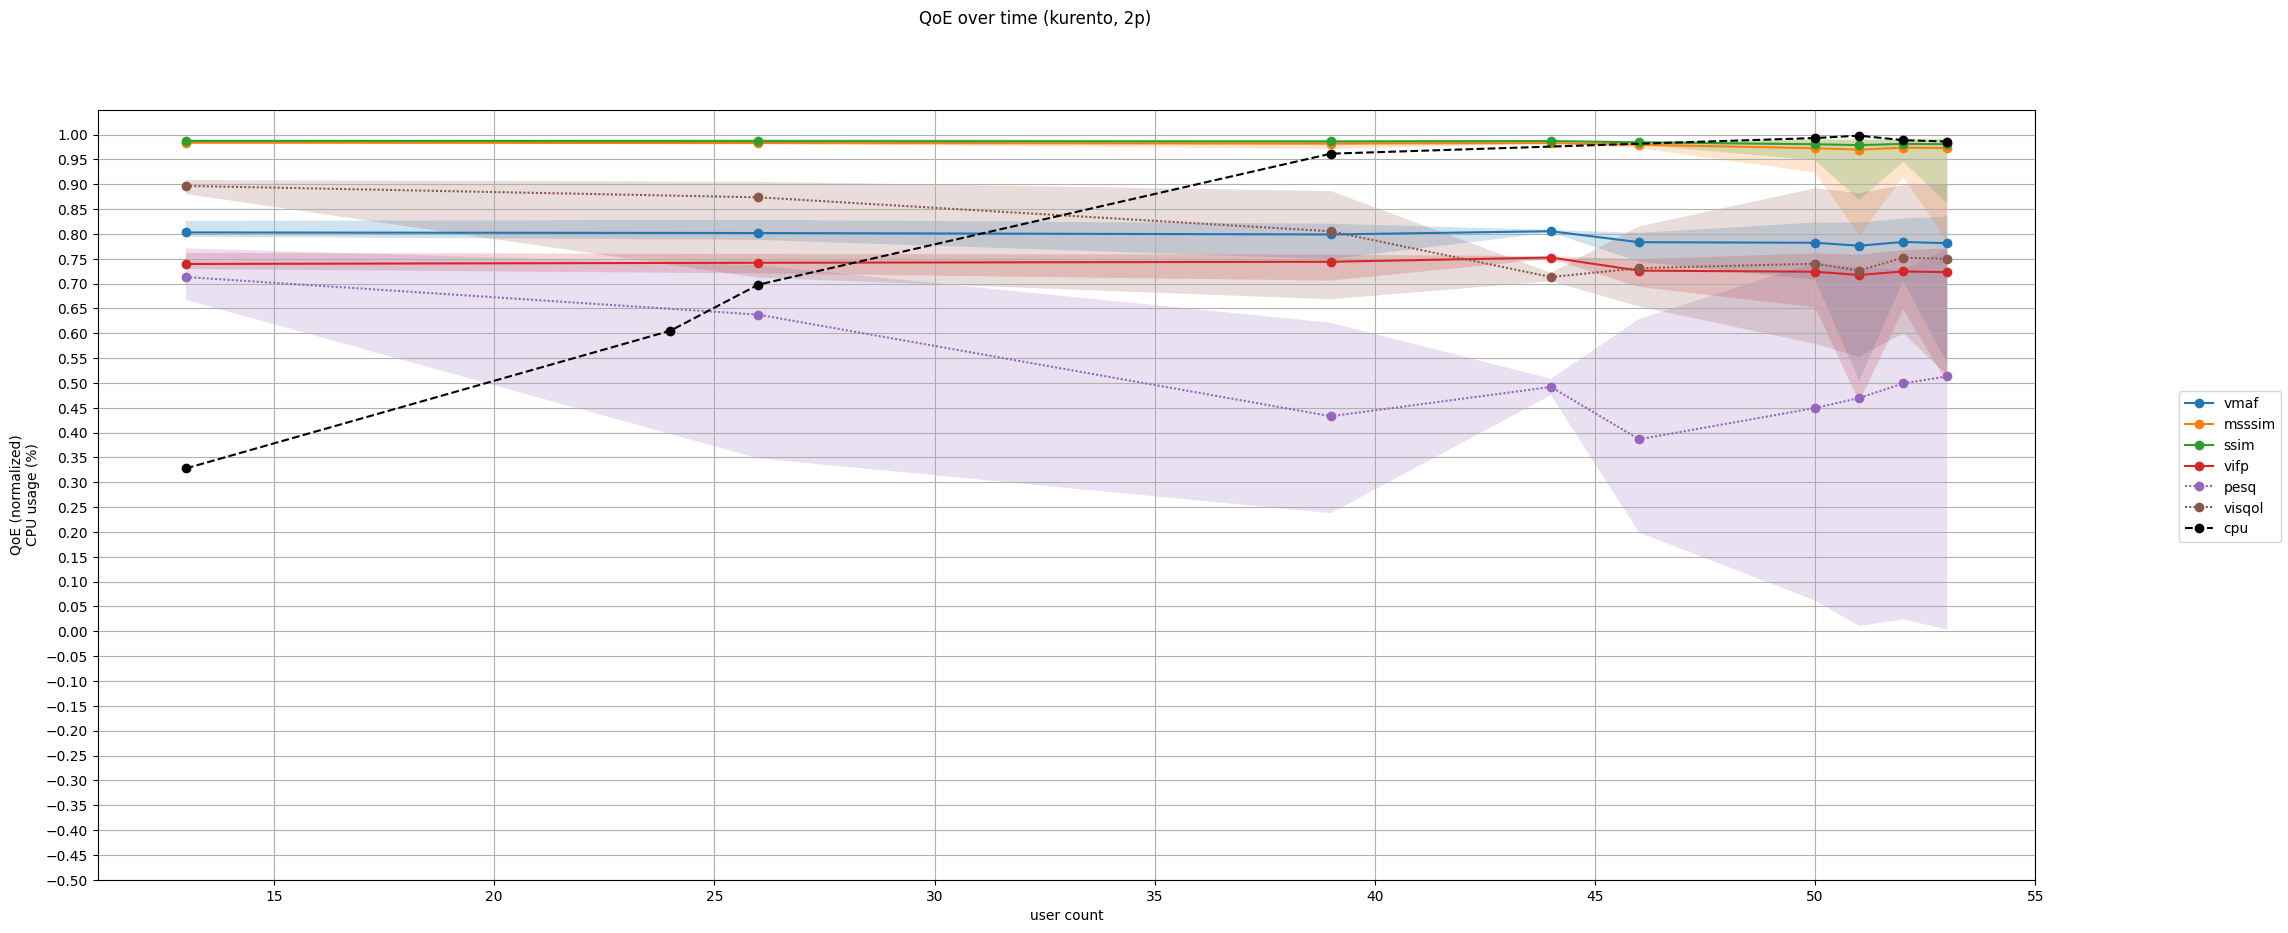

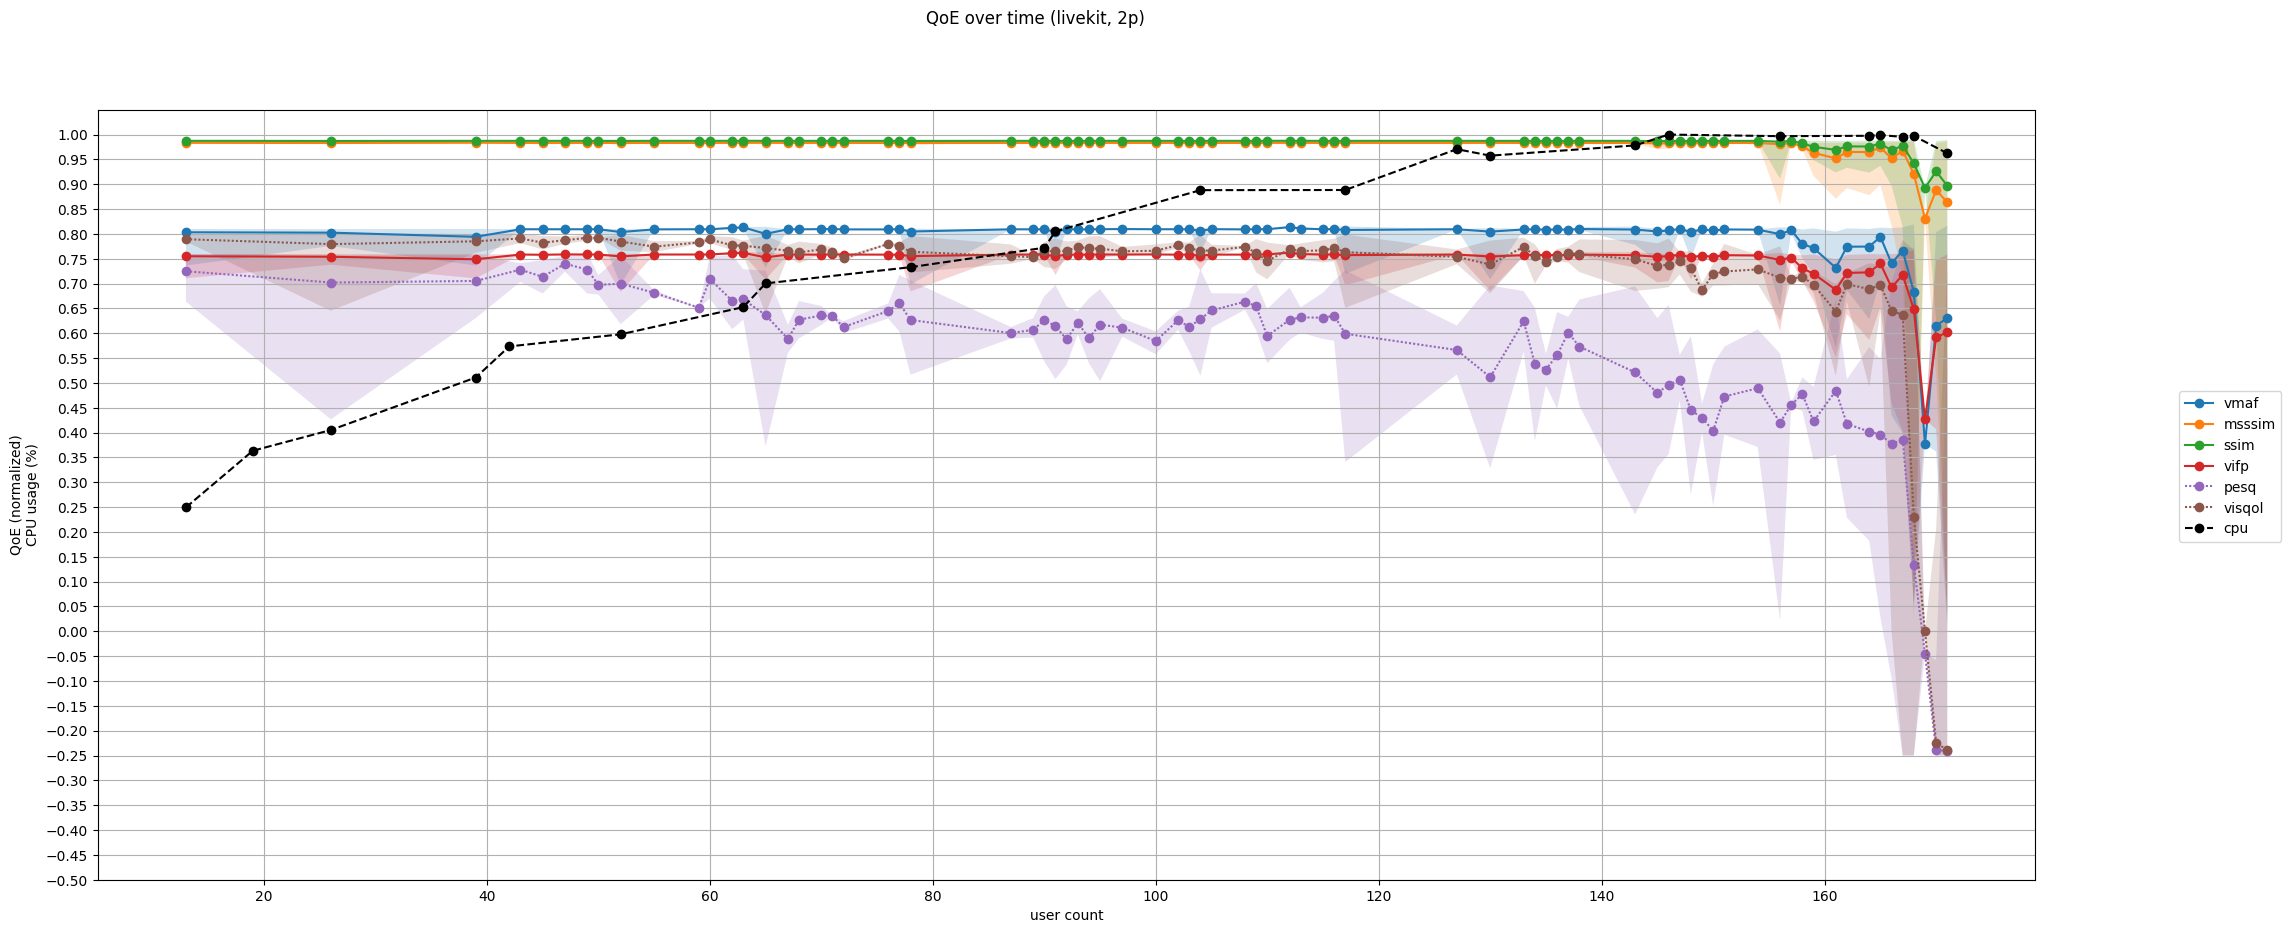

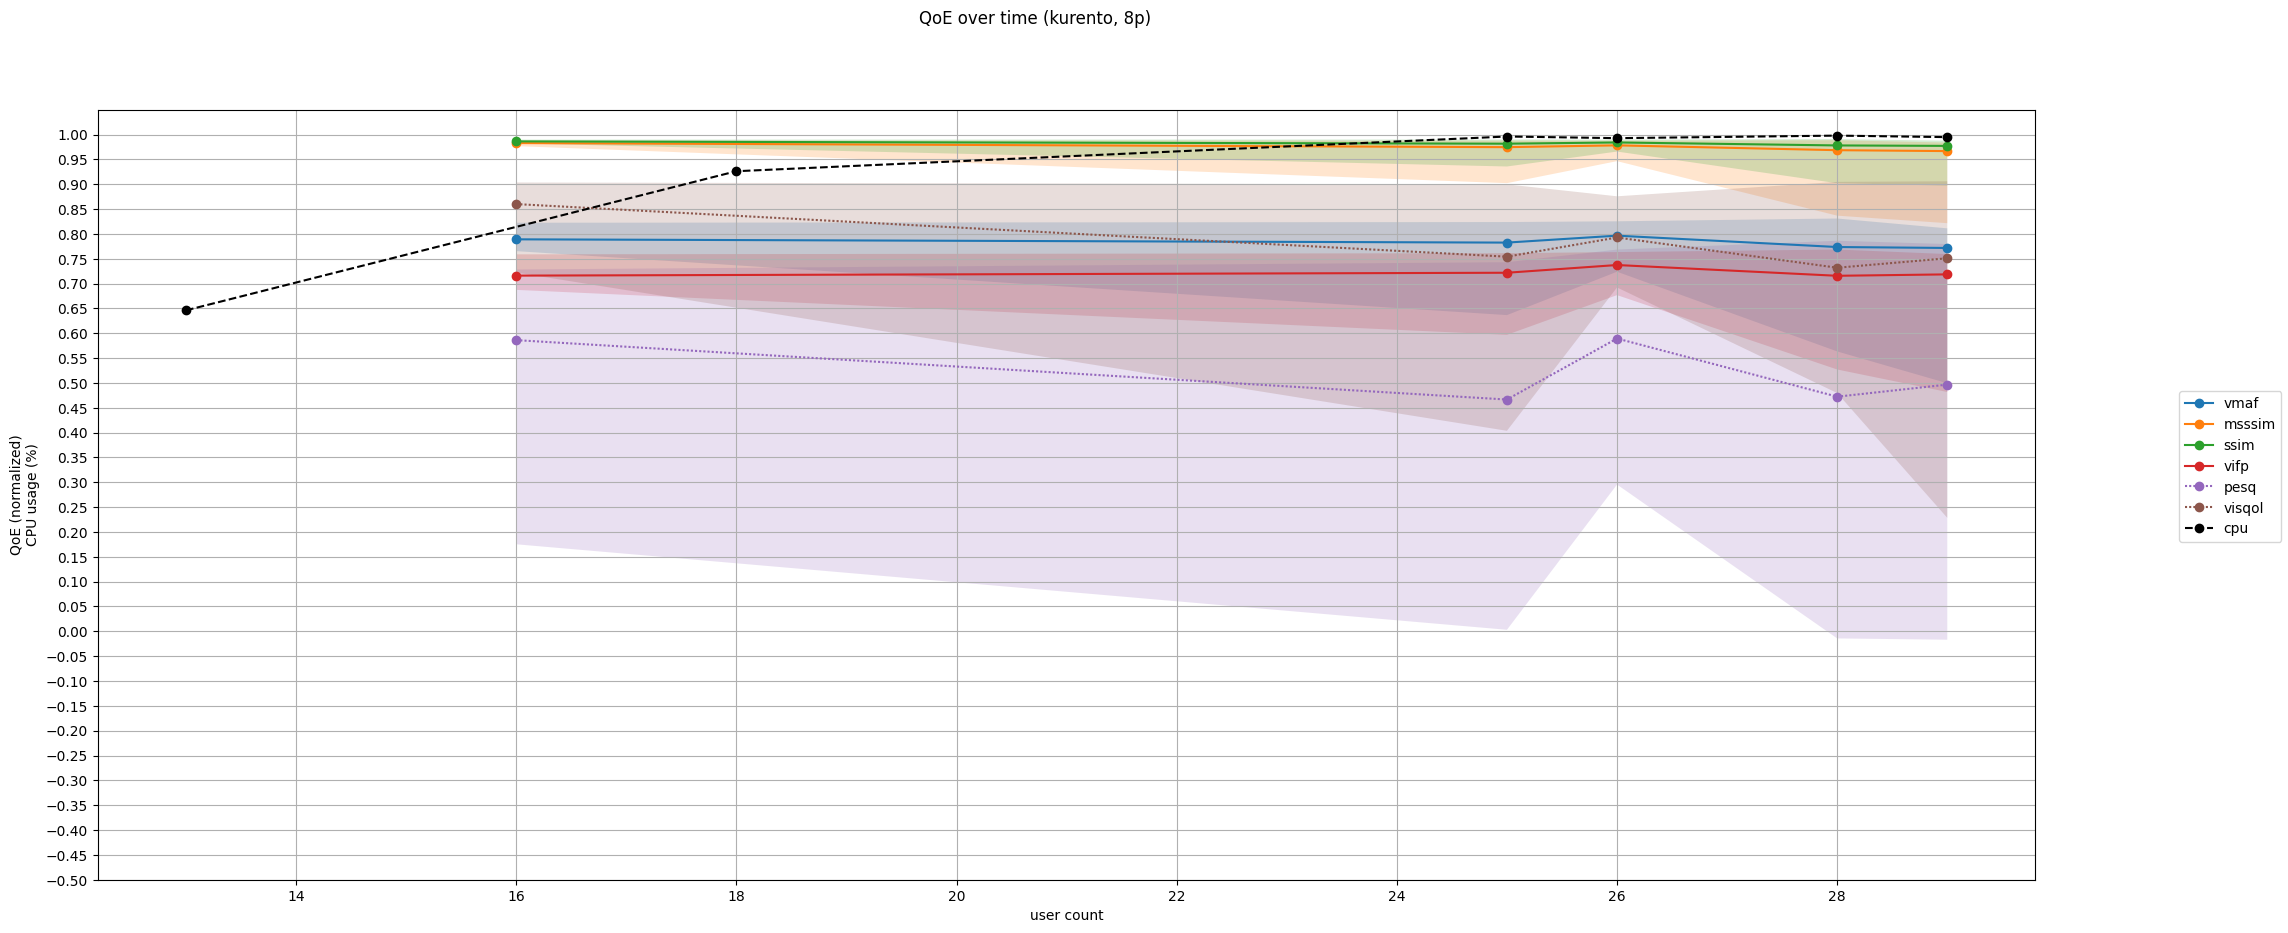

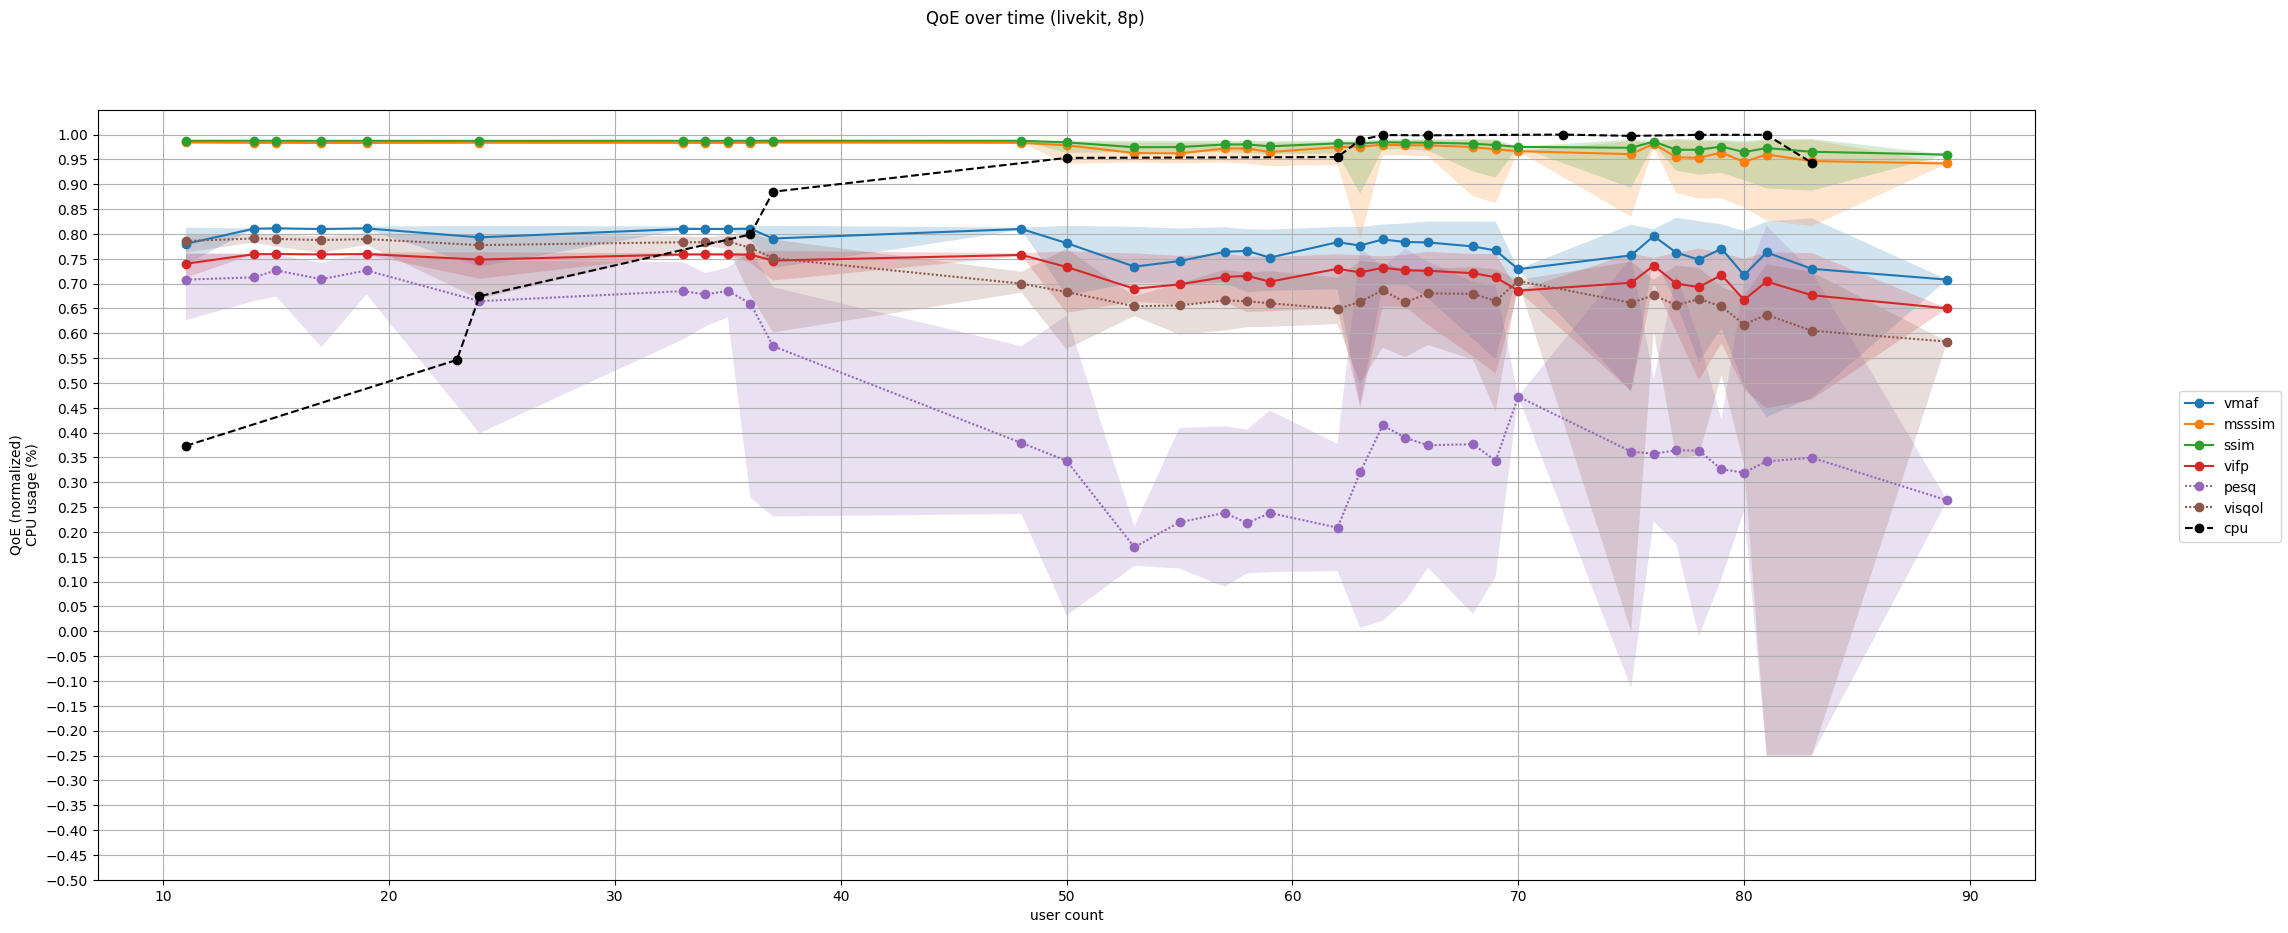

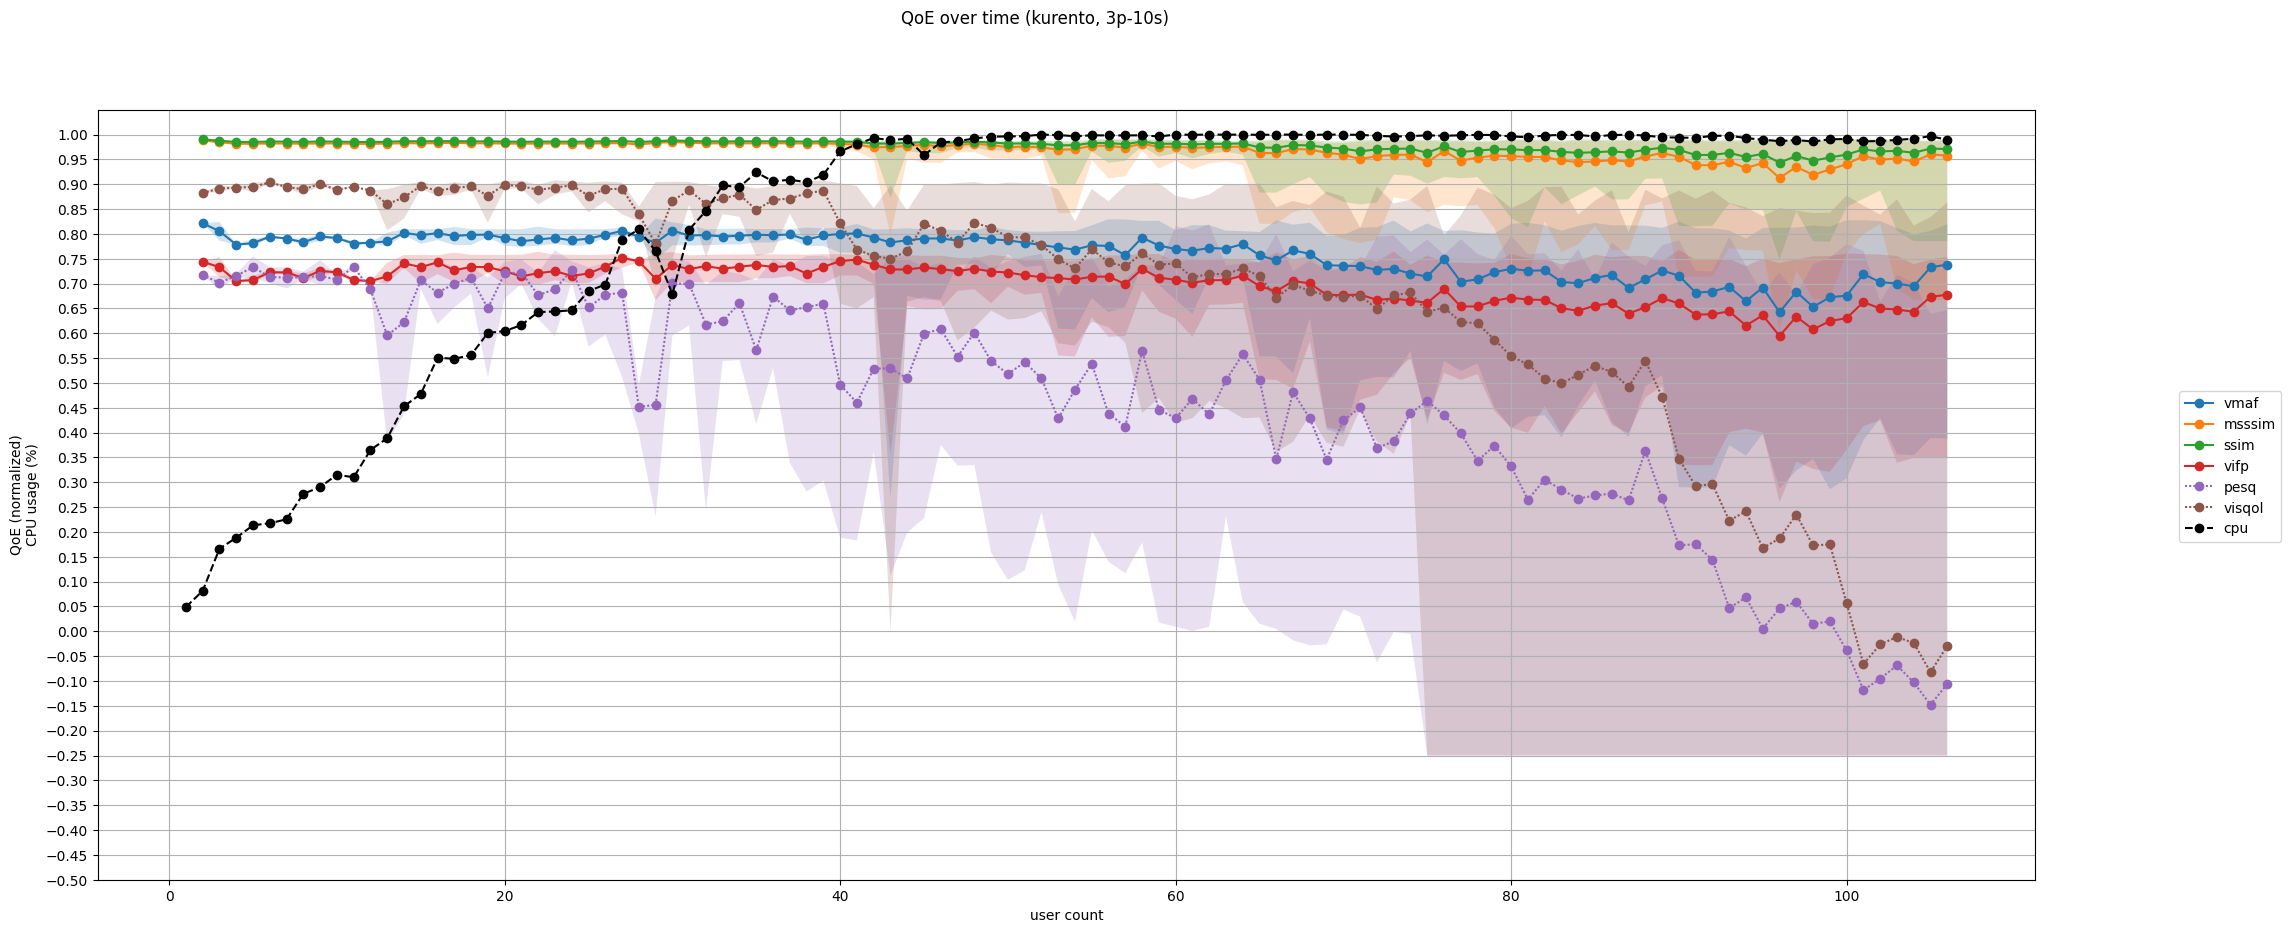

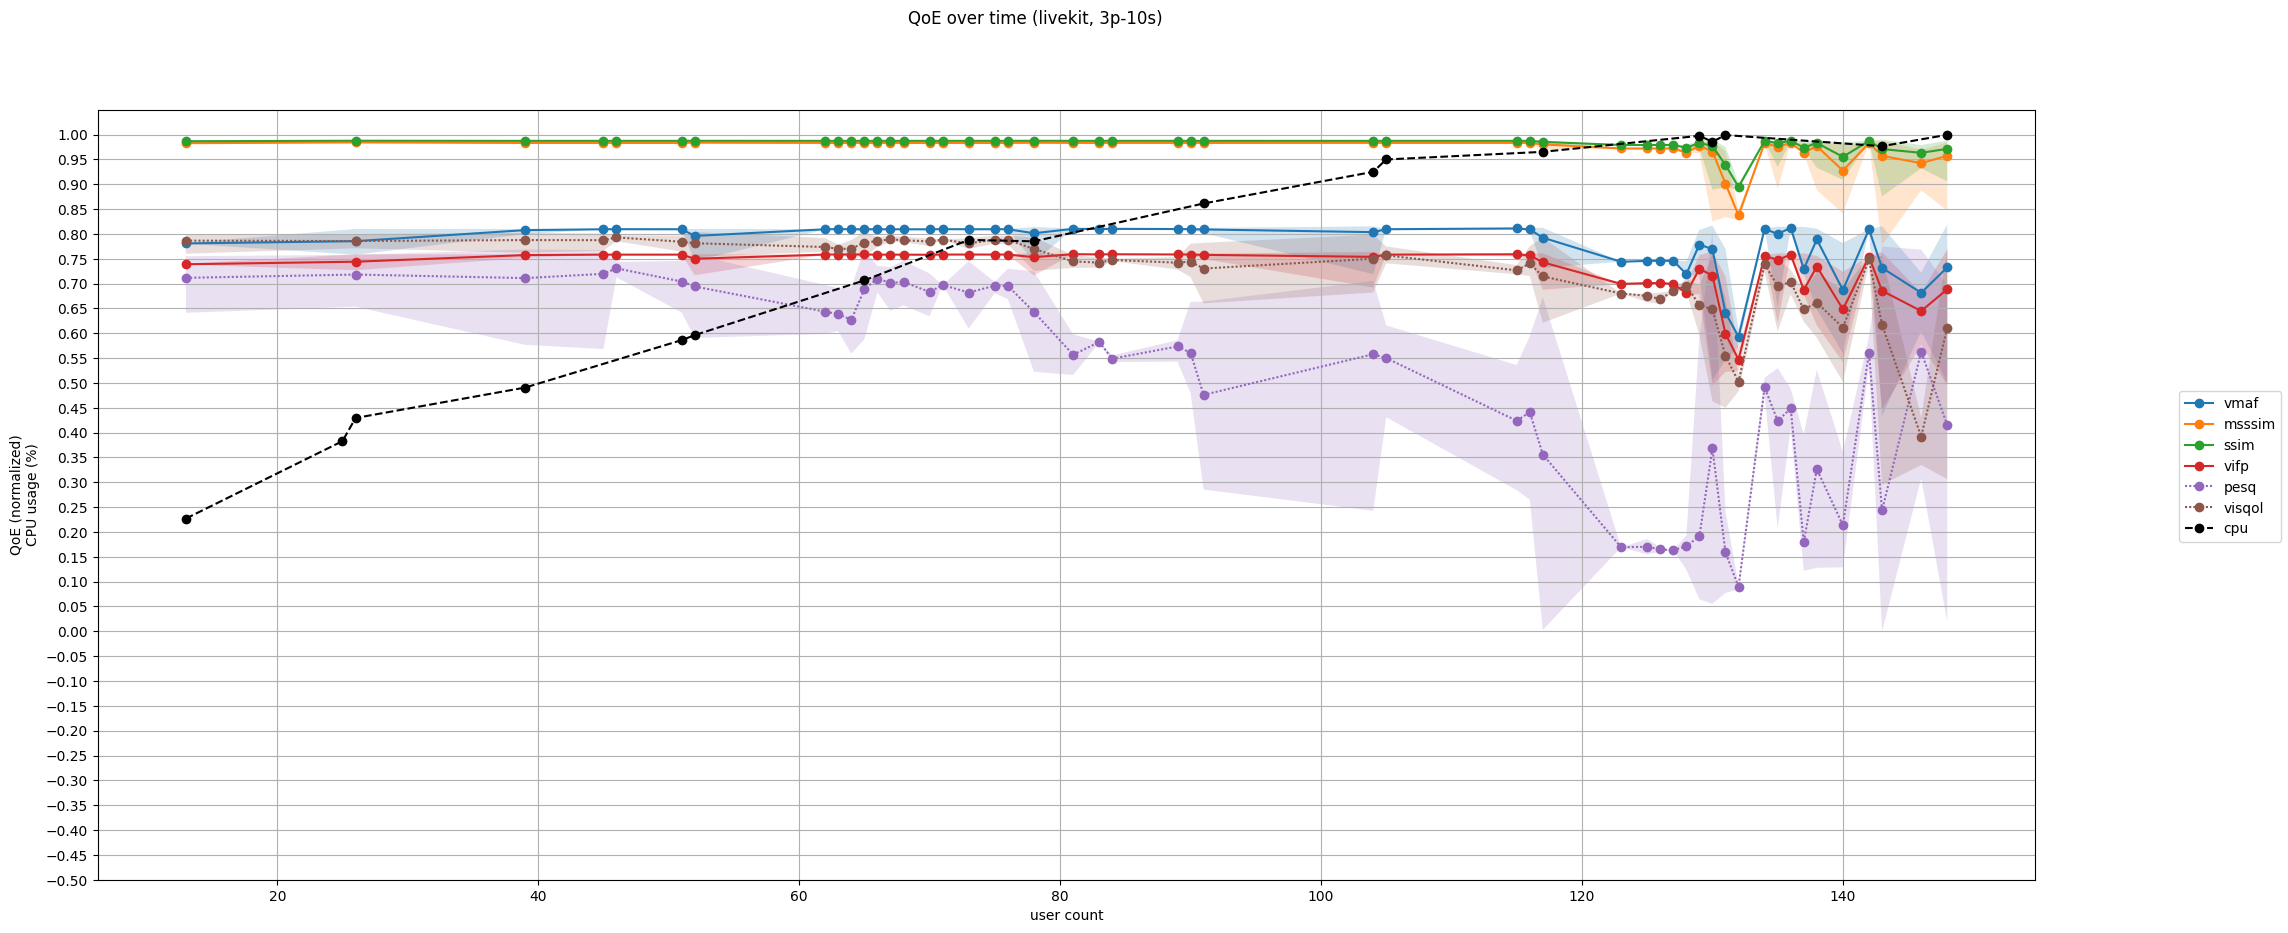

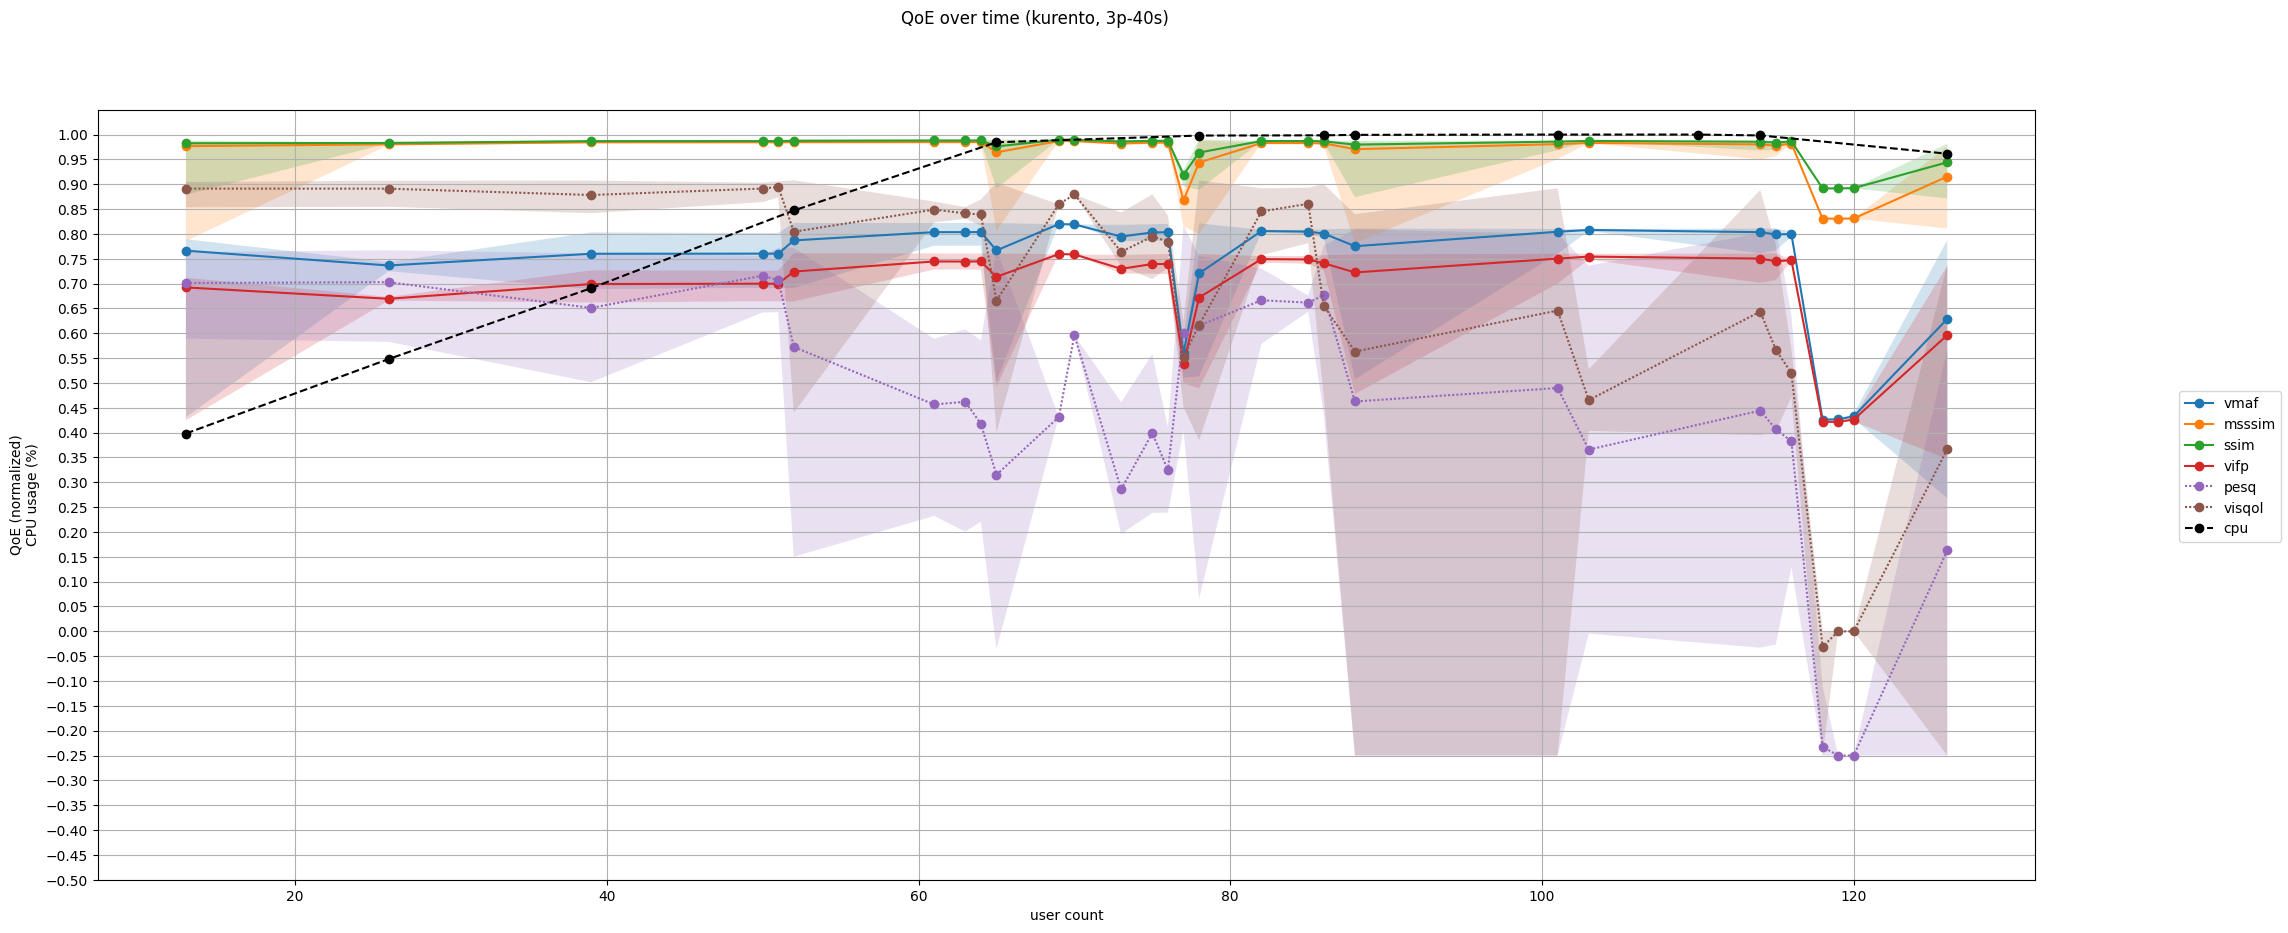

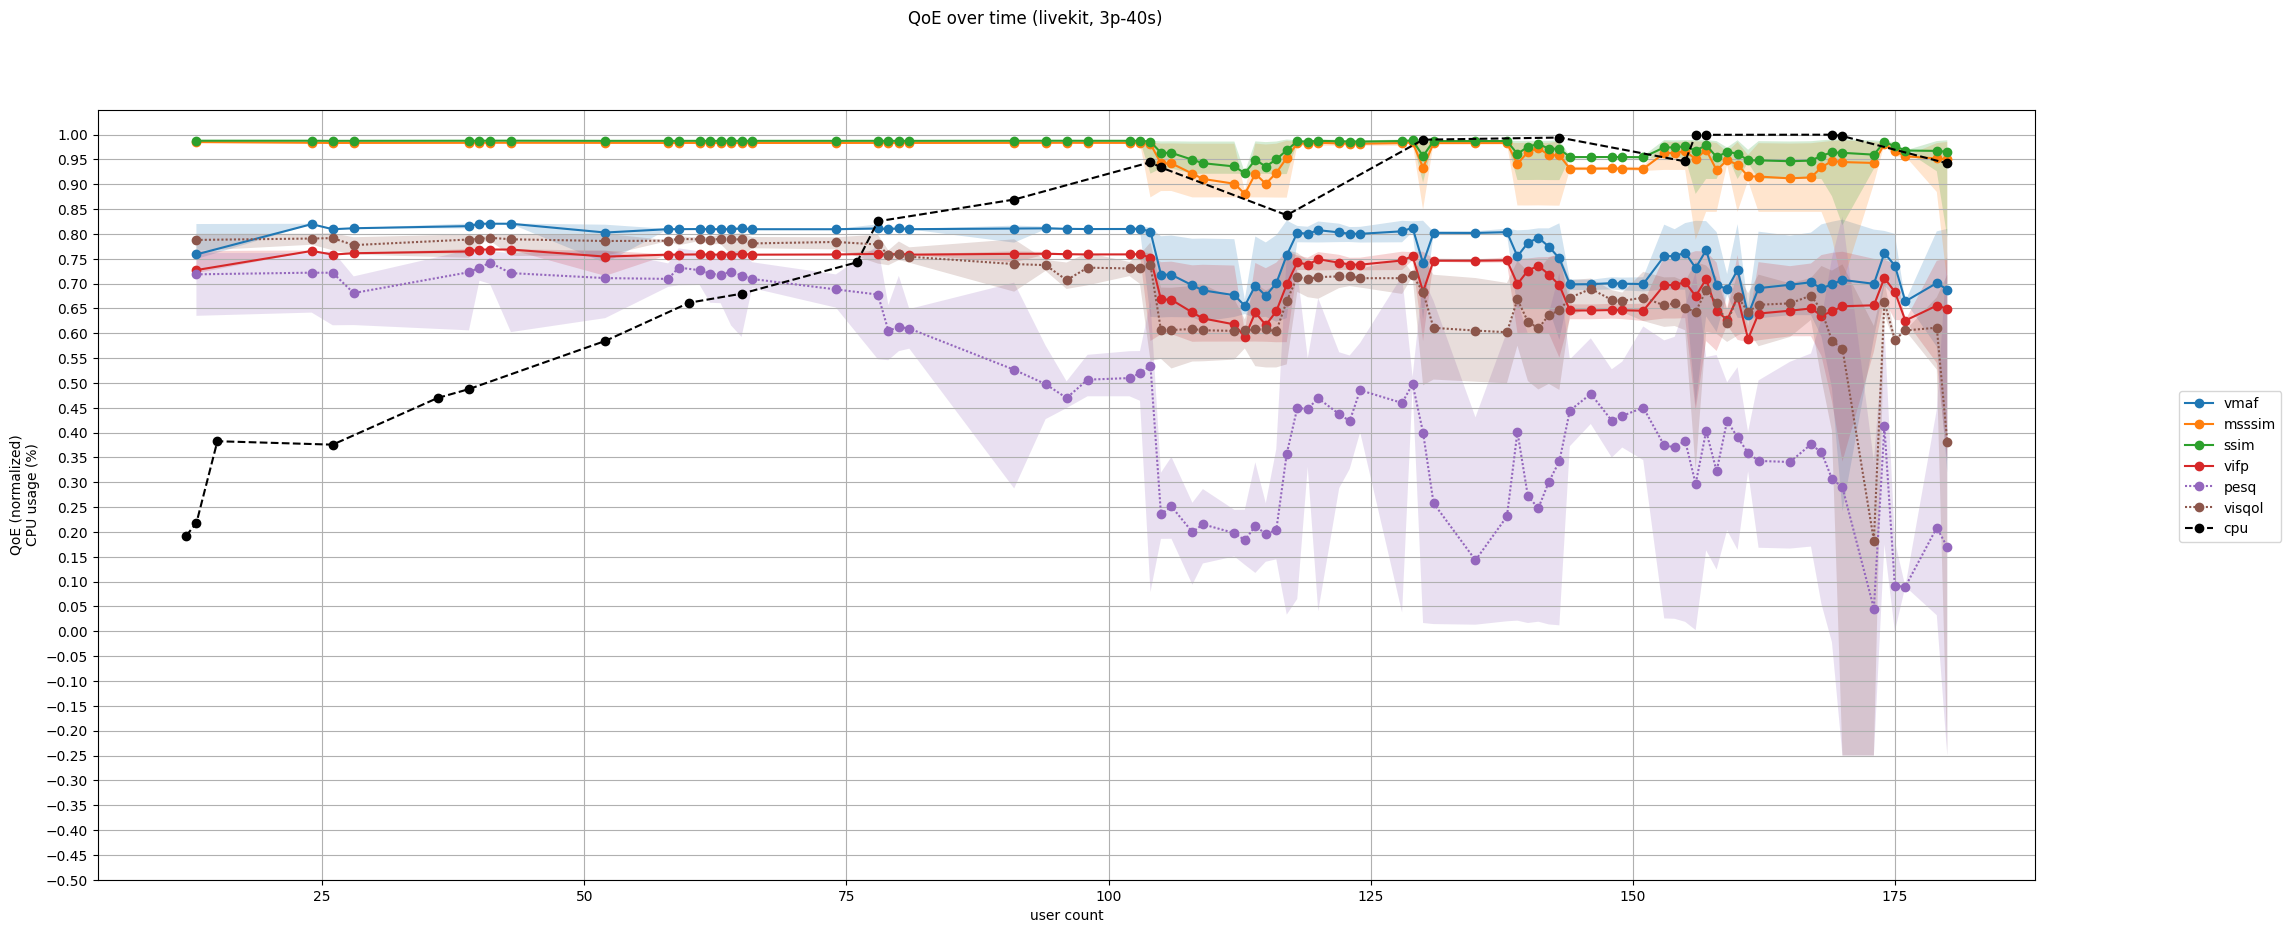

In [6]:
plt.rcParams["figure.figsize"] = [25, 10]
typologies = ["2p", "8p", "3p-10s", "3p-40s"]
media_nodes = ["kurento", "livekit"]
colors = ["blue", "red"]
for typology in typologies:
    for media_node in media_nodes:

        fig, ax = plt.subplots()
        #also draw scatterplot
        #figs, axs = plt.subplots()
        target_names = filter(
            lambda x: typology in x and media_node in x and "retry" in x, index_list_names
        )
        #max_x = -1
        for i, target_name in enumerate(target_names):
            df_tmp = df_list[index_list_names.index(target_name)].copy()
            #df_tmp = pd.read_csv(f"dfs_final/{target_name}.csv")
            user_join = pd.read_csv(f"dfs_final/{target_name}-user-join.csv")
            cpu_mem = pd.read_csv(f"dfs_final/{target_name}-medianode.csv")
            user_join = timestamp_to_secs(user_join, target_name)
            cpu_mem = timestamp_to_secs(cpu_mem, target_name)
            cpu_mem = cpu_mem.drop(columns=["memory"]).dropna()
            cpu_mem = cpu_mem.sort_values(by="@timestamp")
            cpu_mem['user_count'] = [len(user_join[user_join['@timestamp'] <= ts]) for ts in cpu_mem['@timestamp']]
            cpu_mem = cpu_mem[cpu_mem['user_count'] > 0]
            cpu_mem = cpu_mem.groupby('user_count').mean(numeric_only=True)
            # remove entries with cpu < 0.001
            # df_node = df_node[df_node["cpu"] > 0.001]
            #df_node = timestamp_to_secs(df_node, target_name)
            # aproximate cut_index to the nearest 10 seconds
            # max_timestamp = df_tmp["cut_index"].max()
            # if df_tmp["cut_index"].max() > 8000:
            #     #df_tmp["cut_index"] = df_tmp["cut_index"].round(-3)
            # #elif df_tmp["cut_index"].max() > 1000:
            #     #df_tmp["cut_index"] = df_tmp["cut_index"].round(-2)
            # else:
            # df_tmp["cut_index"] = df_tmp["cut_index"].round(-1)
            # for metric in qoe_metrics_normalized:
            #     axs.scatter(df_tmp["user_count"], df_tmp[metric], label=metric)
            df_mean = df_tmp.groupby(["user_count"]).mean(numeric_only=True)
            df_max = df_tmp.groupby(["user_count"]).max(numeric_only=True)
            df_min = df_tmp.groupby(["user_count"]).min(numeric_only=True)

            plot_name = target_name

            if not df_mean.empty:
                for metric in qoe_metrics_normalized:
                    # TODO: Probar usando eje X user_count
                    # TODO: Calcular media y std
                    # TODO: Cuanto tarda en meterse X numero de usuarios en un media server
                    # TODO: Tiempo de conexión vs número de usuarios (a lo mejor meter CPU)
                    if metric == "pesq" or metric == "visqol":
                        ax.plot(df_mean.index, df_mean[metric], label=metric, marker="o", linestyle=(0,(1,1)))
                    else:
                        ax.plot(df_mean.index, df_mean[metric], label=metric, marker="o")
                    ax.fill_between(df_mean.index, df_min[metric], df_max[metric], alpha=0.2)
            ax.plot(cpu_mem.index, cpu_mem["cpu"], label="cpu", linestyle="--", color="black", marker='o')

        ax.set_xlabel("user count")
        ax.set_ylabel("QoE (normalized)\nCPU usage (%)")
        ax.grid()
        ax.set_ylim(-0.5, 1.05)
        ax.set_yticks(np.arange(-0.5, 1.05, 0.05))

        fig.suptitle(f"QoE over time ({media_node}, {typology})")
        fig.legend(loc="right")
        fig.savefig(f"images_final/{typology}_{media_node}_qoe_usercount.png")

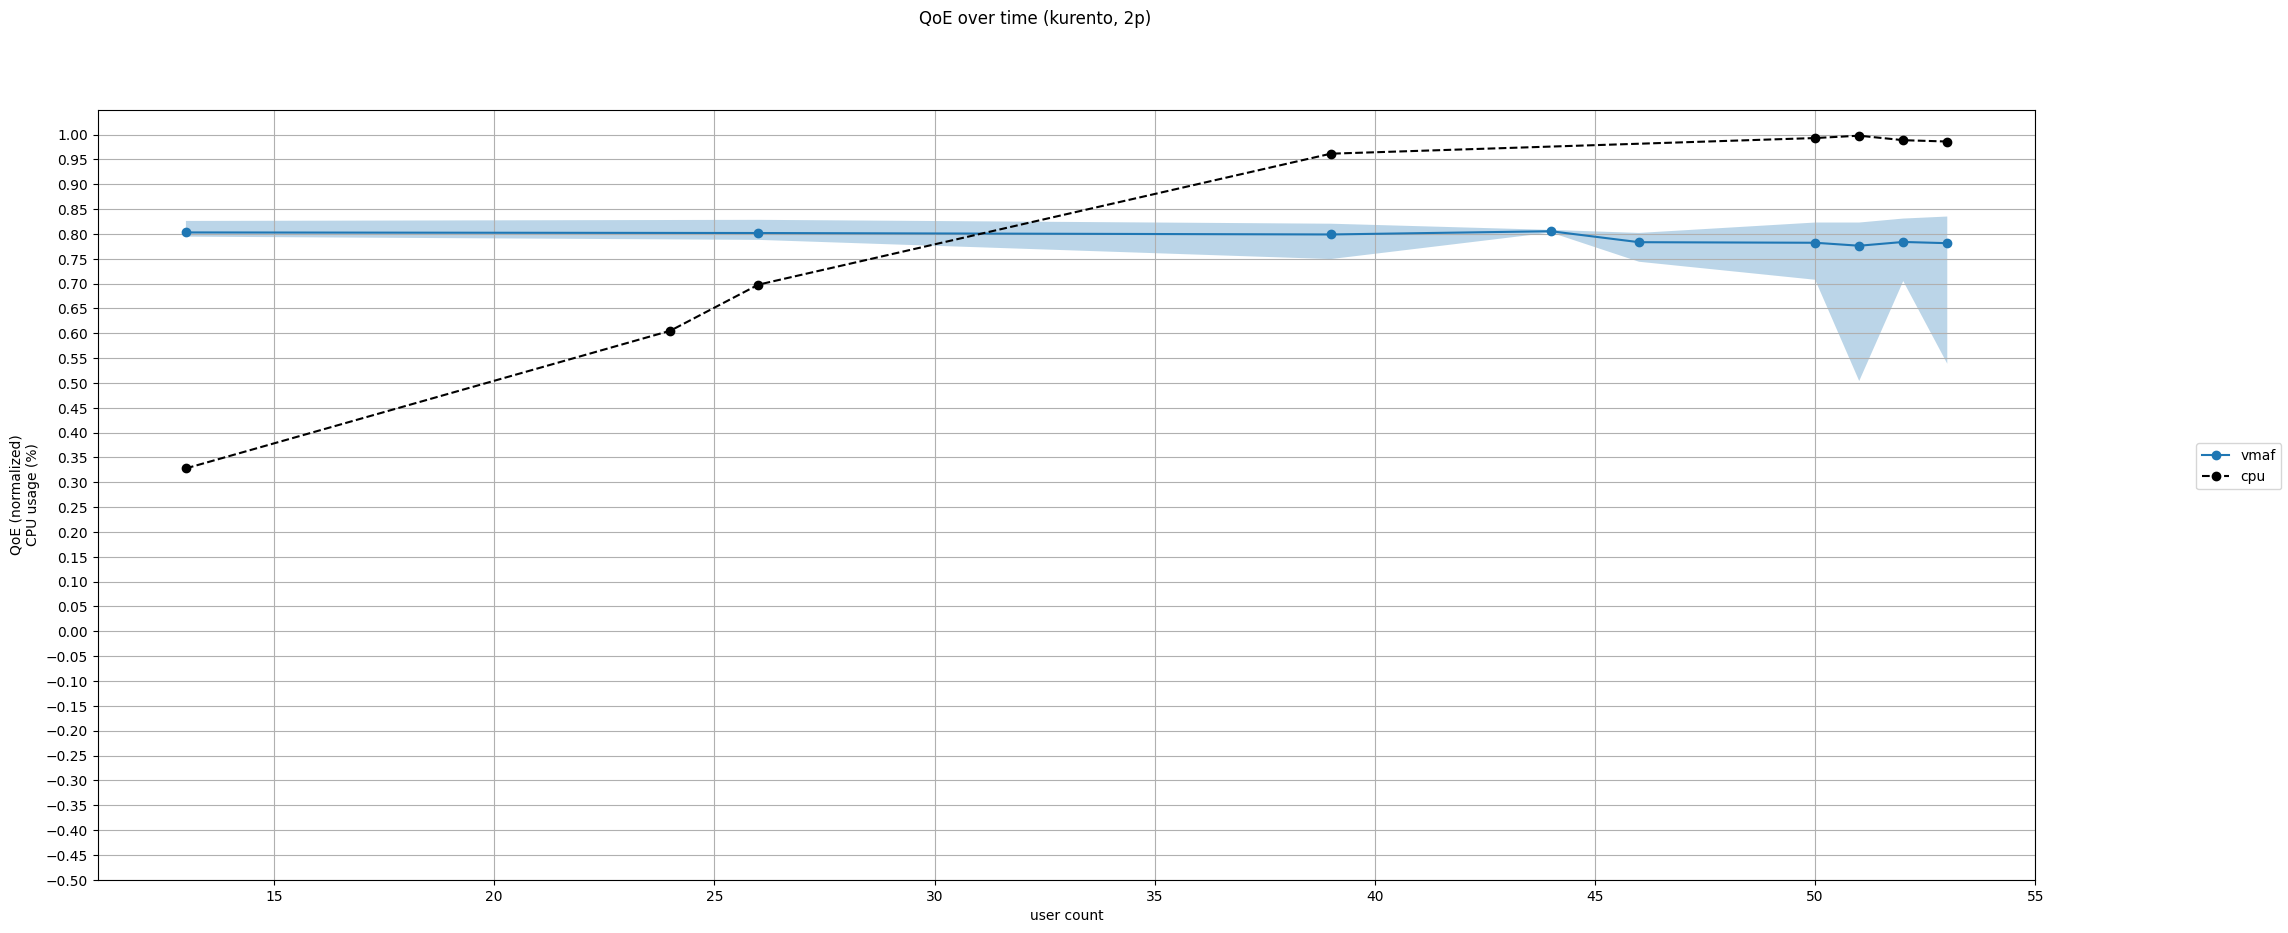

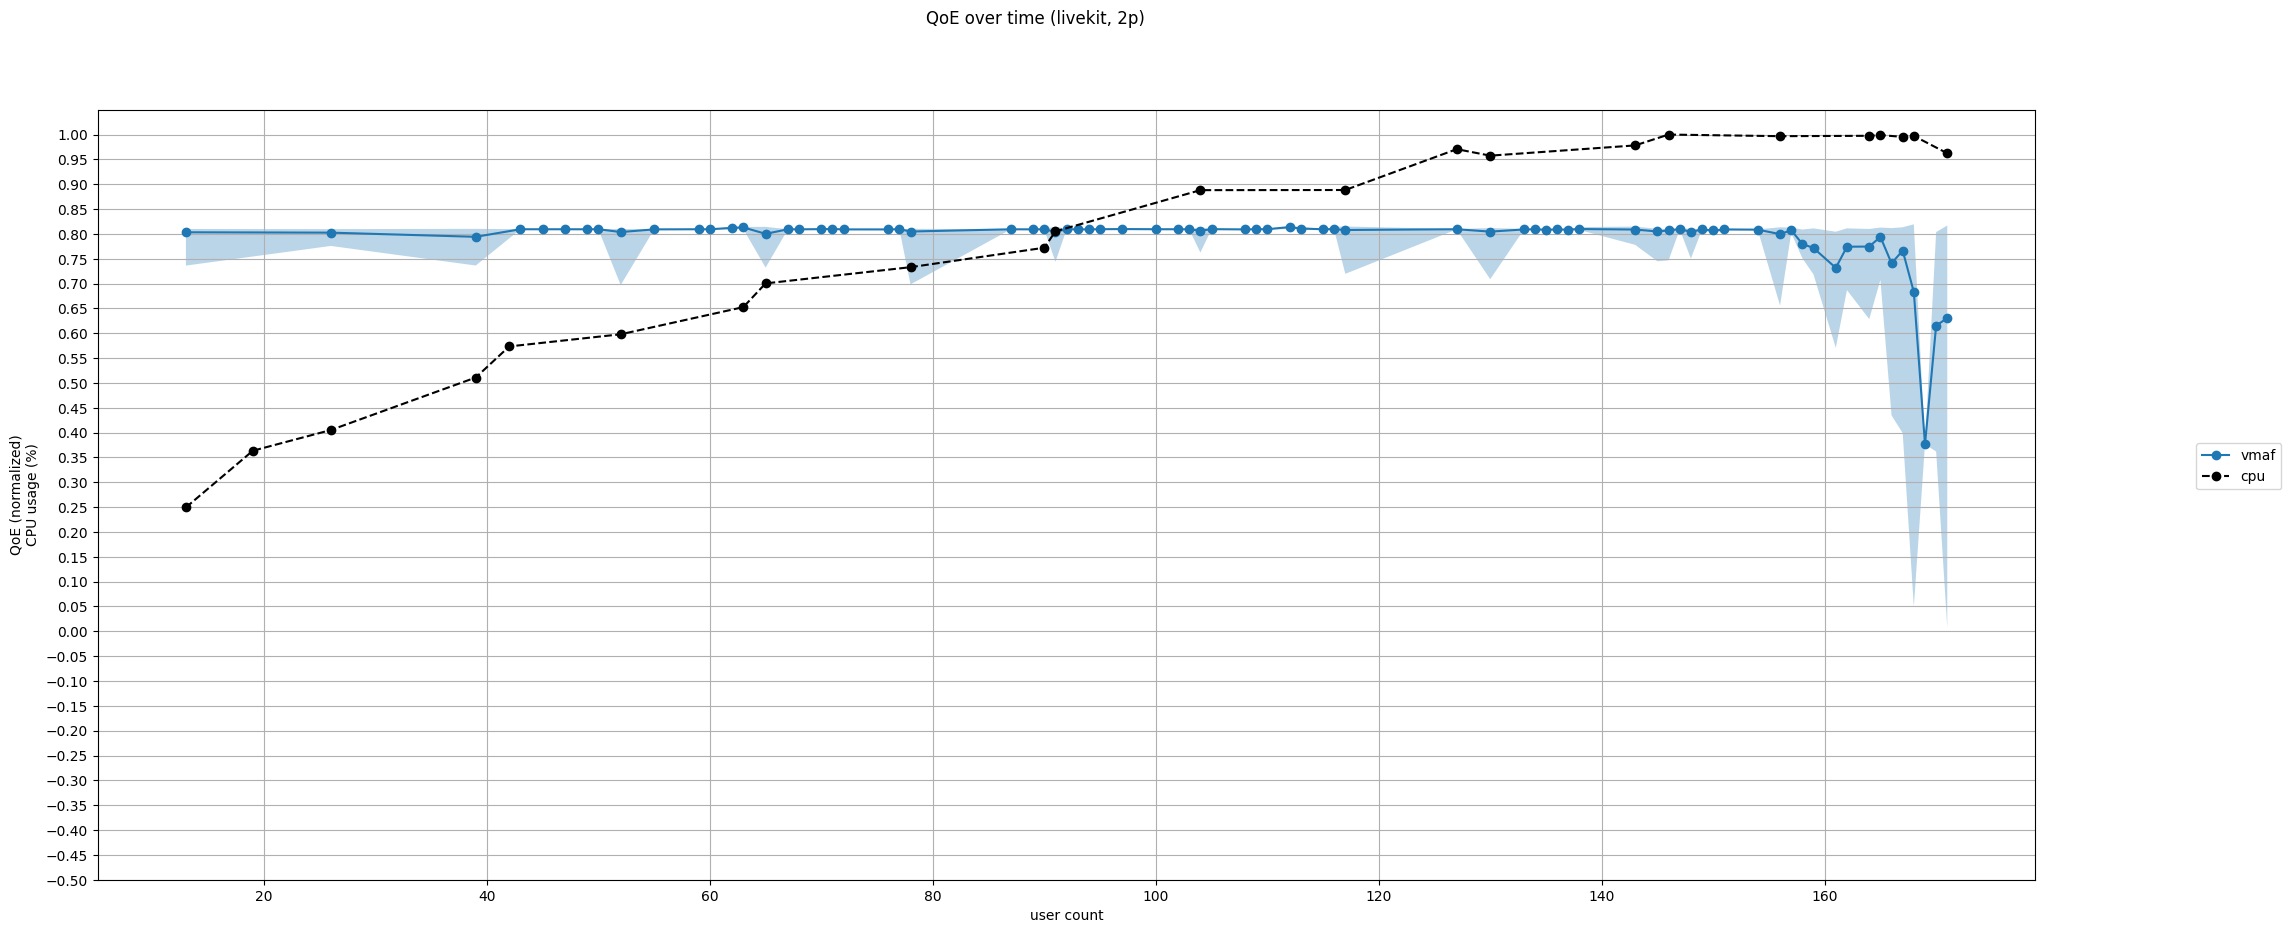

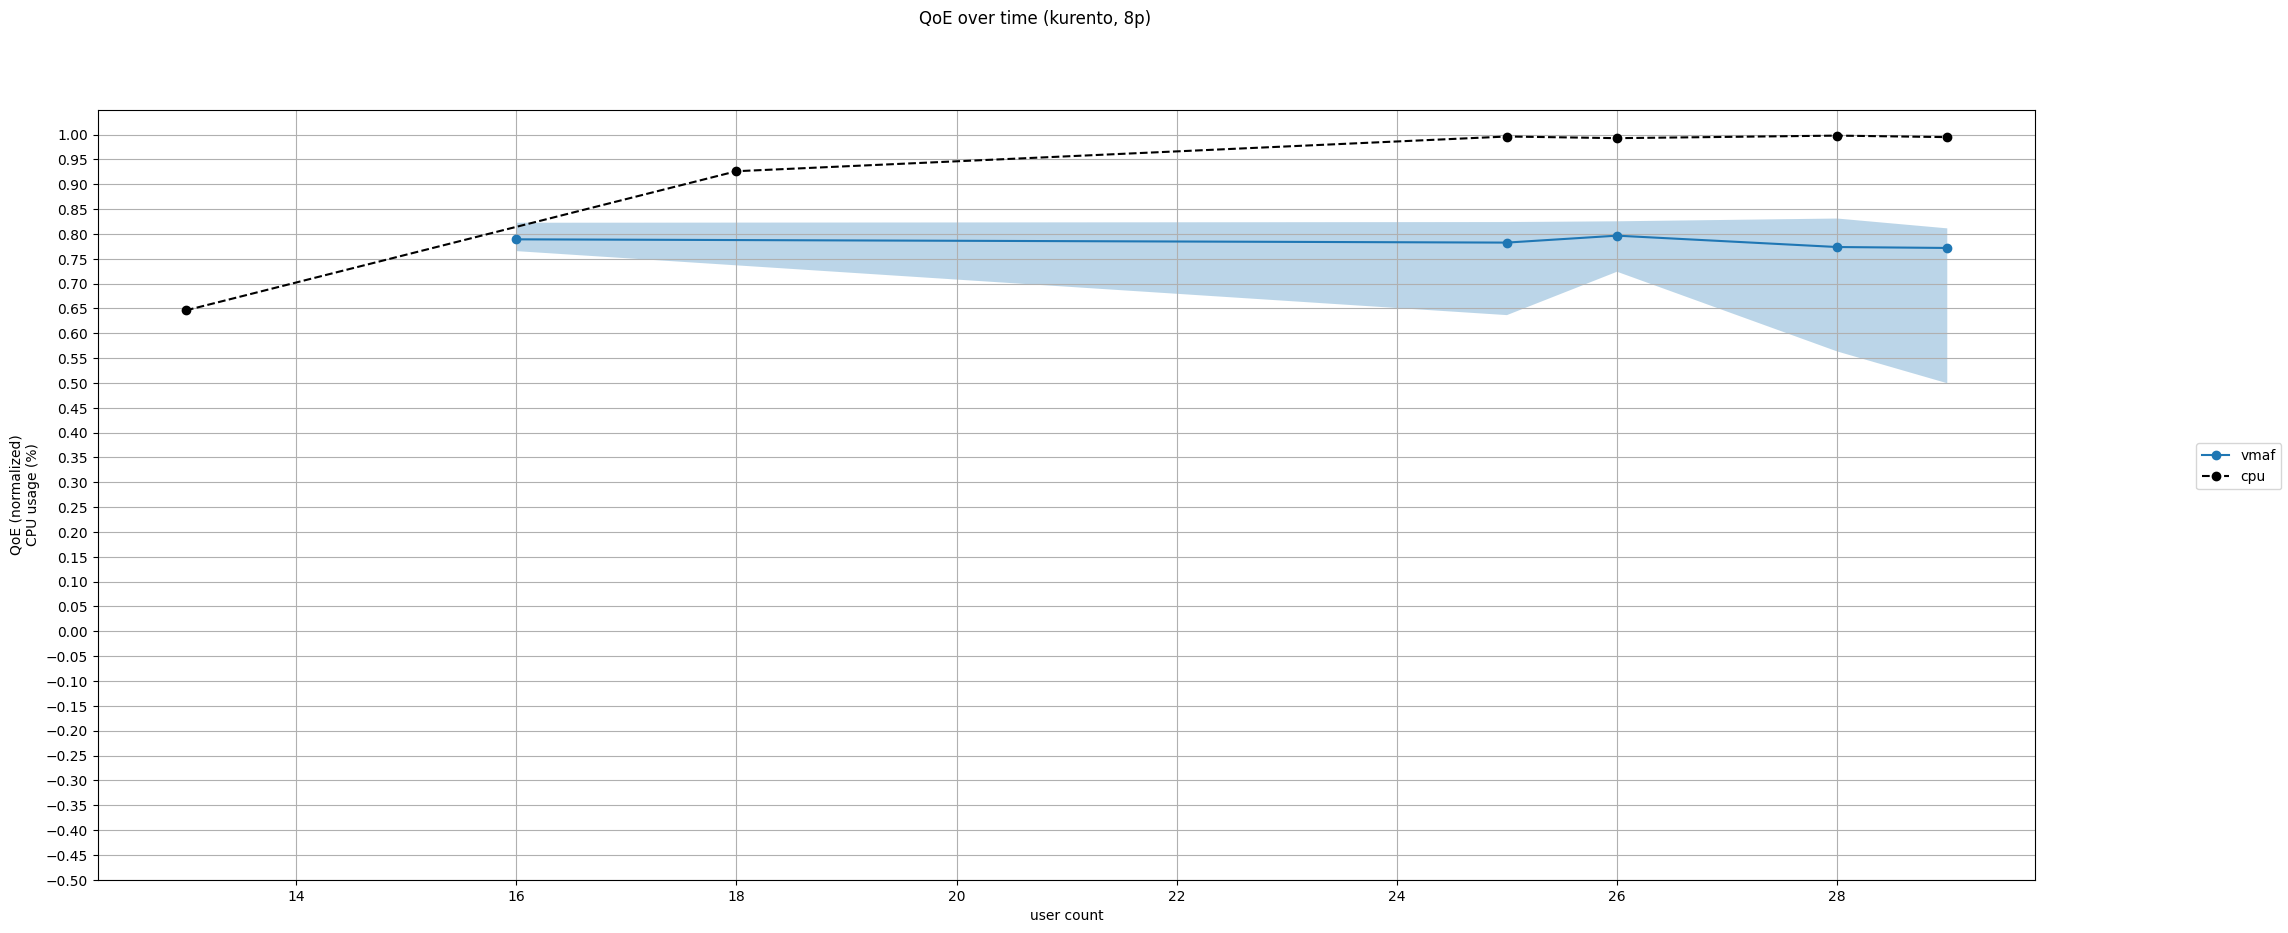

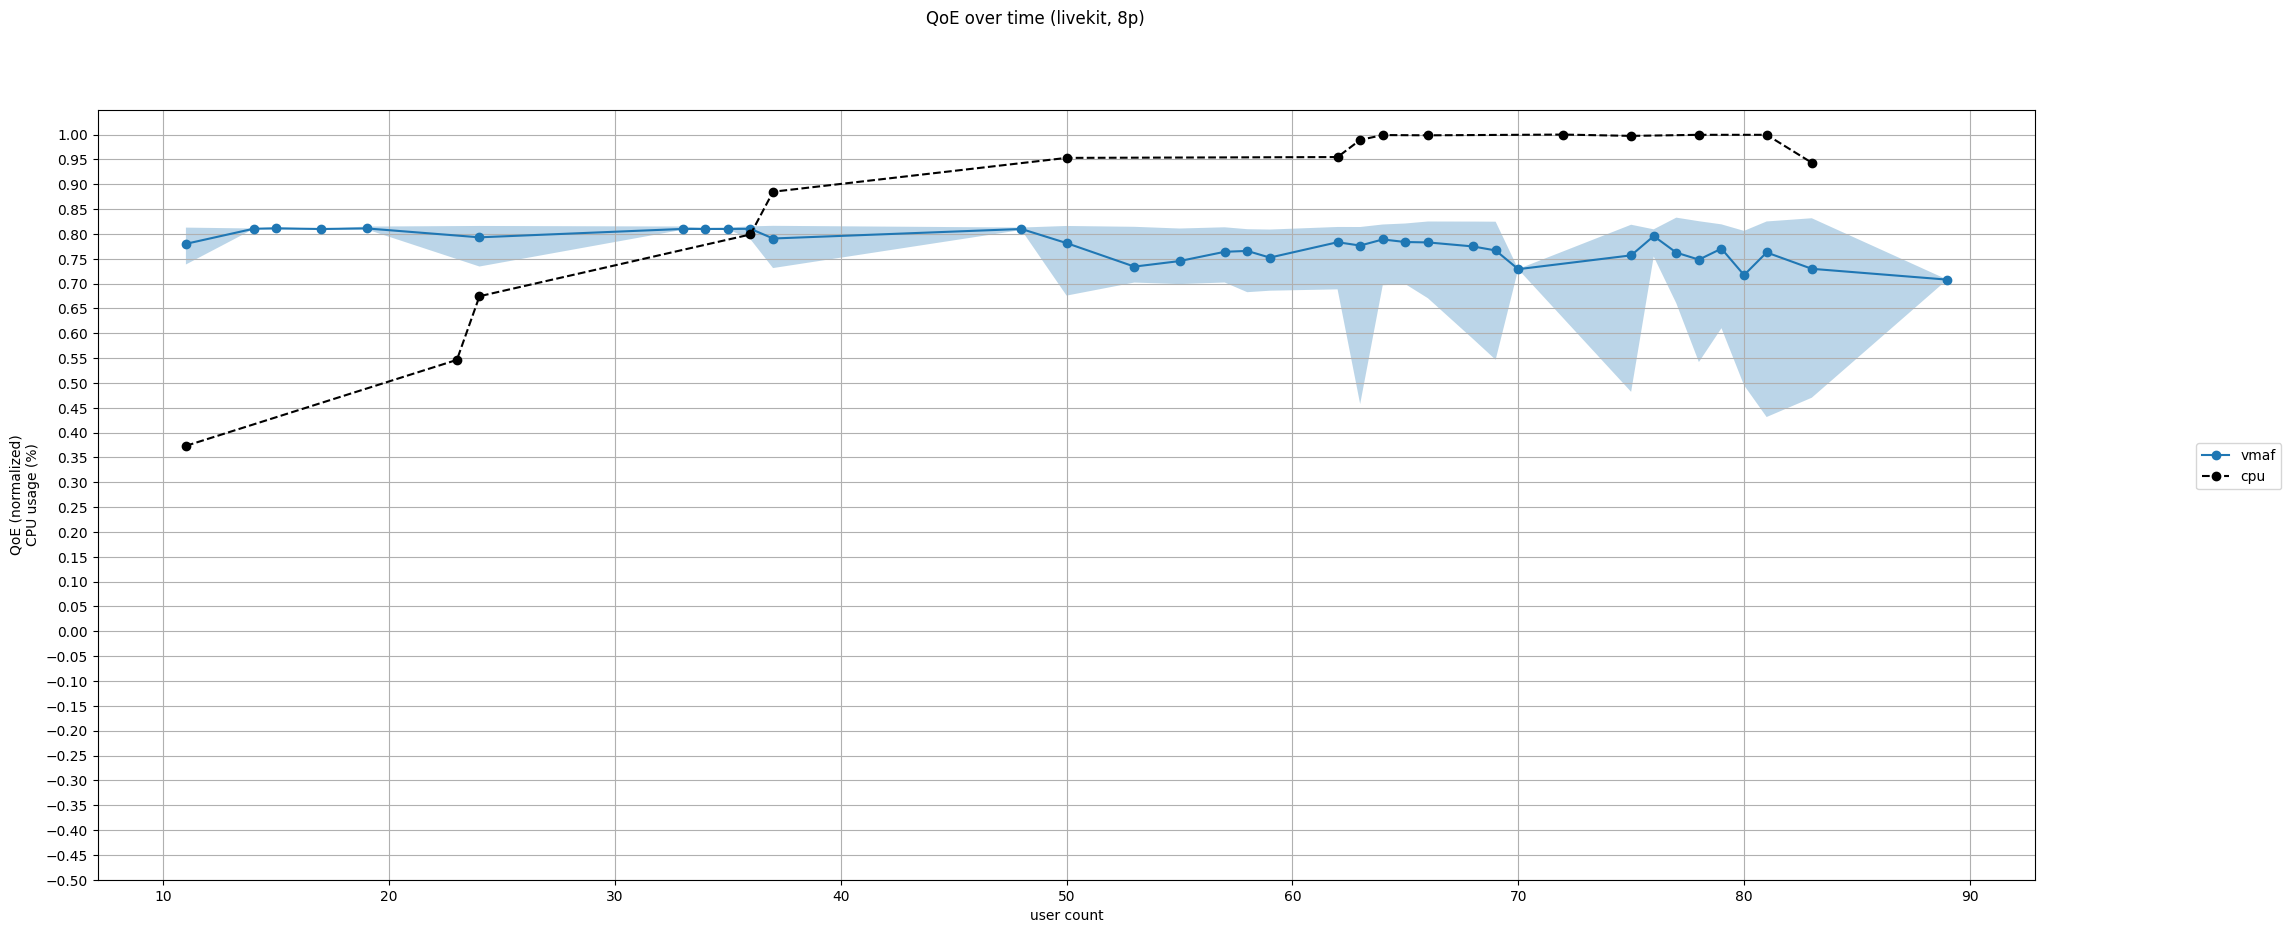

In [7]:
plt.rcParams["figure.figsize"] = [25, 10]
typologies = ["2p", "8p"]
media_nodes = ["kurento", "livekit"]
colors = ["blue", "red"]
metric = "vmaf"
for typology in typologies:
    for media_node in media_nodes:

        fig, ax = plt.subplots()
        #also draw scatterplot
        #figs, axs = plt.subplots()
        target_names = filter(
            lambda x: typology in x and media_node in x and "retry" in x, index_list_names
        )
        #max_x = -1
        for i, target_name in enumerate(target_names):
            df_tmp = df_list[index_list_names.index(target_name)].copy()
            #df_tmp = pd.read_csv(f"dfs_final/{target_name}.csv")
            user_join = pd.read_csv(f"dfs_final/{target_name}-user-join.csv")
            cpu_mem = pd.read_csv(f"dfs_final/{target_name}-medianode.csv")
            user_join = timestamp_to_secs(user_join, target_name)
            cpu_mem = timestamp_to_secs(cpu_mem, target_name)
            cpu_mem = cpu_mem.drop(columns=["memory"]).dropna()
            cpu_mem = cpu_mem.sort_values(by="@timestamp")
            cpu_mem['user_count'] = [len(user_join[user_join['@timestamp'] <= ts]) for ts in cpu_mem['@timestamp']]
            cpu_mem = cpu_mem[cpu_mem['user_count'] > 0]
            cpu_mem = cpu_mem.groupby('user_count').mean(numeric_only=True)
            # remove entries with cpu < 0.001
            # df_node = df_node[df_node["cpu"] > 0.001]
            #df_node = timestamp_to_secs(df_node, target_name)
            # aproximate cut_index to the nearest 10 seconds
            # max_timestamp = df_tmp["cut_index"].max()
            # if df_tmp["cut_index"].max() > 8000:
            #     #df_tmp["cut_index"] = df_tmp["cut_index"].round(-3)
            # #elif df_tmp["cut_index"].max() > 1000:
            #     #df_tmp["cut_index"] = df_tmp["cut_index"].round(-2)
            # else:
            # df_tmp["cut_index"] = df_tmp["cut_index"].round(-1)
            # for metric in qoe_metrics_normalized:
            #     axs.scatter(df_tmp["user_count"], df_tmp[metric], label=metric)
            df_mean = df_tmp.groupby(["user_count"]).mean(numeric_only=True)
            df_min = df_tmp.groupby(["user_count"]).min(numeric_only=True)
            df_max = df_tmp.groupby(["user_count"]).max(numeric_only=True)

            plot_name = target_name

            if not df_mean.empty:
                # TODO: Probar usando eje X user_count
                # TODO: Calcular media y std
                # TODO: Cuanto tarda en meterse X numero de usuarios en un media server
                # TODO: Tiempo de conexión vs número de usuarios (a lo mejor meter CPU)
                ax.plot(df_mean.index, df_mean[metric], label=metric, marker='o')
                ax.fill_between(df_mean.index, df_min[metric], df_max[metric], alpha=0.3)
            ax.plot(cpu_mem.index, cpu_mem["cpu"], label="cpu", linestyle="--", color="black", marker='o')

        ax.set_xlabel("user count")
        ax.set_ylabel("QoE (normalized)\nCPU usage (%)")
        ax.grid()
        ax.set_ylim(-0.5, 1.05)
        ax.set_yticks(np.arange(-0.5, 1.05, 0.05))

        fig.suptitle(f"QoE over time ({media_node}, {typology})")
        fig.legend(loc="right")
        fig.savefig(f"images_final/{typology}_{media_node}_qoe_usercount.png")

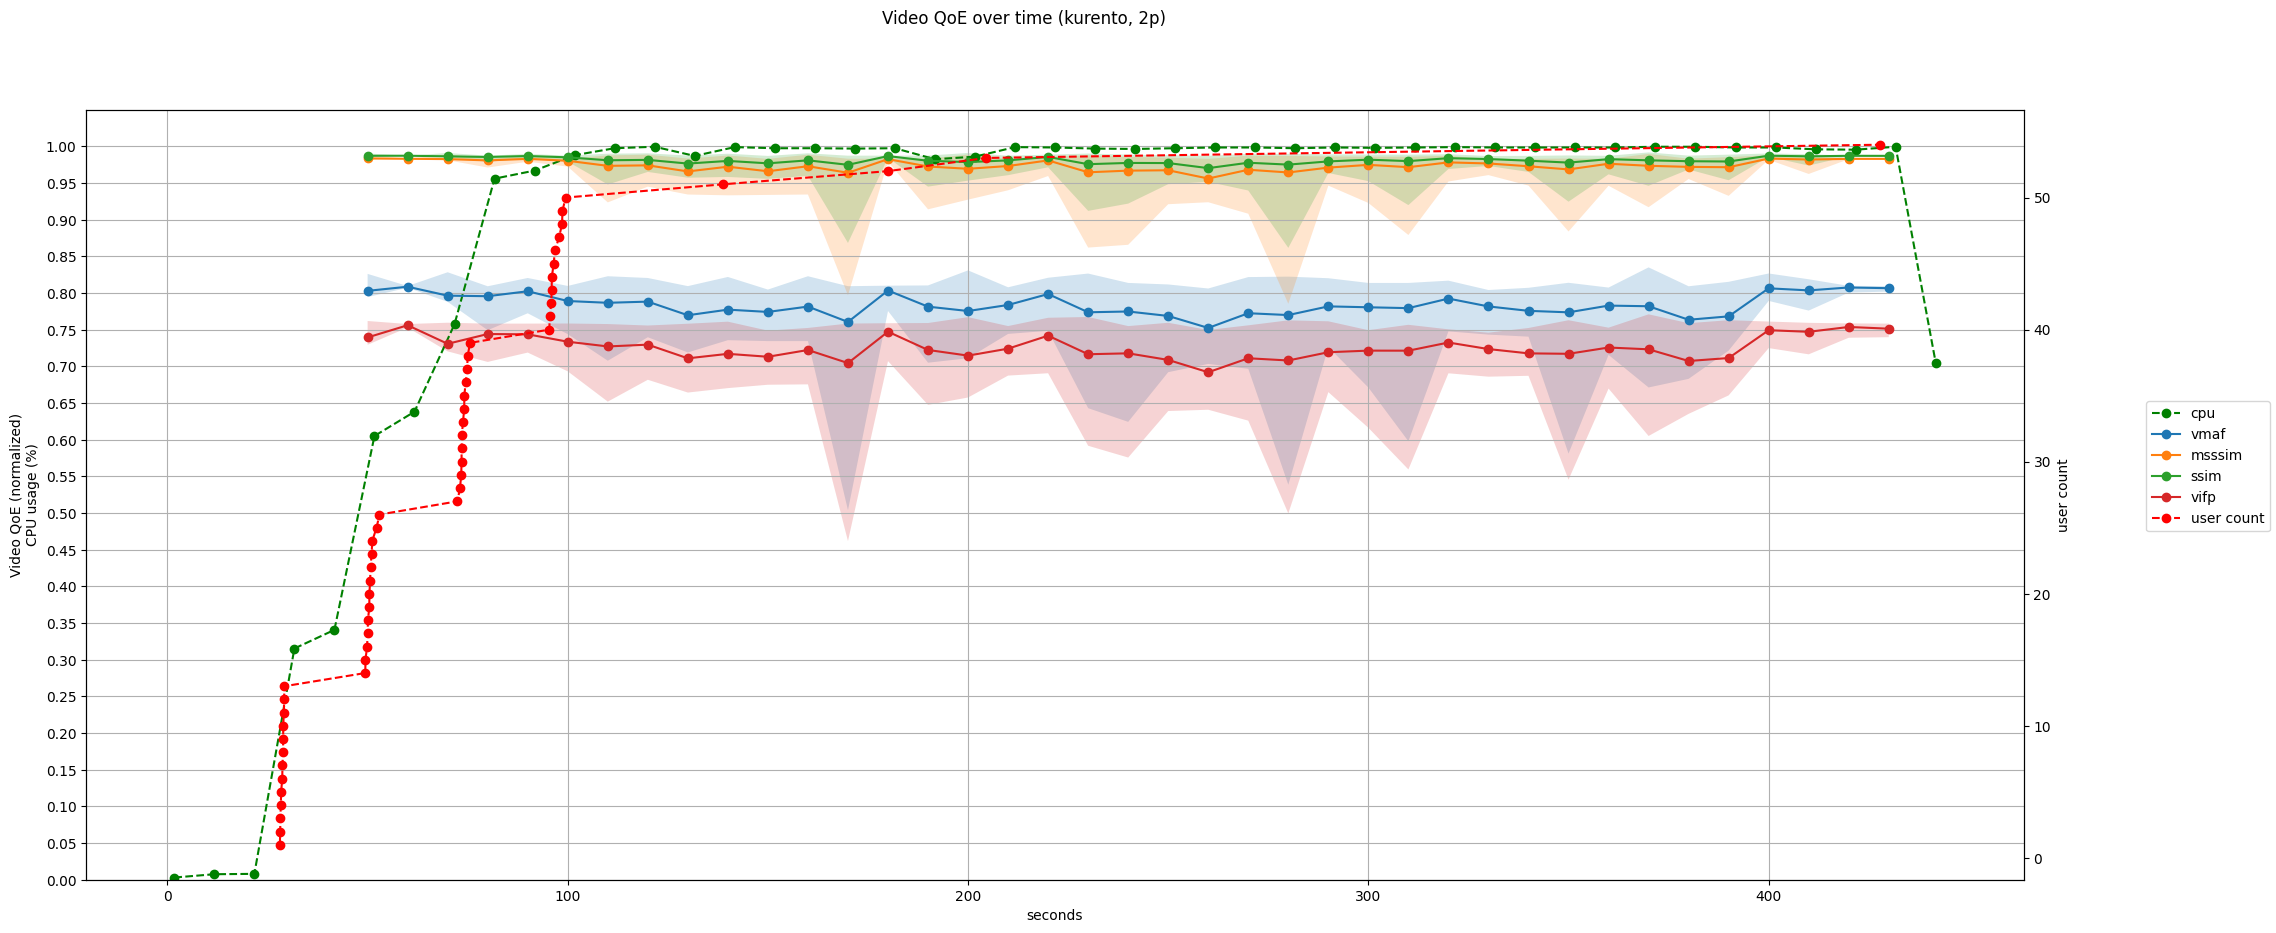

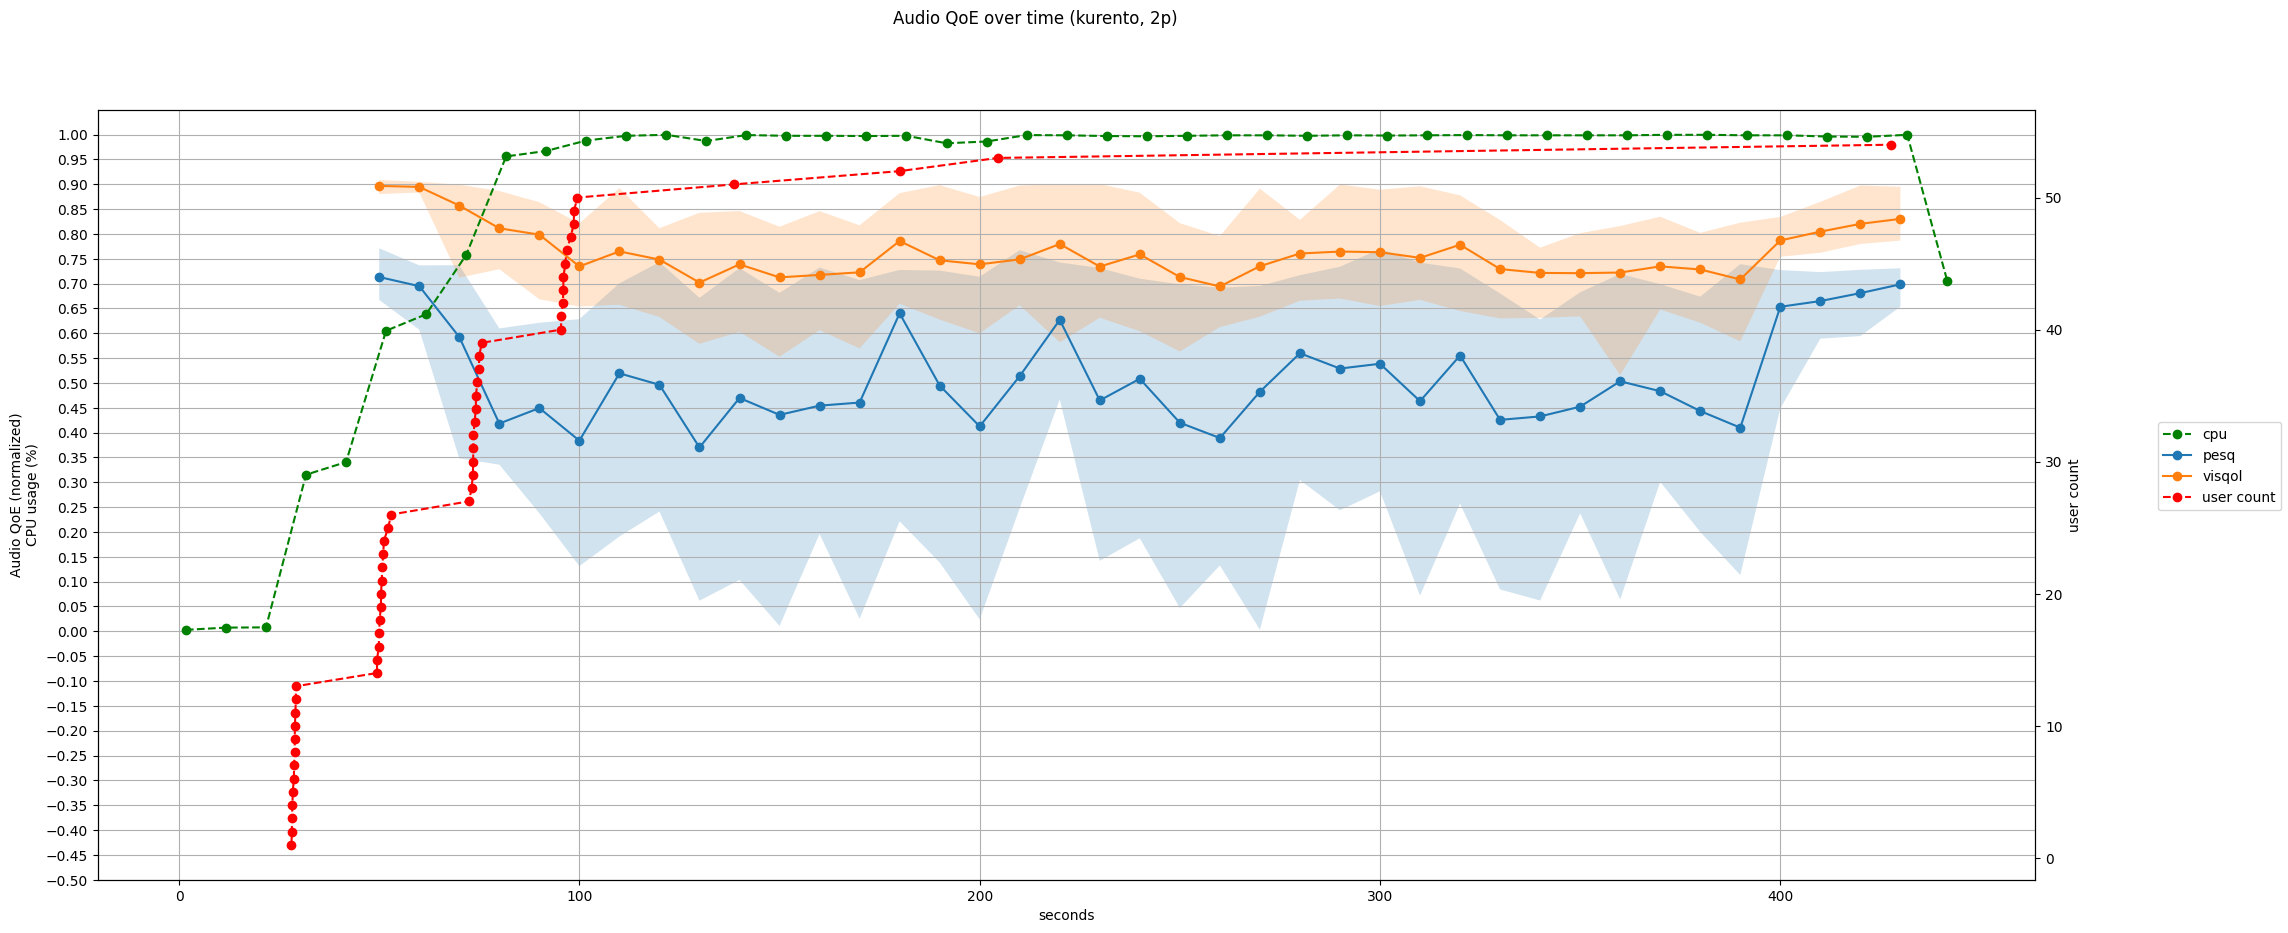

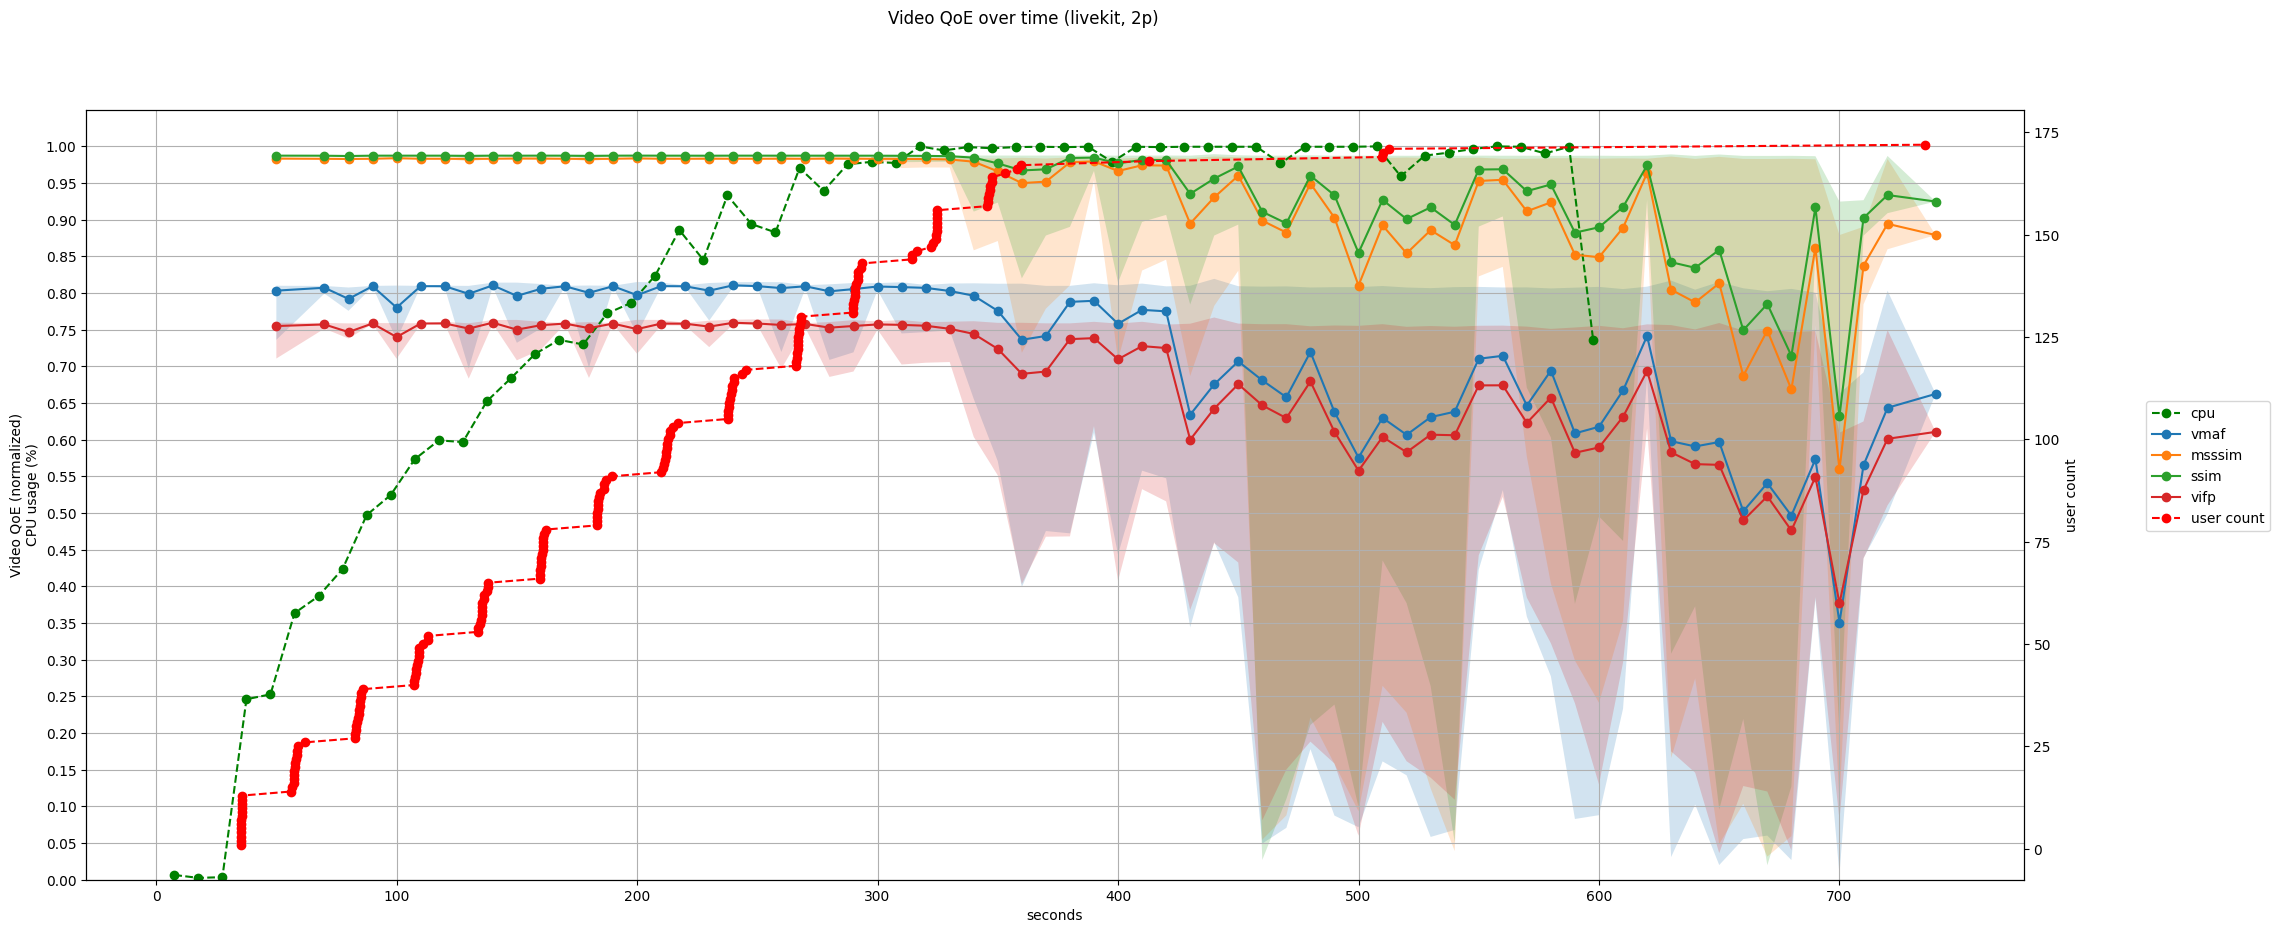

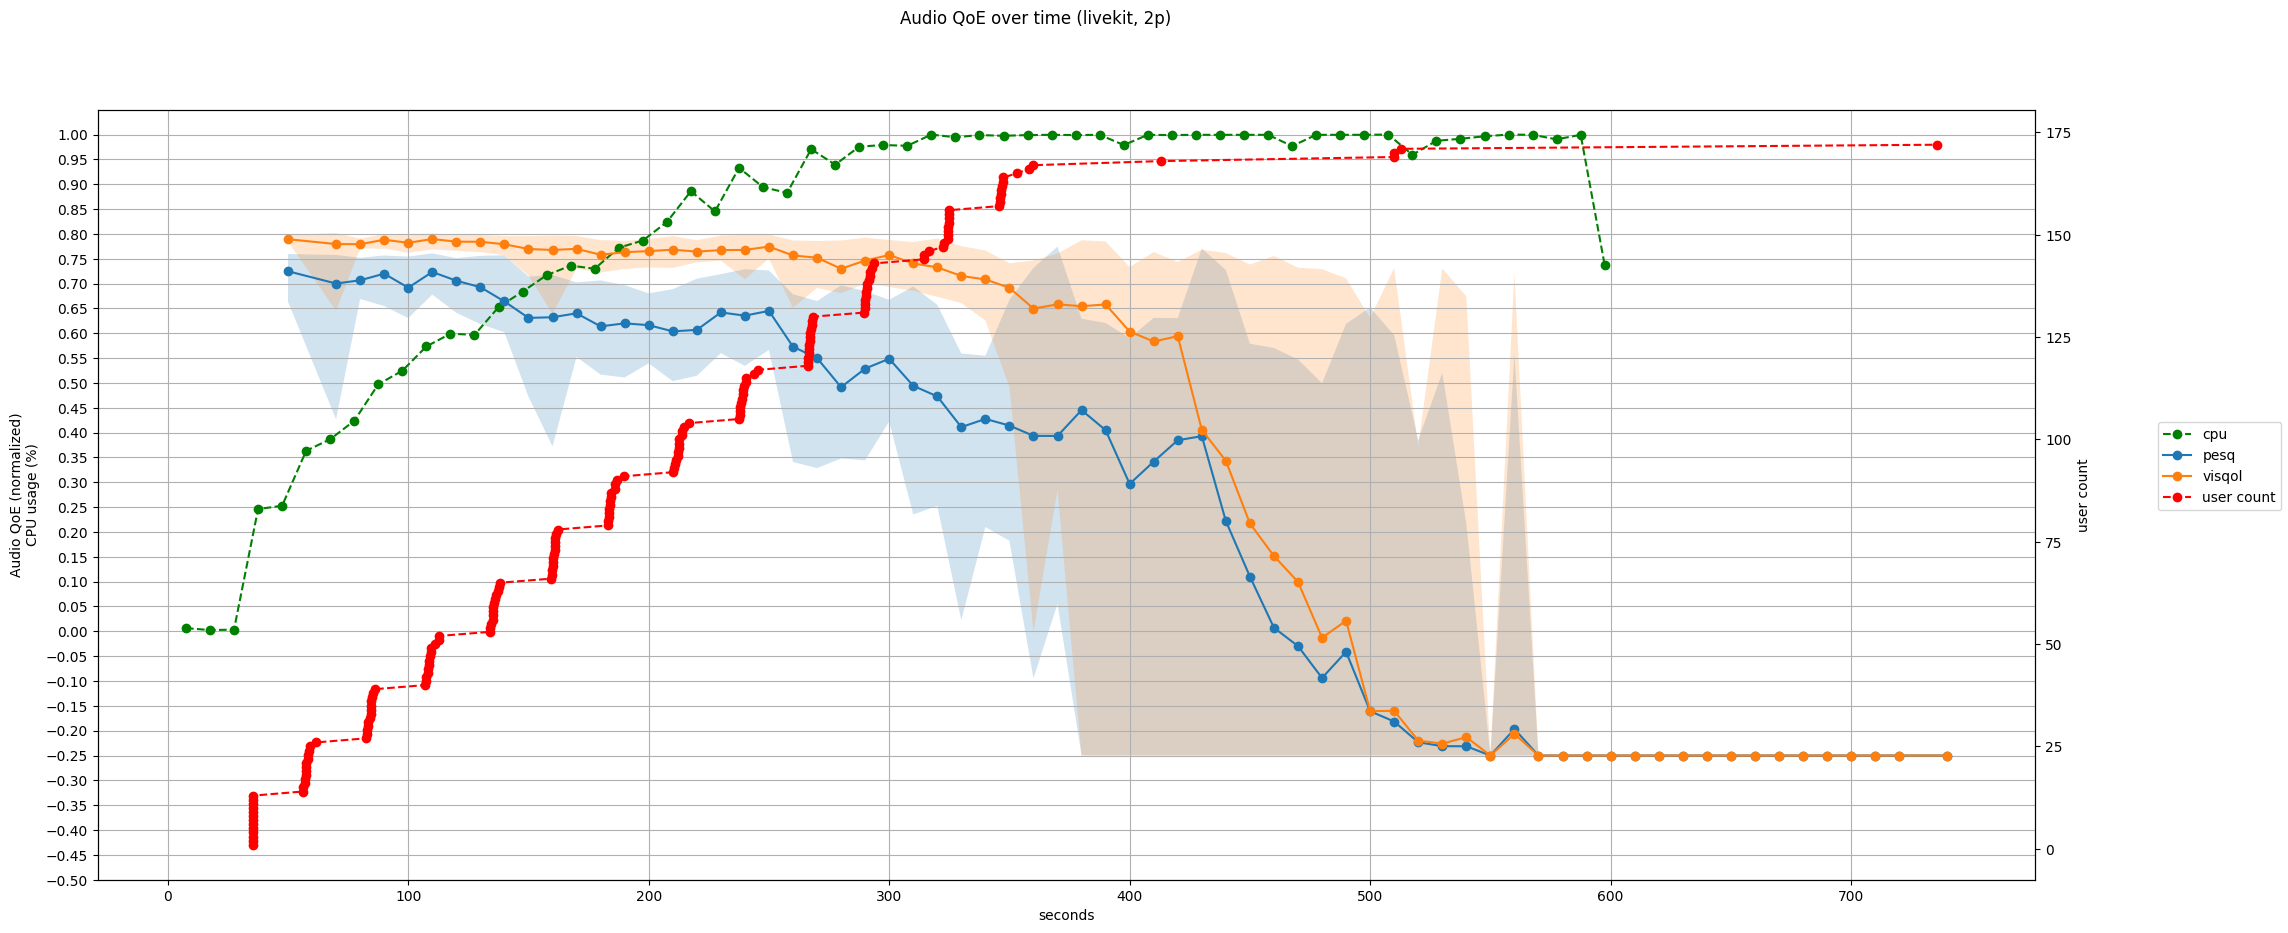

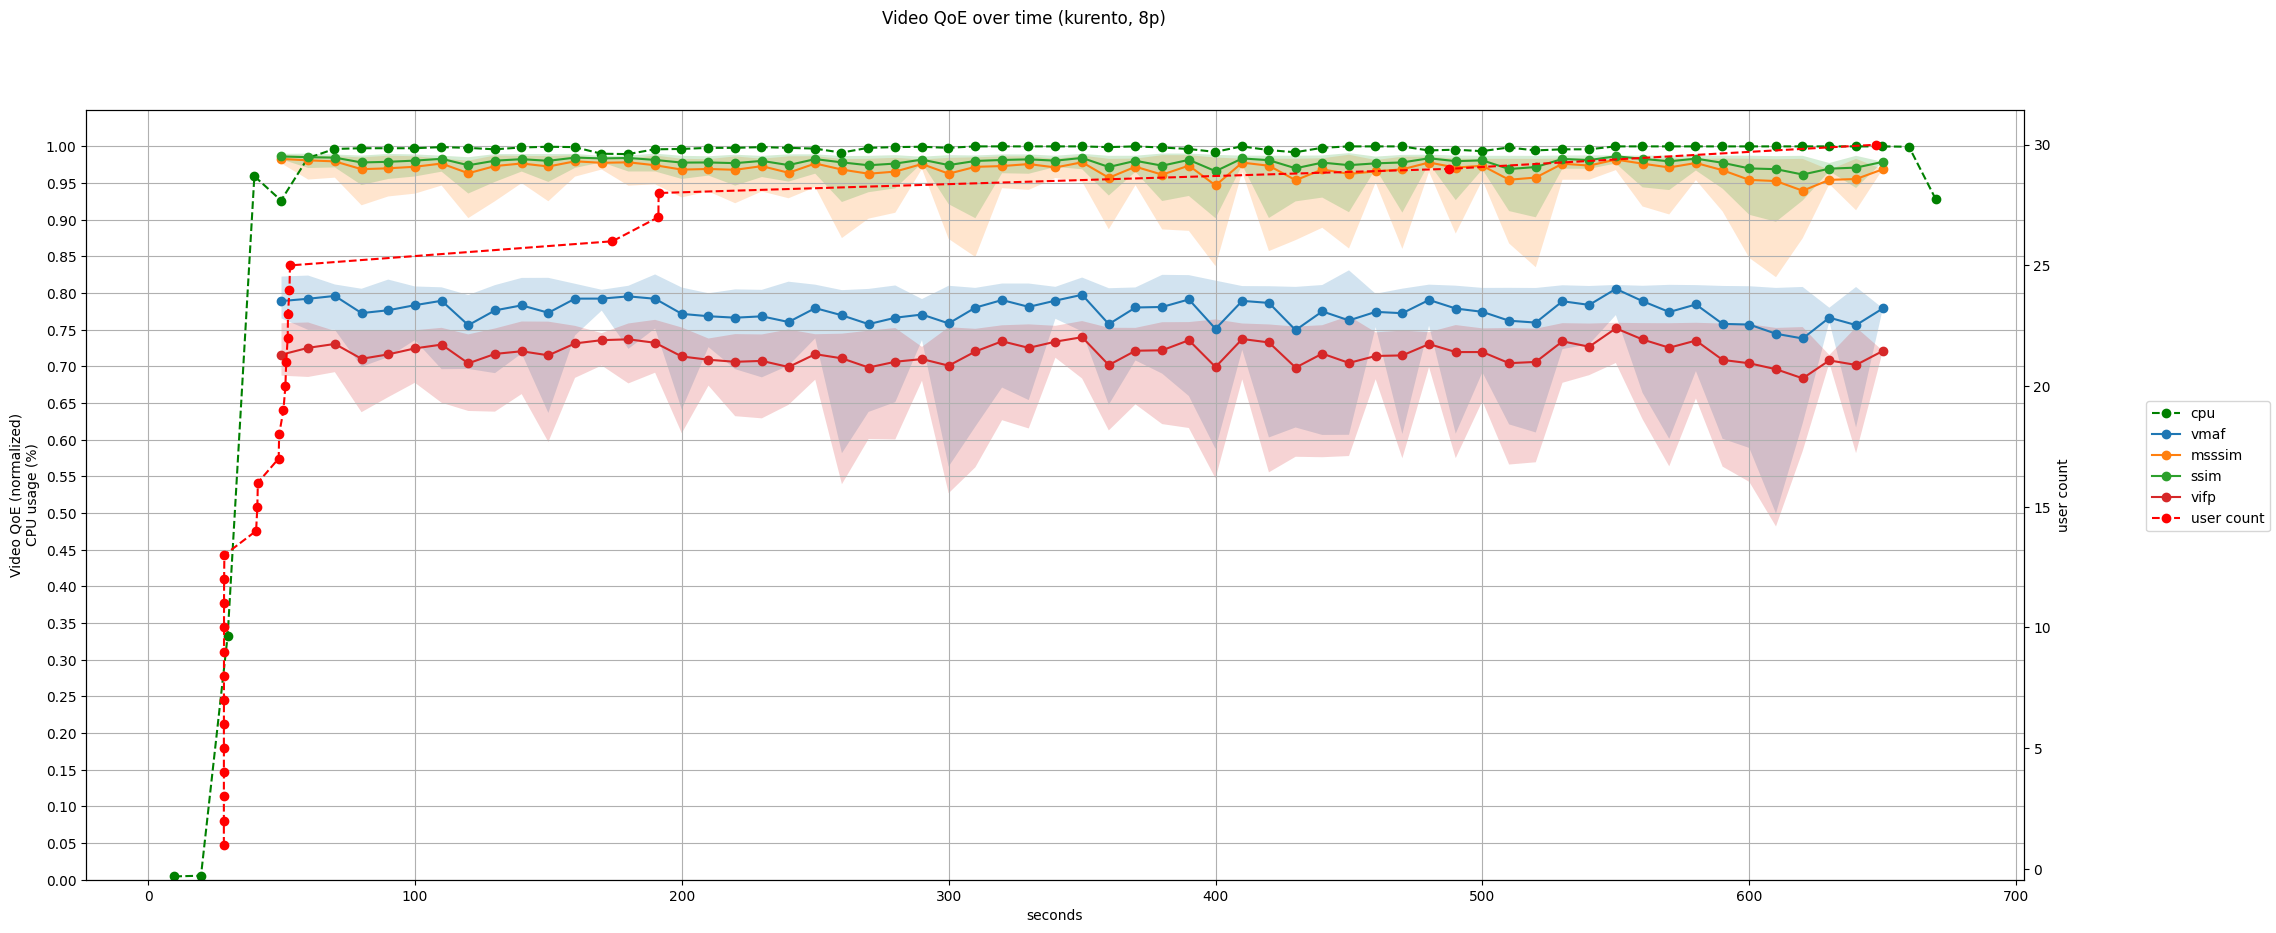

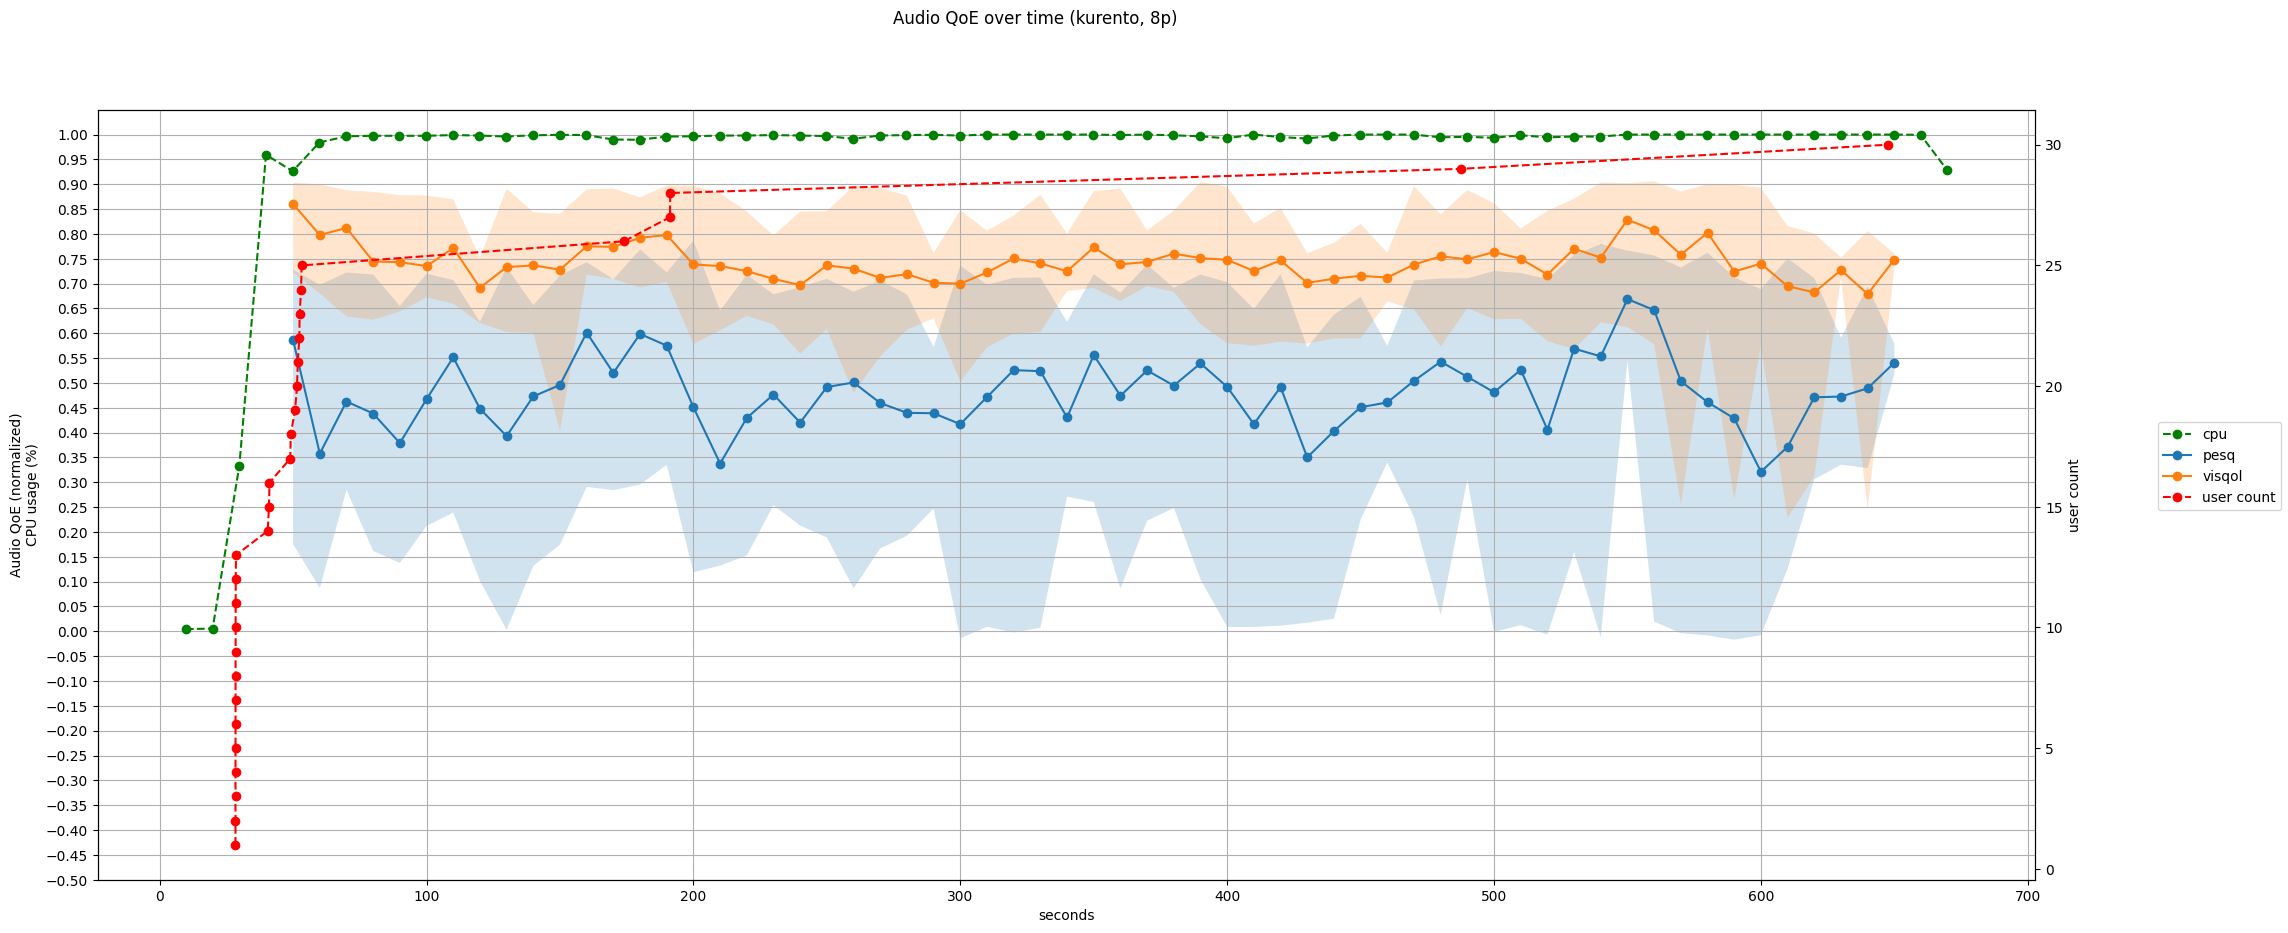

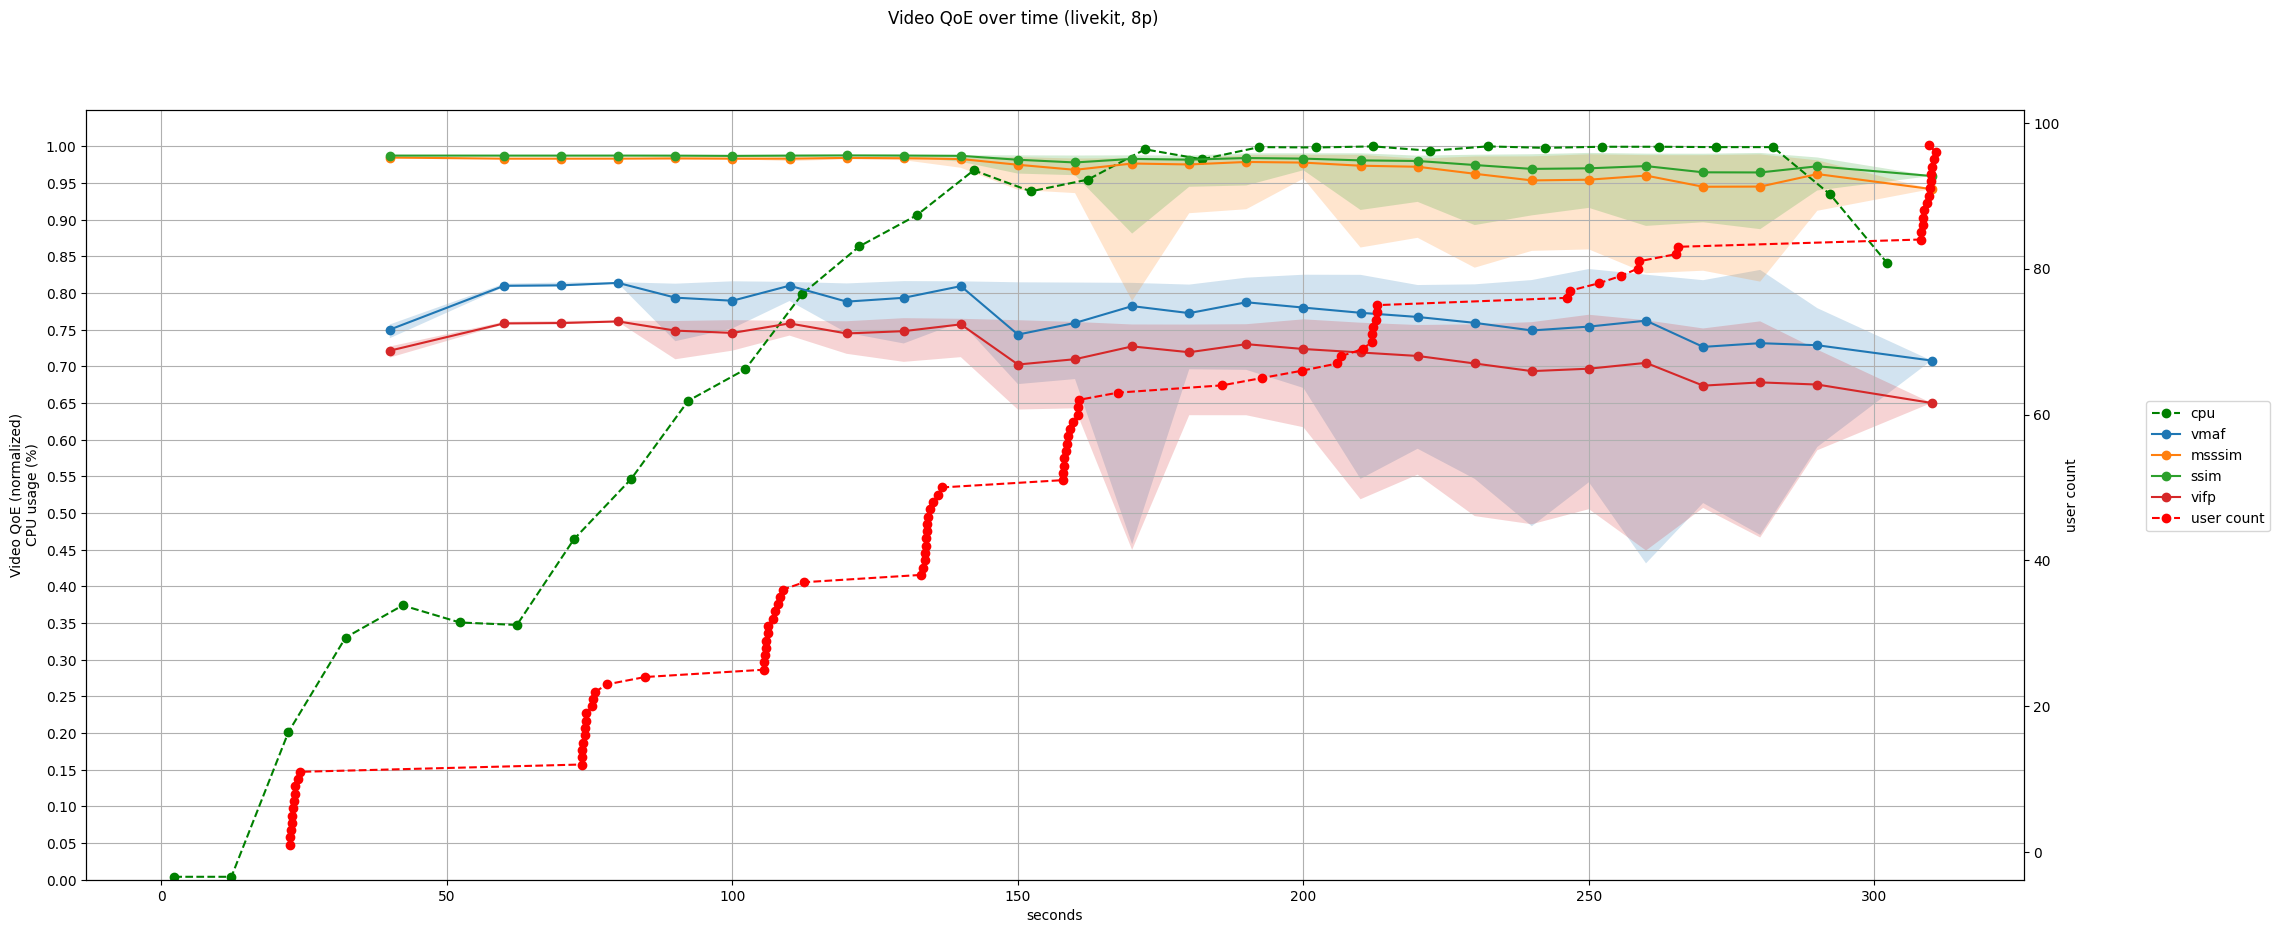

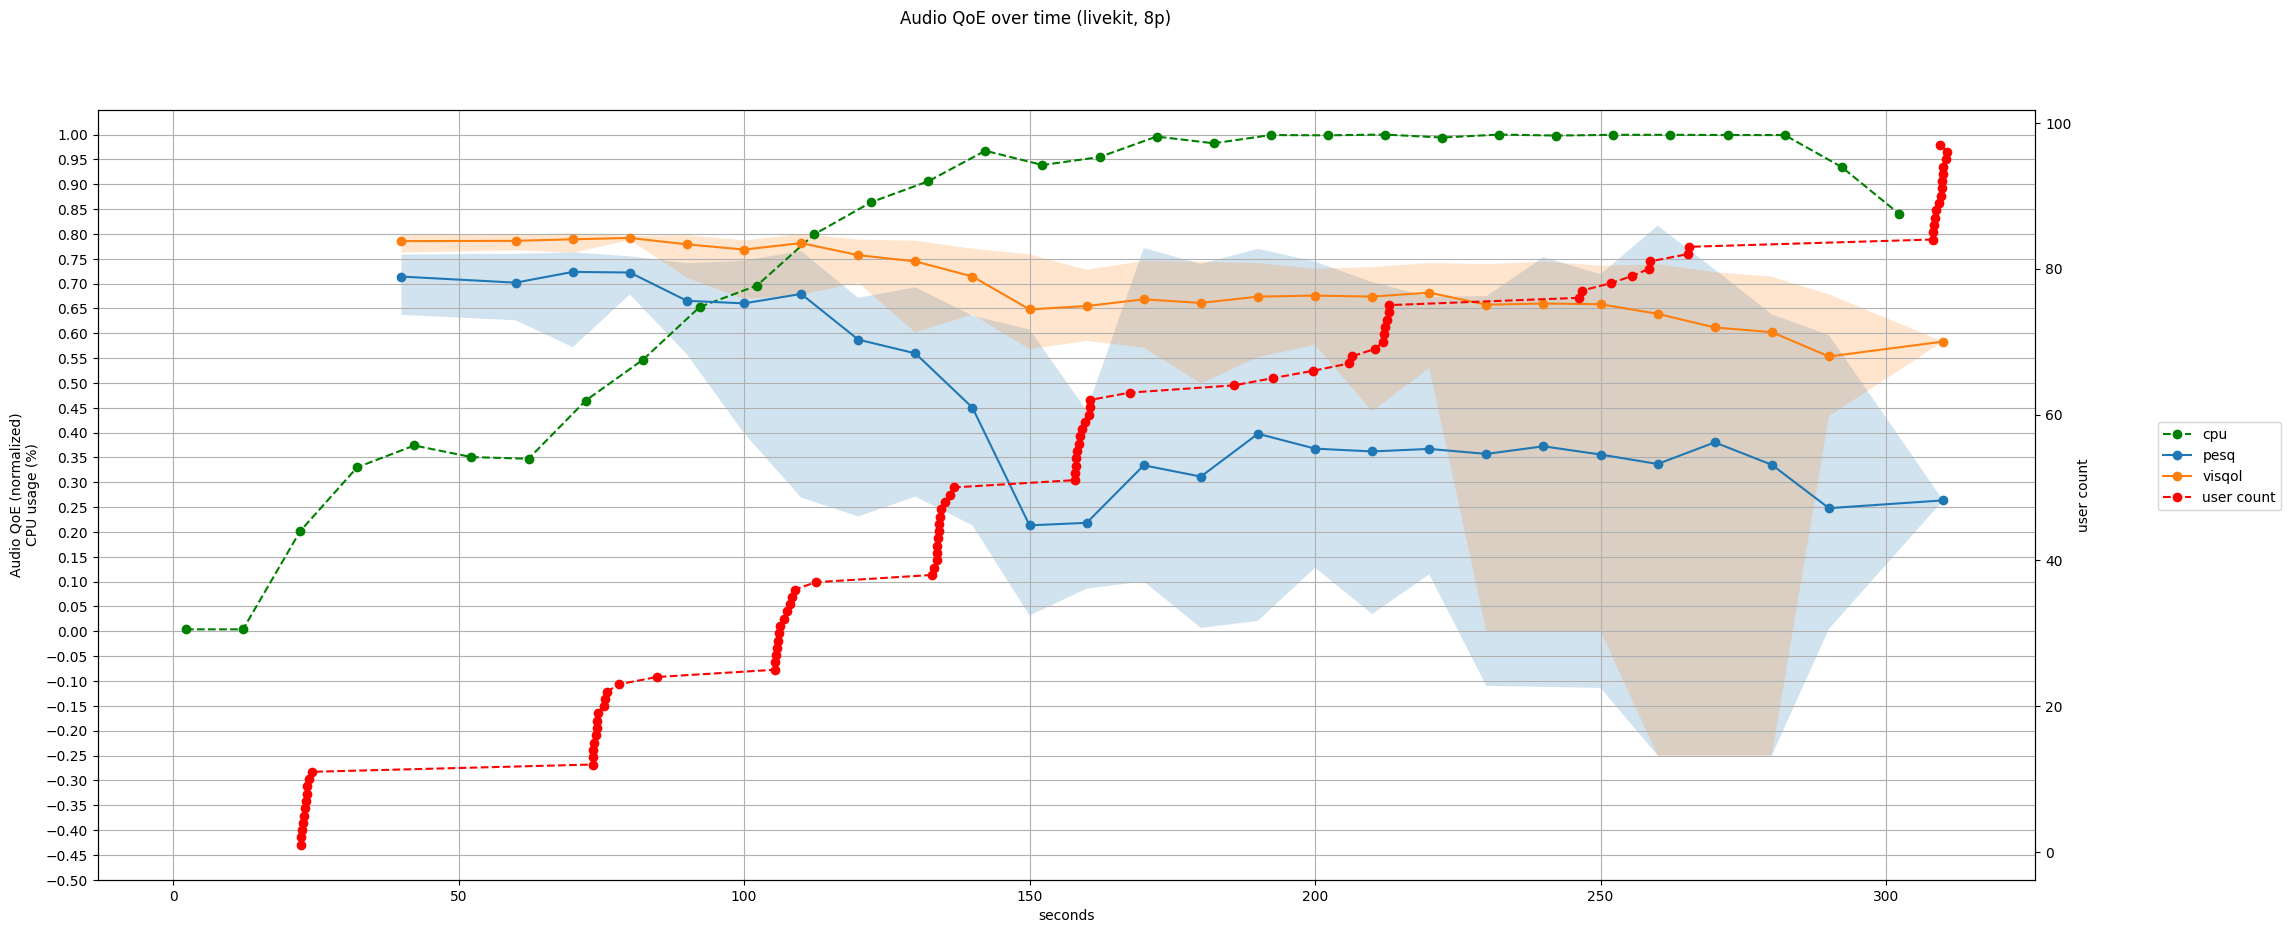

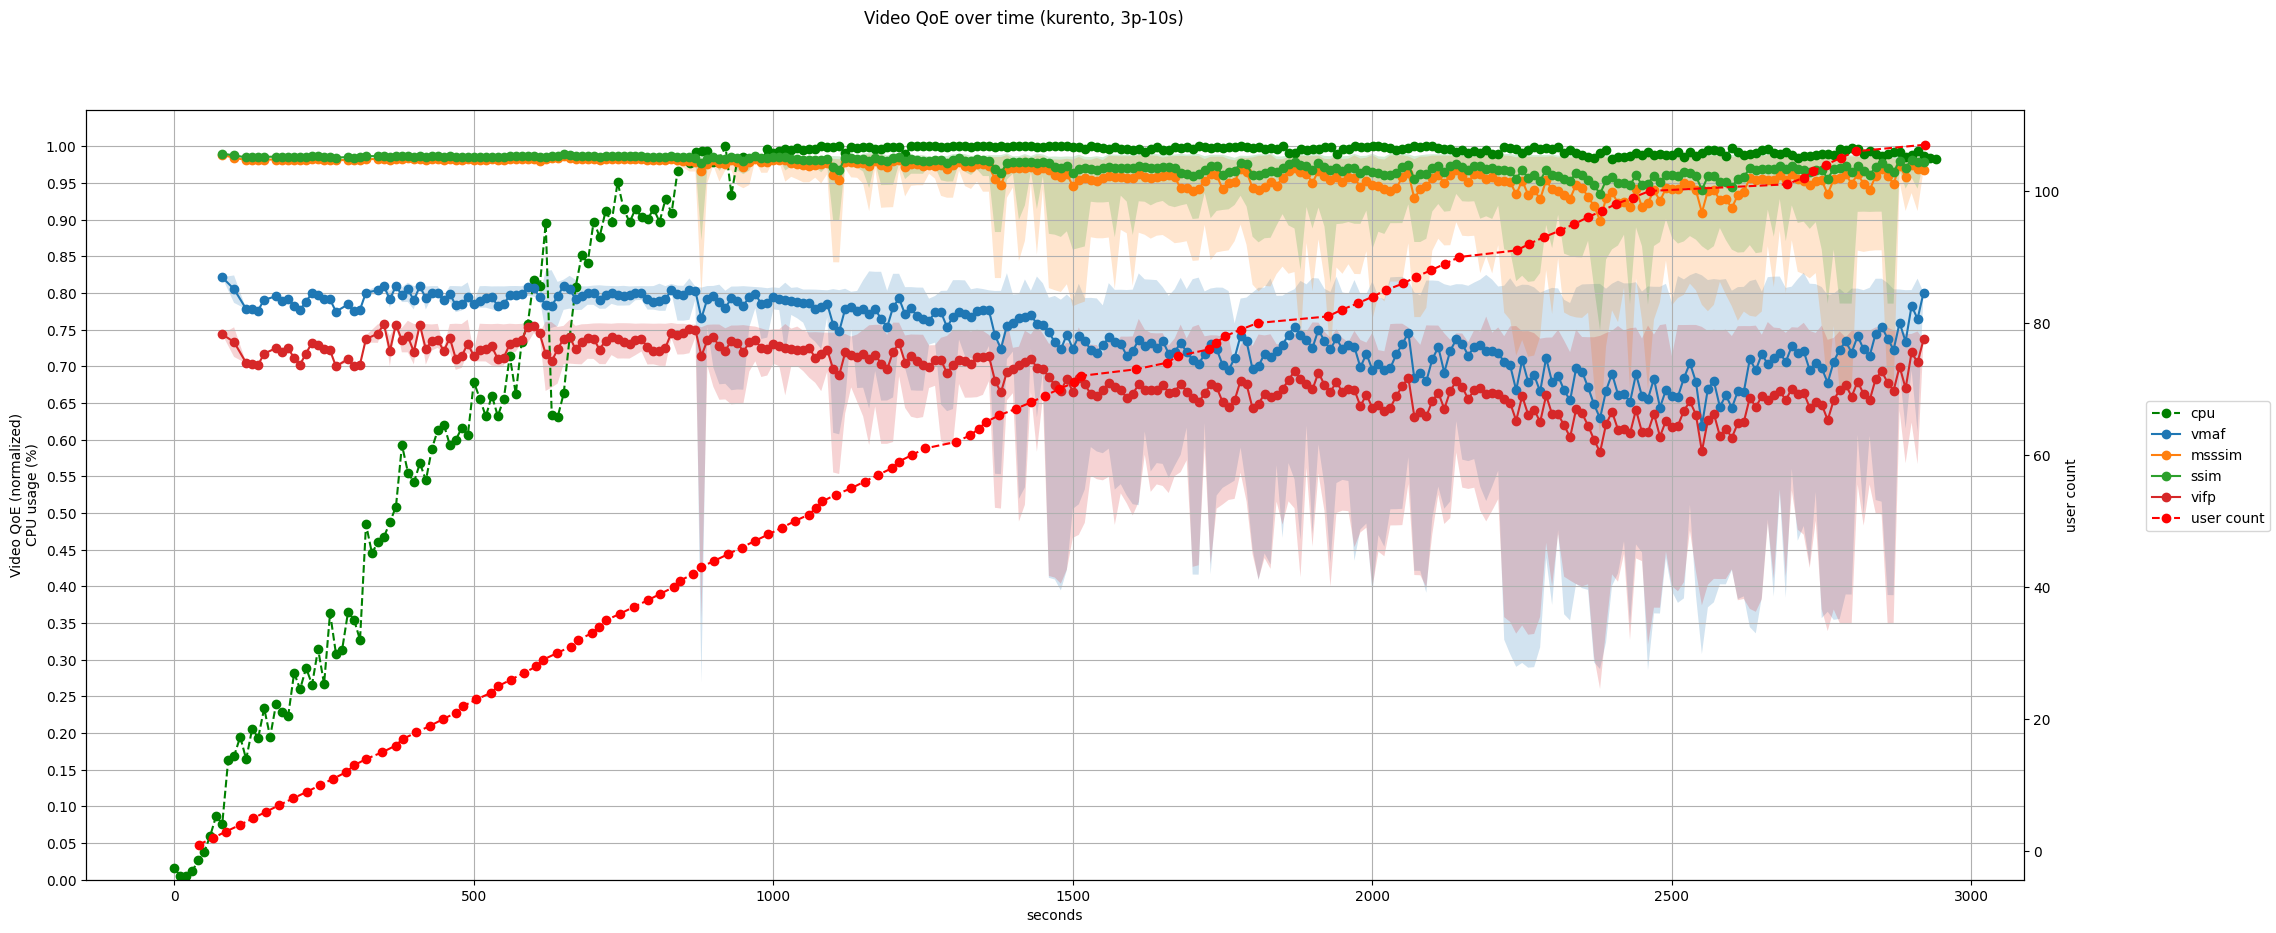

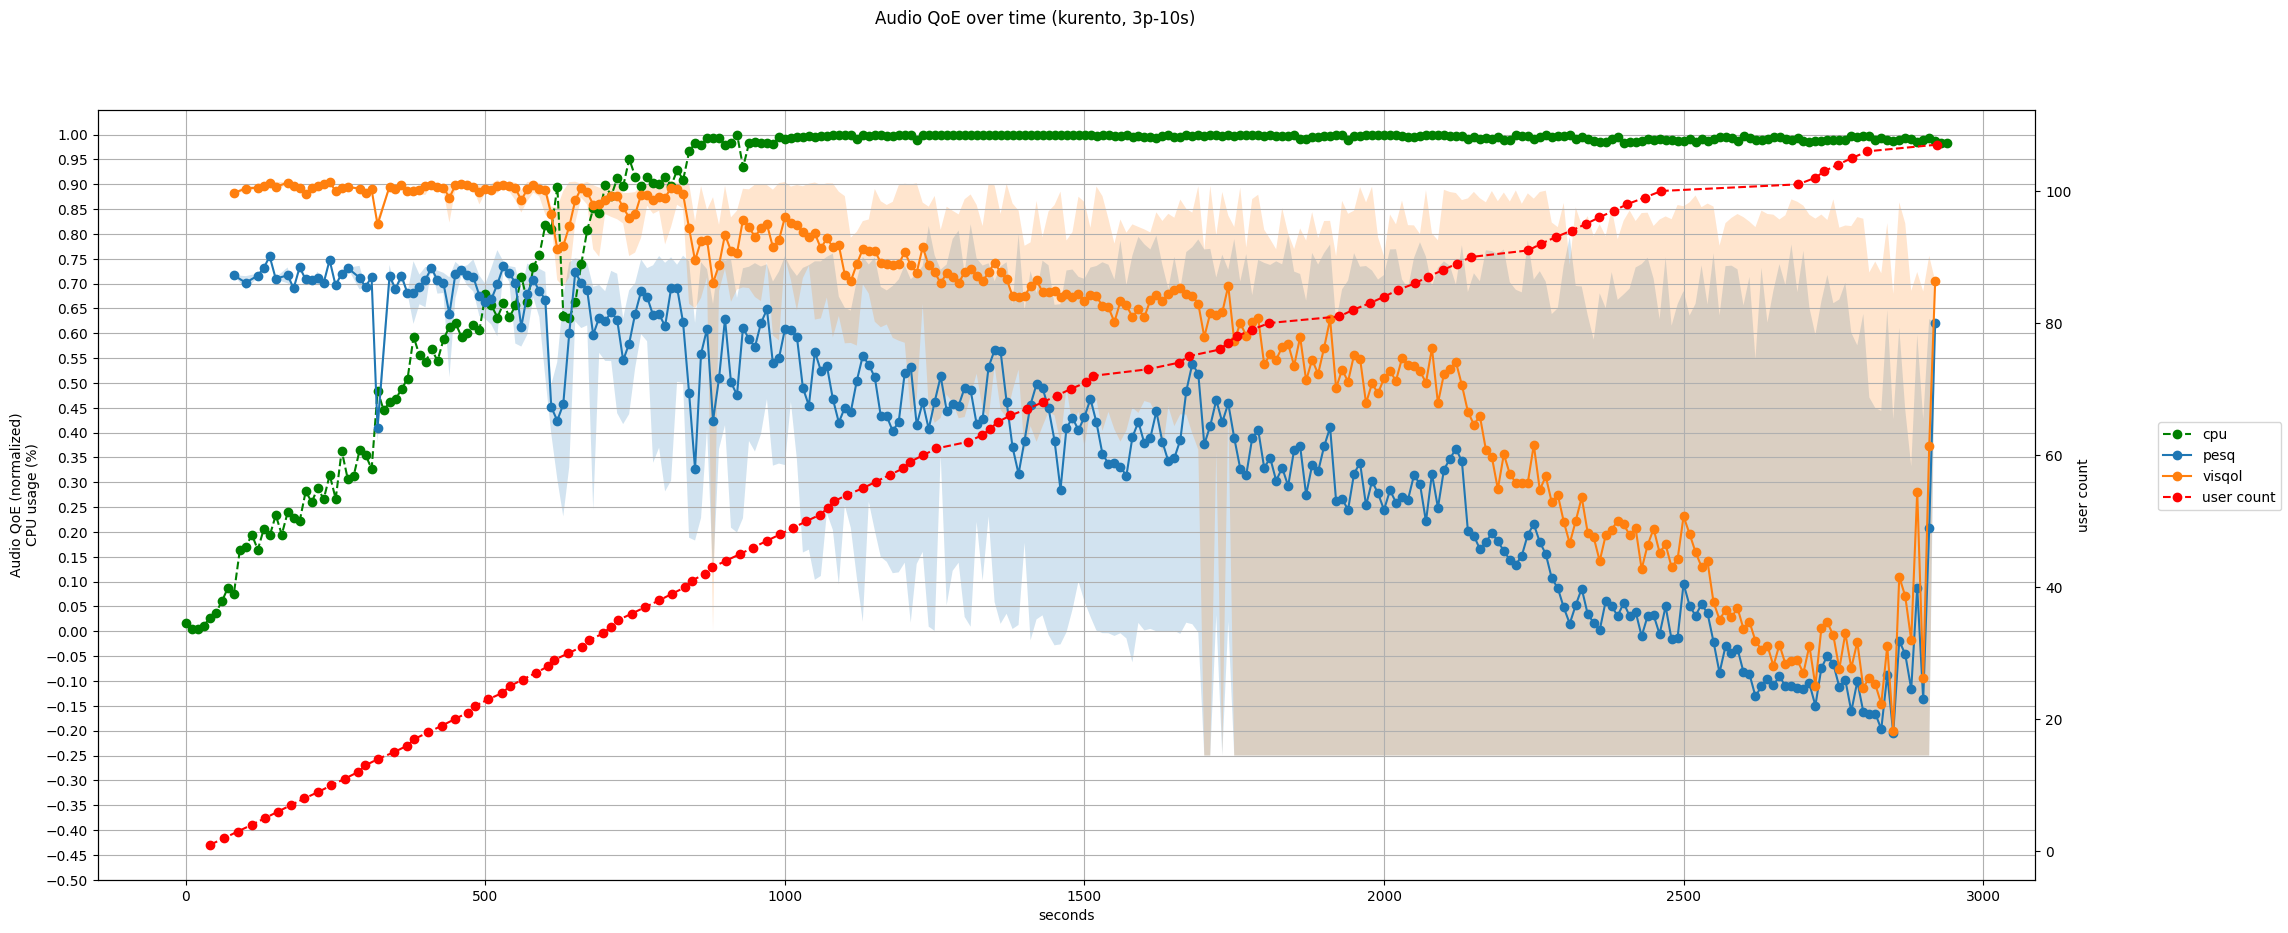

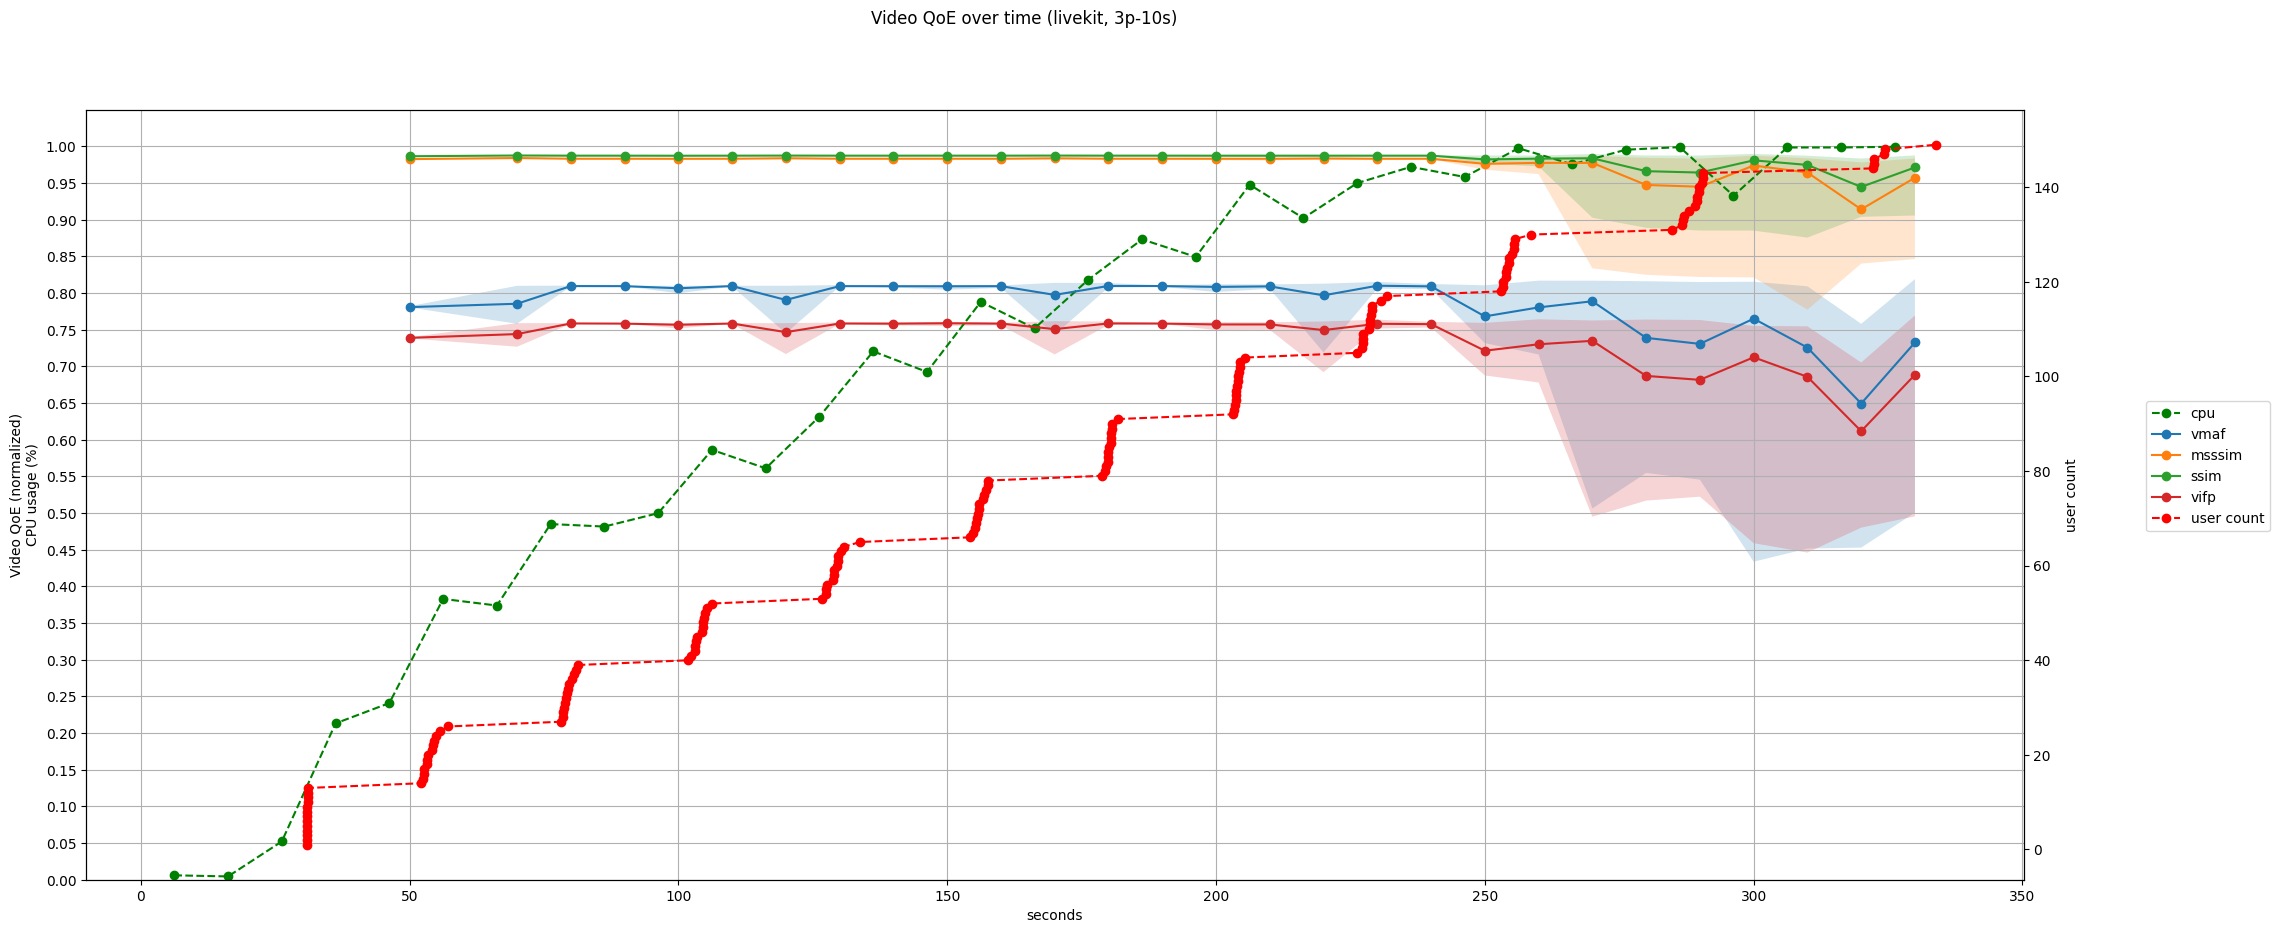

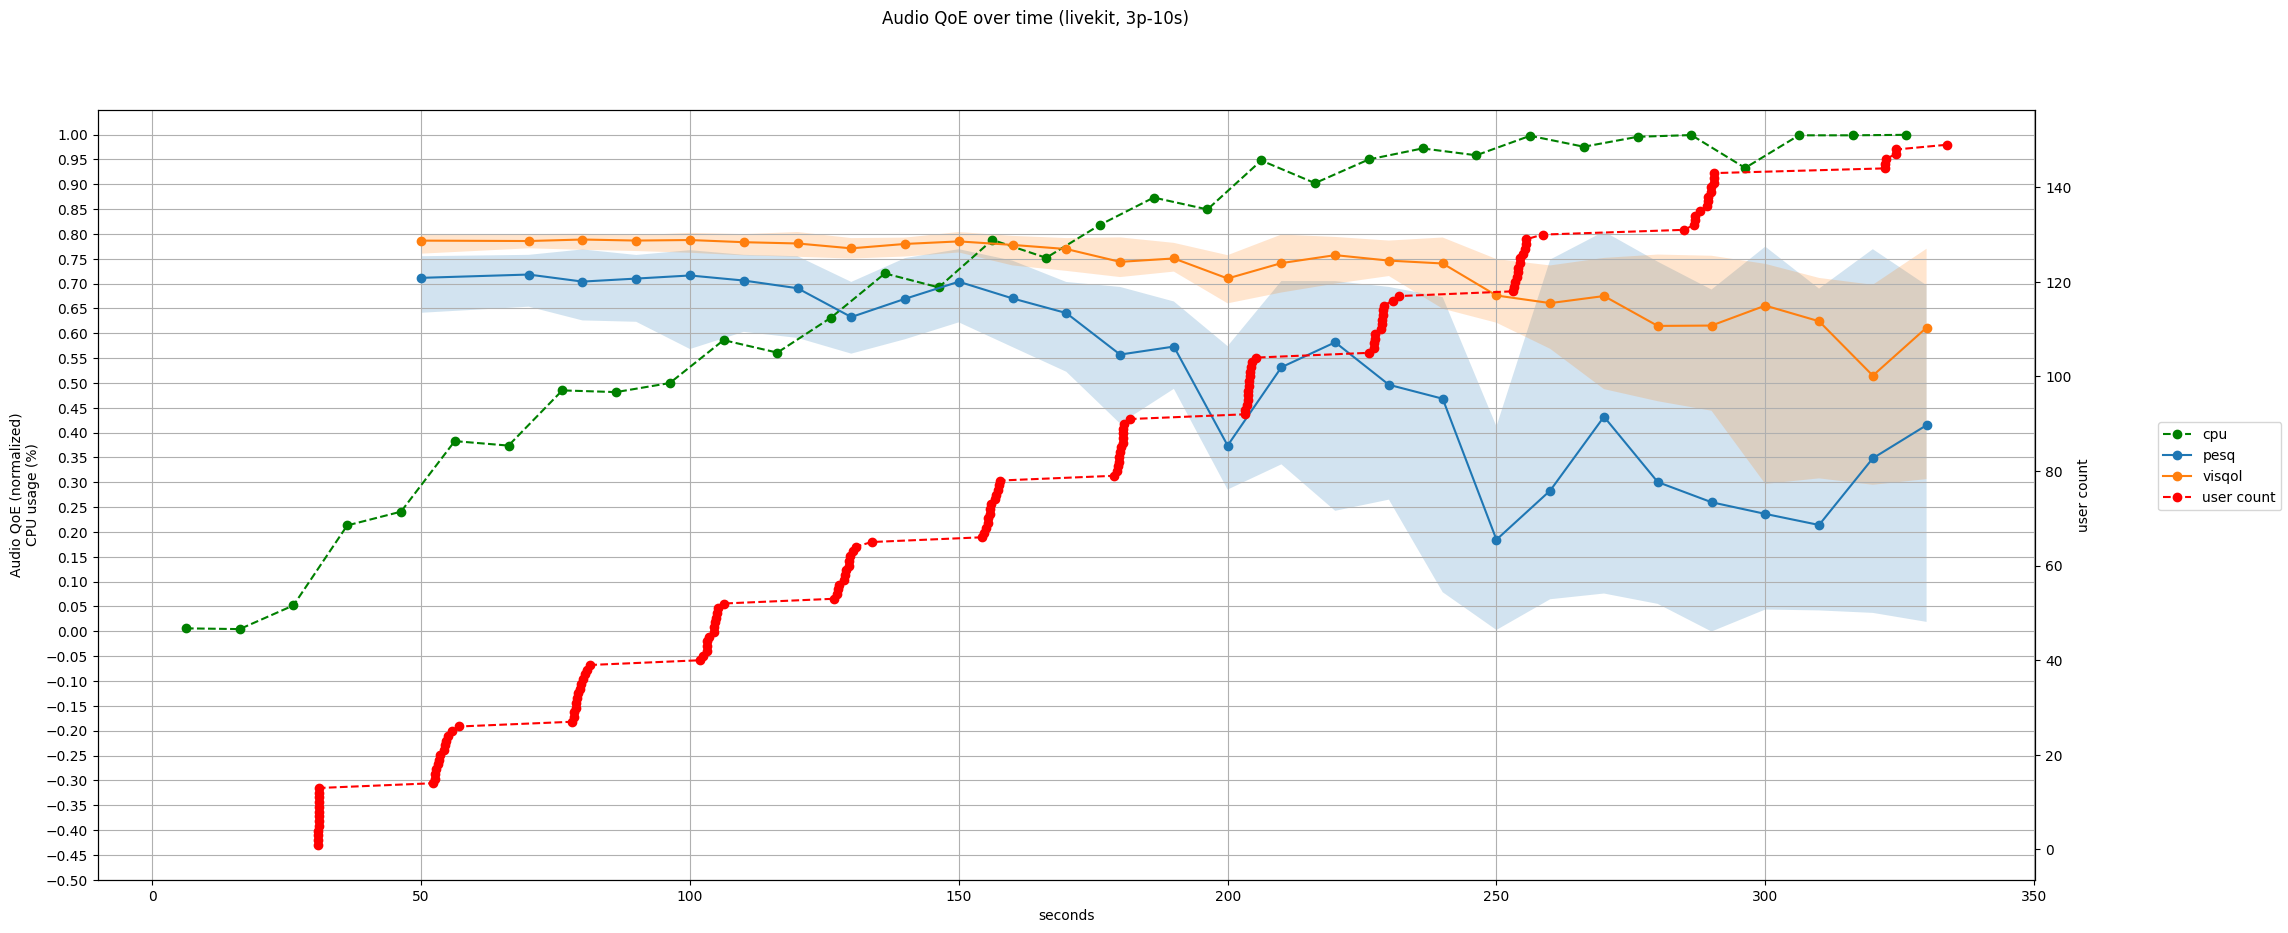

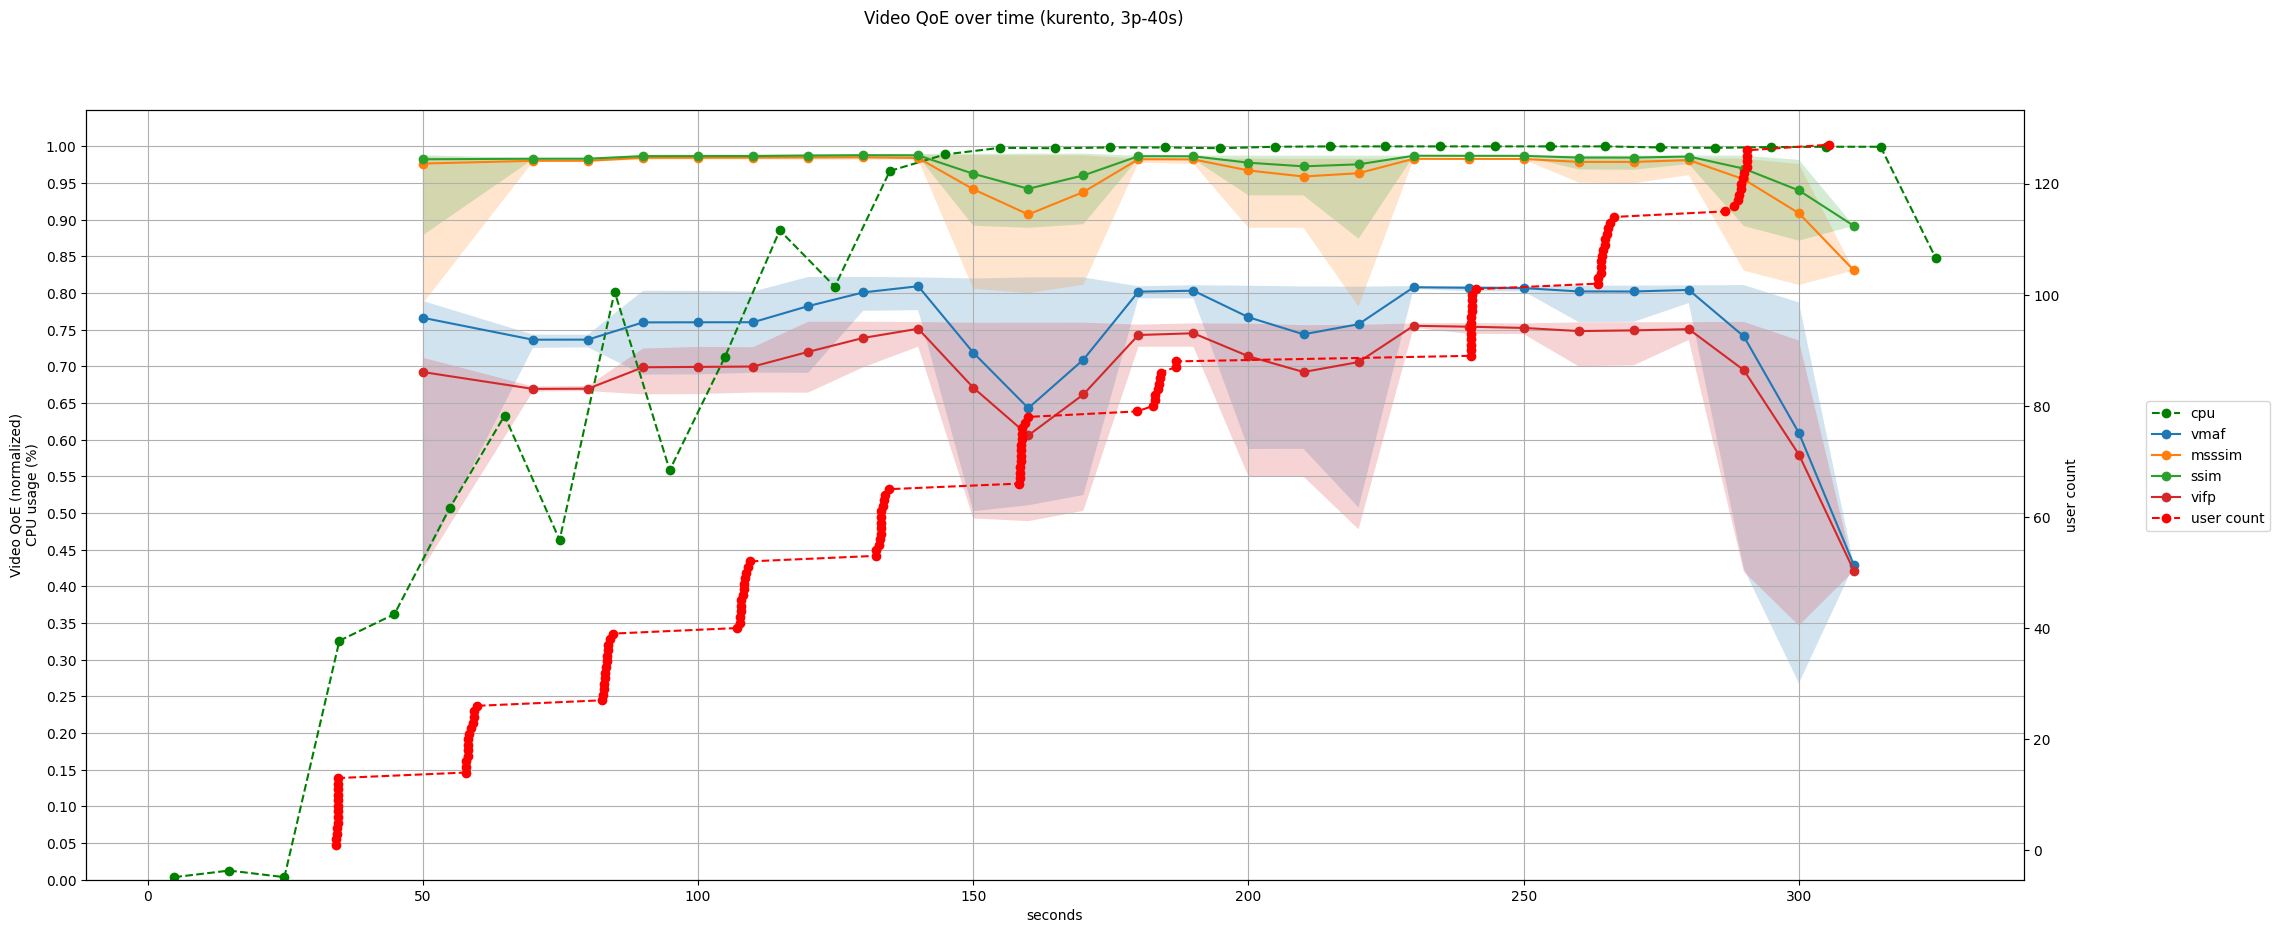

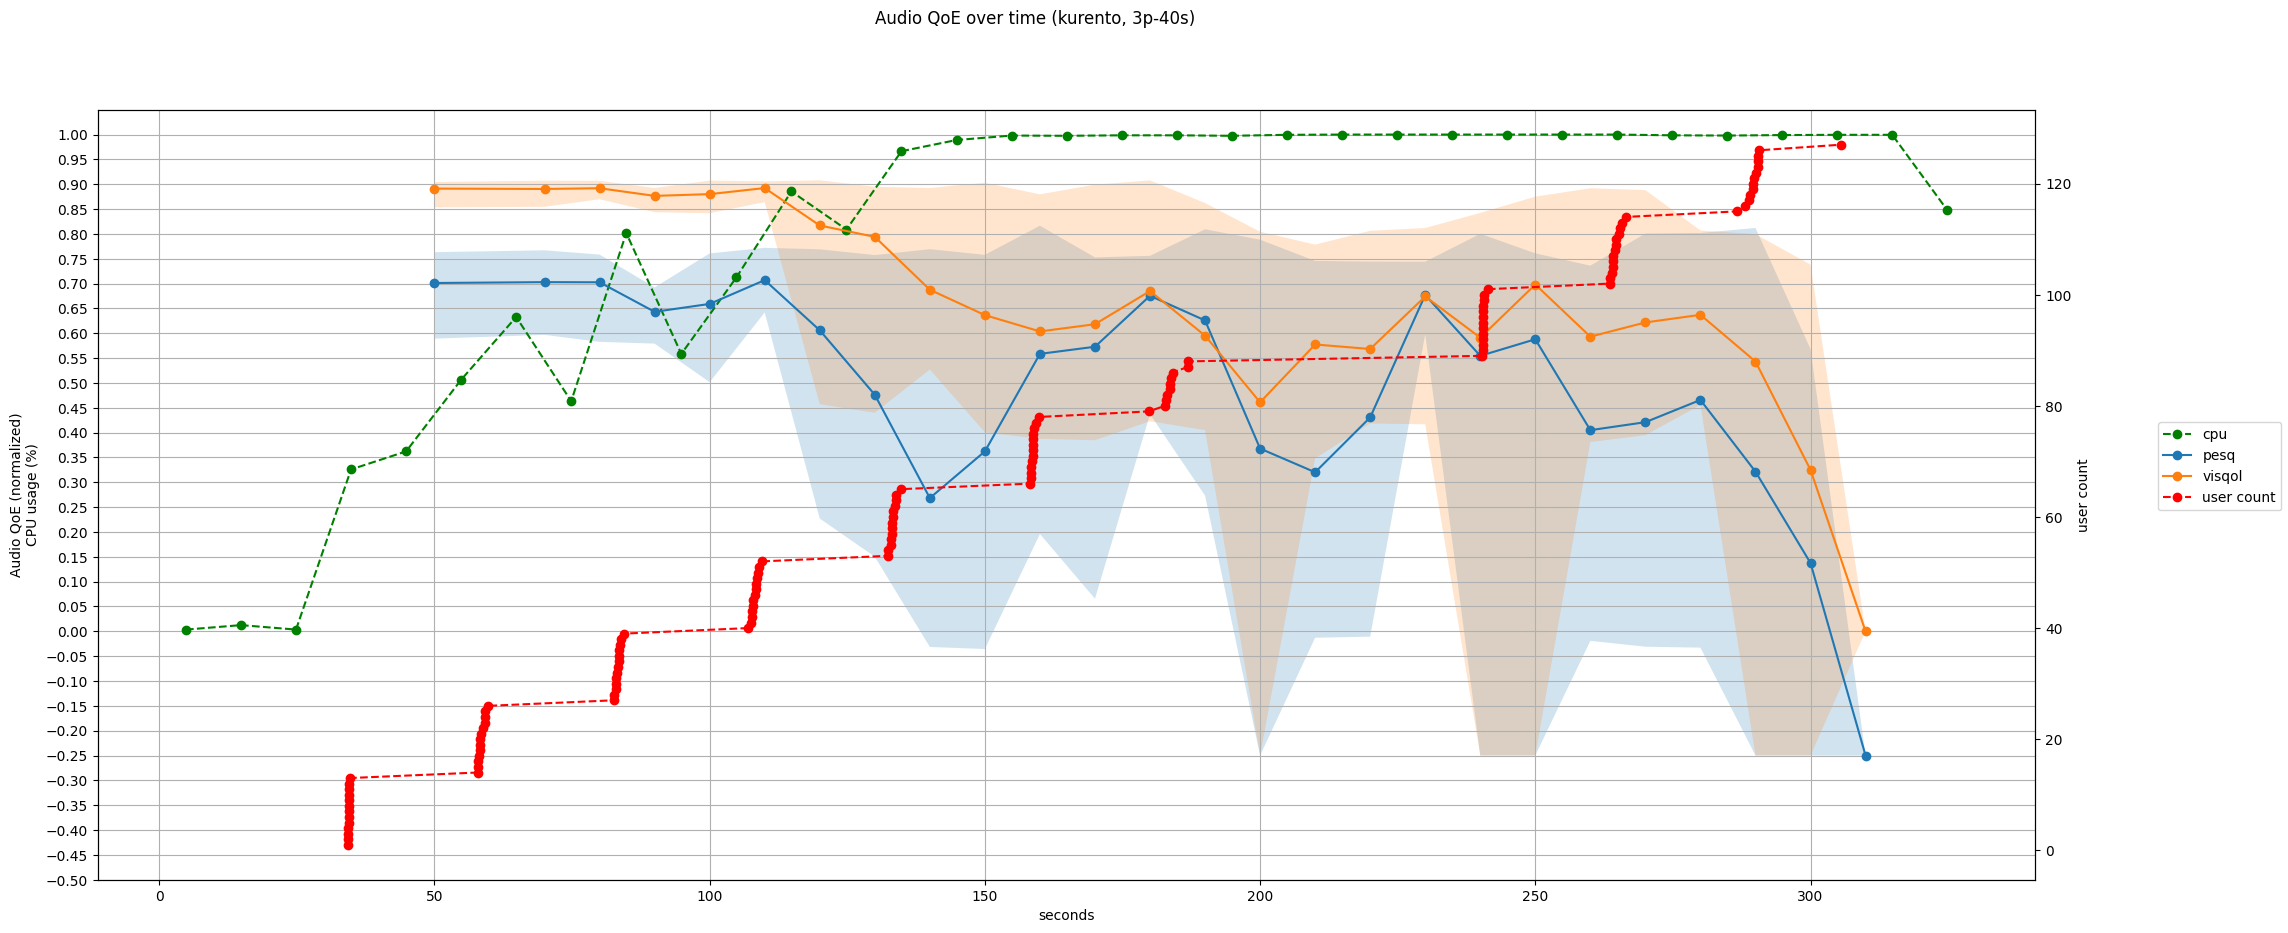

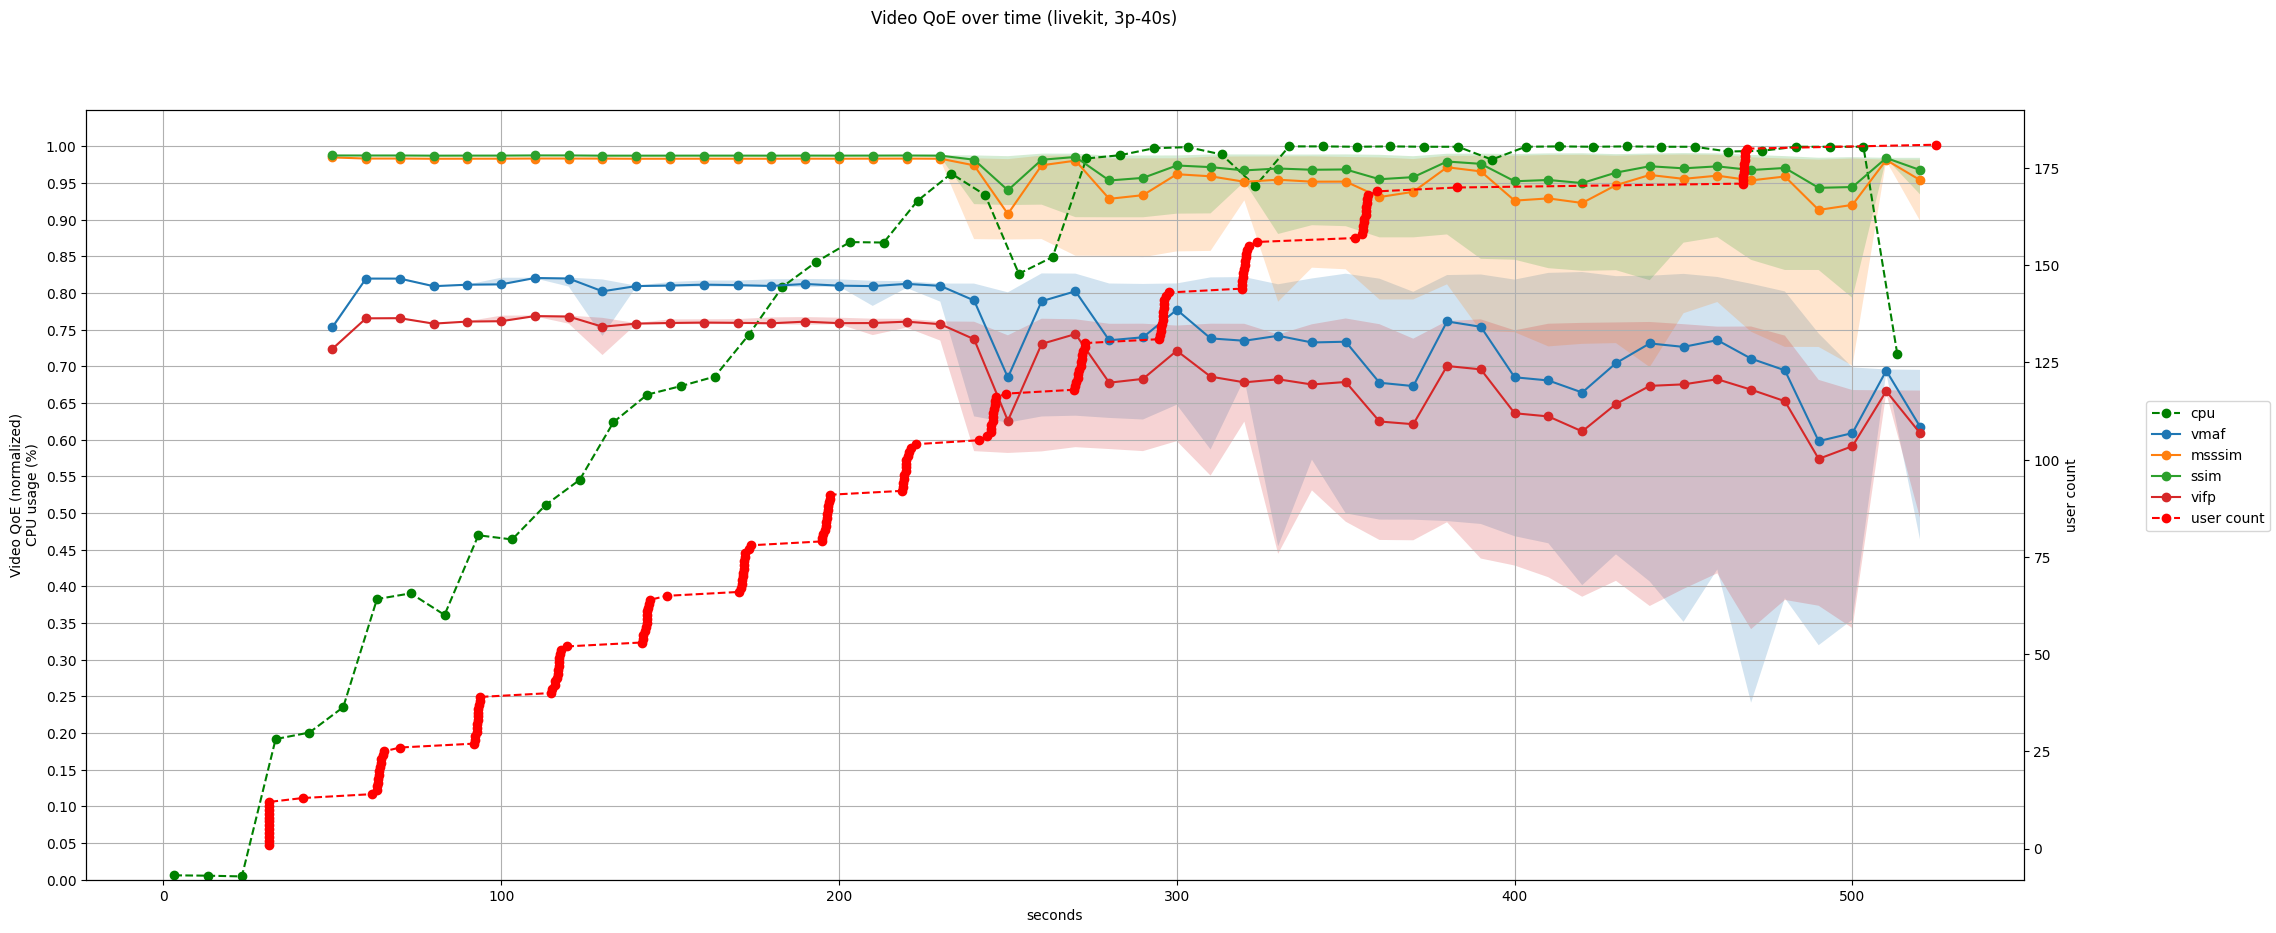

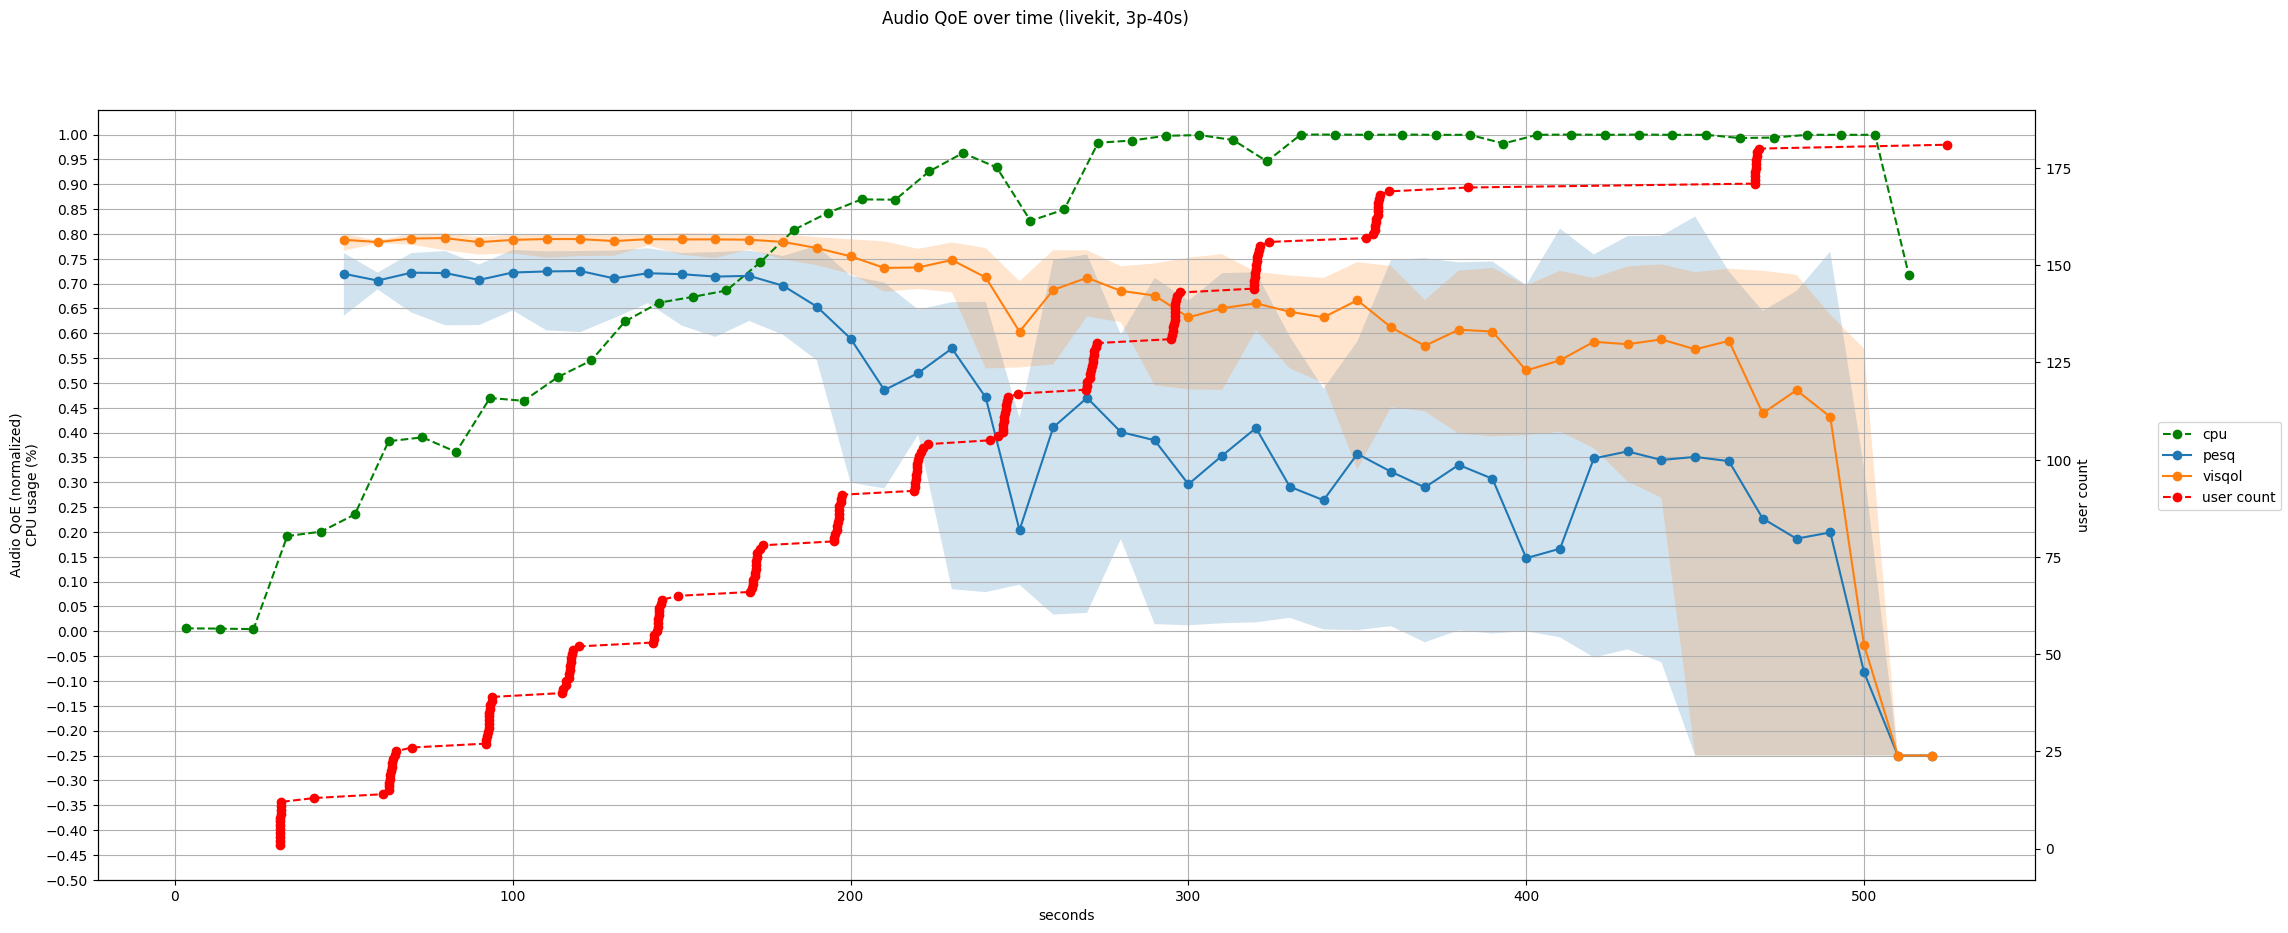

In [13]:
plt.rcParams["figure.figsize"] = [25, 10]
typologies = ["2p", "8p", "3p-10s", "3p-40s"]
media_nodes = ["kurento", "livekit"]
colors = ["blue", "red"]
for typology in typologies:
    for media_node in media_nodes:
        figV, axV = plt.subplots()
        figA, axA = plt.subplots()
        target_names = filter(
            lambda x: typology in x and media_node in x and "retry" in x, index_list_names
        )
        #max_x = -1
        for i, target_name in enumerate(target_names):
            df_tmp = df_list[index_list_names.index(target_name)].copy()
            #df_tmp = pd.read_csv(f"dfs_final/{target_name}.csv")
            user_join = pd.read_csv(f"dfs_final/{target_name}-user-join.csv")
            cpu_mem = pd.read_csv(f"dfs_final/{target_name}-medianode.csv")
            user_join = timestamp_to_secs(user_join, target_name)
            cpu_mem = timestamp_to_secs(cpu_mem, target_name)
            cpu_mem = cpu_mem.drop(columns=["@timestamp", "memory"]).dropna()
            # remove entries with cpu < 0.001
            # df_node = df_node[df_node["cpu"] > 0.001]
            #df_node = timestamp_to_secs(df_node, target_name)
            # aproximate cut_index to the nearest 10 seconds
            max_timestamp = df_tmp["cut_index"].max()
            # if df_tmp["cut_index"].max() > 8000:
            #     #df_tmp["cut_index"] = df_tmp["cut_index"].round(-3)
            # #elif df_tmp["cut_index"].max() > 1000:
            #     #df_tmp["cut_index"] = df_tmp["cut_index"].round(-2)
            # else:
            df_tmp["cut_index"] = df_tmp["cut_index"].round(-1)
            #df_tmp["cut_index"] = df_tmp["cut_index"].apply(lambda x: 5*round(x/5))
            df_mean = df_tmp.groupby(["cut_index"]).mean(numeric_only=True)
            df_max = df_tmp.groupby(["cut_index"]).max(numeric_only=True)
            df_min = df_tmp.groupby(["cut_index"]).min(numeric_only=True)
            # sacar minimo y maximo

            plot_name = target_name
            timestamp_user_values = user_join["timestamp_secs"].values
            # fill the timestamp_user_values with the last value to make the plot continuous

            timestamp_user_values = np.append(timestamp_user_values, max_timestamp)
            count = range(1, len(timestamp_user_values) + 1)
            if i == 0:
                ax2V = axV.twinx()
                ax2V.plot(timestamp_user_values, count, color="red", label="user count", linestyle="--", marker="o")
                ax2V.set_ylabel("user count")
                #ax3 = ax.twinx()
                axV.plot(cpu_mem["timestamp_secs"], cpu_mem["cpu"], color="green", label="cpu", linestyle="--", marker="o")
                #ax2.set_ylabel("cpu")
                ax2A = axA.twinx()
                ax2A.plot(timestamp_user_values, count, color="red", label="user count", linestyle="--", marker="o")
                ax2A.set_ylabel("user count")
                axA.plot(cpu_mem["timestamp_secs"], cpu_mem["cpu"], color="green", label="cpu", linestyle="--", marker="o")


            if not df_mean.empty:
                for metric in qoe_metrics_normalized:
                    # TODO: Probar usando eje X user_count
                    # TODO: Calcular media y std
                    # TODO: Cuanto tarda en meterse X numero de usuarios en un media server
                    # TODO: Tiempo de conexión vs número de usuarios (a lo mejor meter CPU)
                    if not (metric == "pesq" or metric == "visqol"):
                        axV.plot(df_mean.index, df_mean[metric], label=metric, marker="o")
                        axV.fill_between(df_mean.index, df_min[metric], df_max[metric], alpha=0.2)
                    else:
                        axA.plot(df_mean.index, df_mean[metric], label=metric, marker="o")
                        axA.fill_between(df_mean.index, df_min[metric], df_max[metric], alpha=0.2)

        axV.set_xlabel("seconds")
        axV.set_ylabel("Video QoE (normalized)\nCPU usage (%)")
        axV.grid()
        axV.set_ylim(0, 1.05)
        axV.set_yticks(np.arange(0, 1.05, 0.05))
        axA.set_xlabel("seconds")
        axA.set_ylabel("Audio QoE (normalized)\nCPU usage (%)")
        axA.grid()
        axA.set_ylim(-0.5, 1.05)
        axA.set_yticks(np.arange(-0.5, 1.05, 0.05))
       # ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

        figV.suptitle(f"Video QoE over time ({media_node}, {typology})")
        figV.legend(loc="right")
        figV.savefig(f"images_final/{typology}_{media_node}_video_qoe_normalized.png")

        figA.suptitle(f"Audio QoE over time ({media_node}, {typology})")
        figA.legend(loc="right")
        figA.savefig(f"images_final/{typology}_{media_node}_audio_qoe_normalized.png")

In [9]:
# TODO:
# Calcular bien cuándo empieza la medida de QoE
# Revisar Cuando empieza la entrada de los usuarios en el media server
# Revisar el tiempo que tarda en meterse X usuarios en el media server
# Revisar manualmente los videos
# Mediaserver con mejor rendimiento
# Estimar costes de tests para mediasoup
# Separar métricas audio de video
# Elegir una medida de video (o media o VMAF o algo)
# Elegir una medida de audio (o media o VISQOL o PESQ o buscar en literatura o algo)
# Análisis con medidas QoS
# Medir streams que están en el media server (entrada y salida)
# ¿Cómo afecta el número de streams (entrada y salida) a las métricas QoE dado el mismo número de usuarios?
# ¿Cómo afecta la topología a las métricas dado el mismo número de usuarios?
# ¿Cuándo/En base a qué valores de medidas cuantitativas podemos añadir más usuarios sin afectar a la calidad?

# RQ2: Qué umbrales en indicadores de entrada (métricas) producen caída en los de salida (QoE)
# RQ2.1: OpenVidu
# RQ2.2: LiveKit

# RQ3: En qué momento un media server está cargado?
# RQ3.1: OpenVidu
# RQ3.2: LiveKit

# RQ1: ¿Qué servidor de media es más eficiente? -> comparar número de usuarios con una determinada QoE
# RQ1.1: Número de usuarios en N:N
# RQ1.2: Número de usuarios en N:M

# ¿Todas las métricas correlan igual en todos los media servers?
# ¿Cómo afecta la topología a las métricas?


# Preguntas:
# ¿Qué medida cuantitativa podemos obtener para saber cuándo baja el QoE/QoS? (saber cuándo el server está lleno) (para determinar el punto de autoescalado)
# Límites de carga

# Gráfica que compare nº streams con CPU y QoE audio y video (una por experimento y otra que agregue todos los experimentos) para comparar LiveKit y Kurento

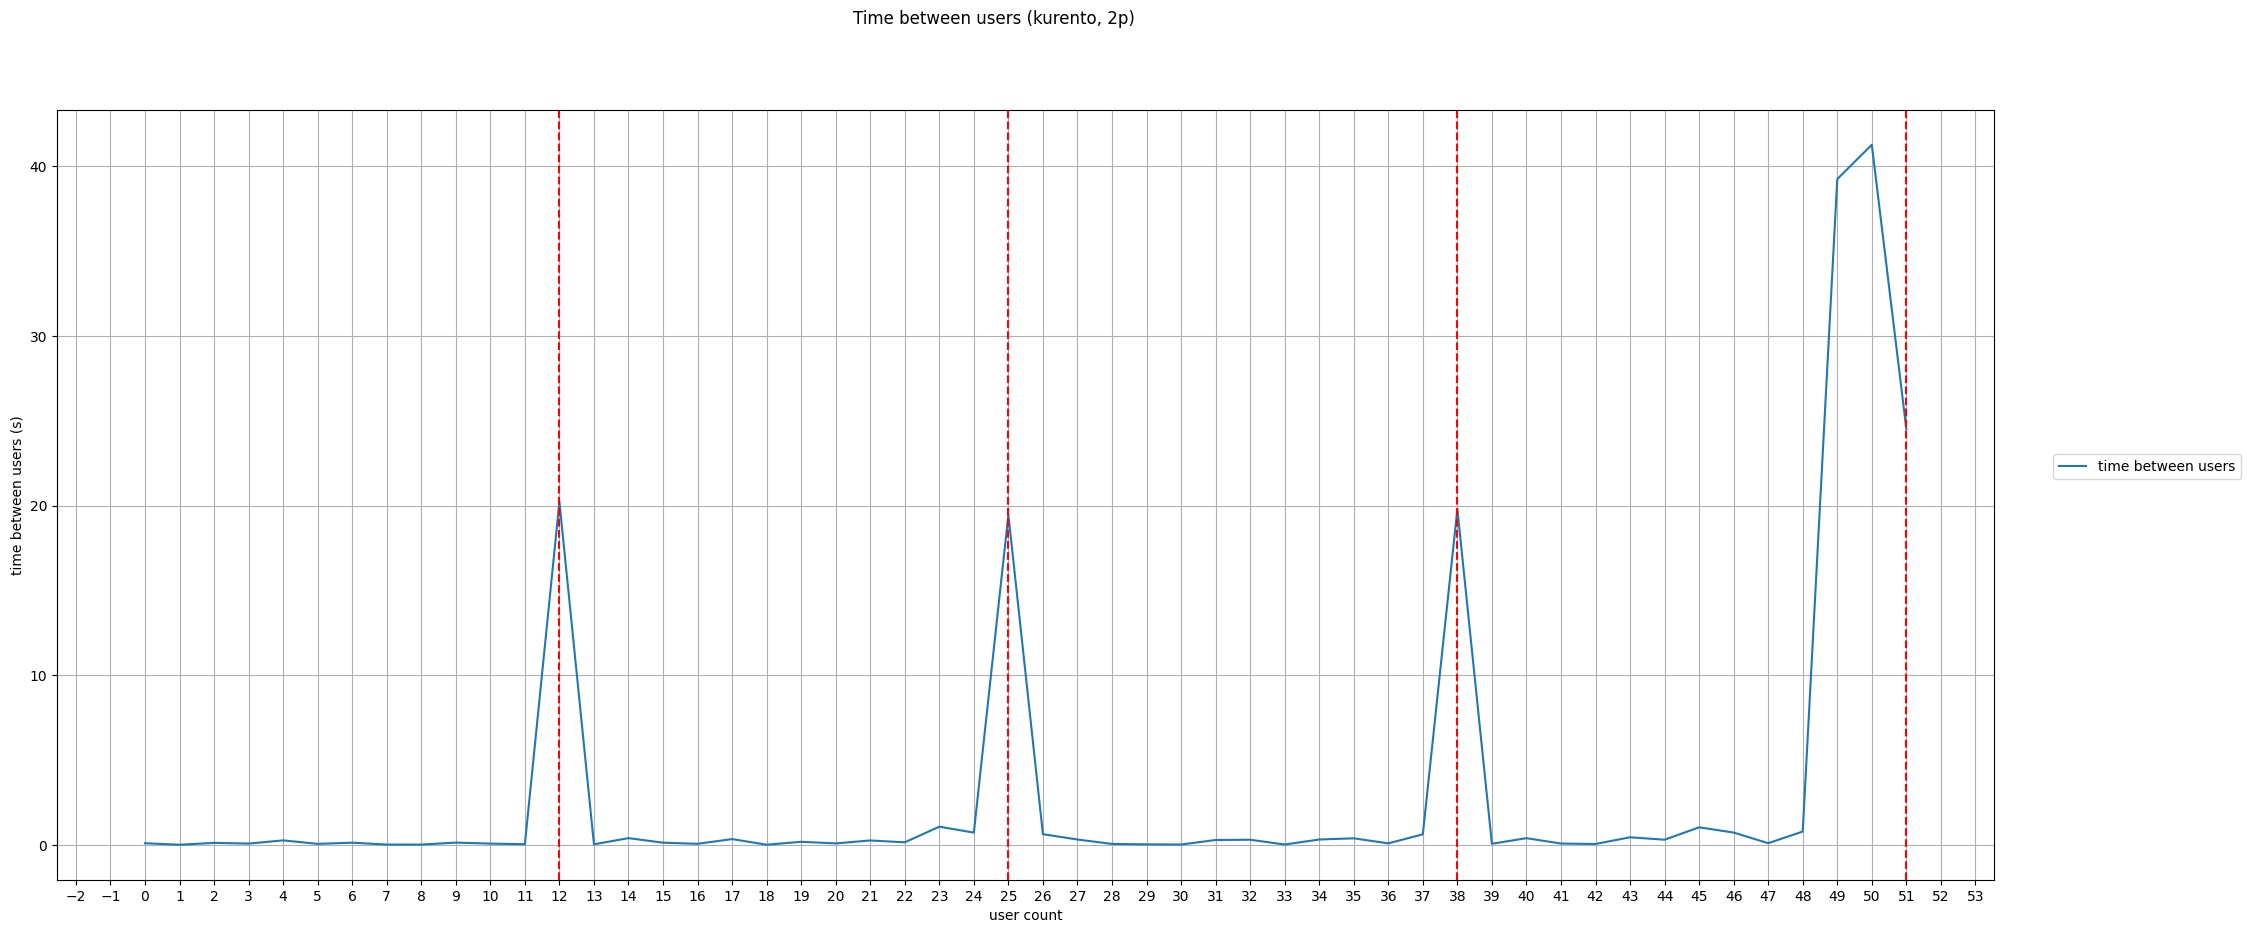

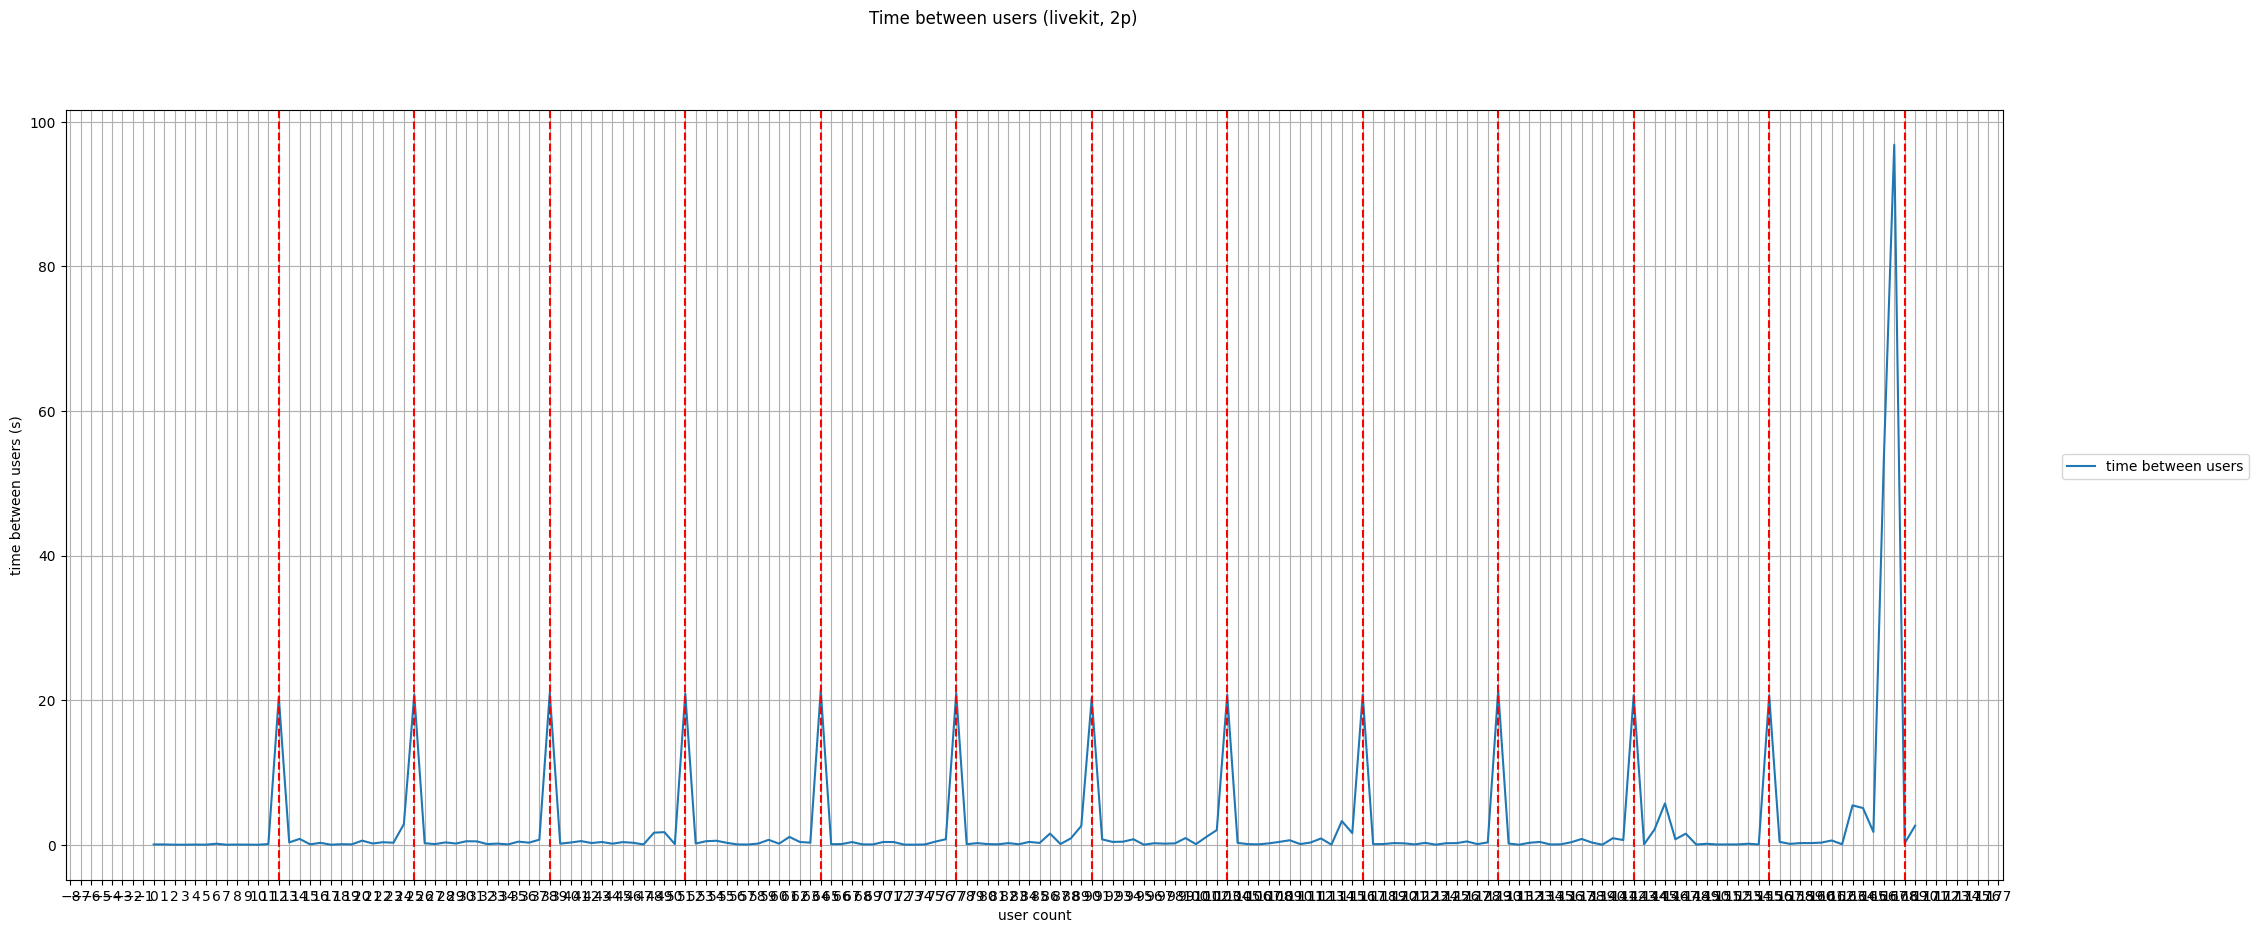

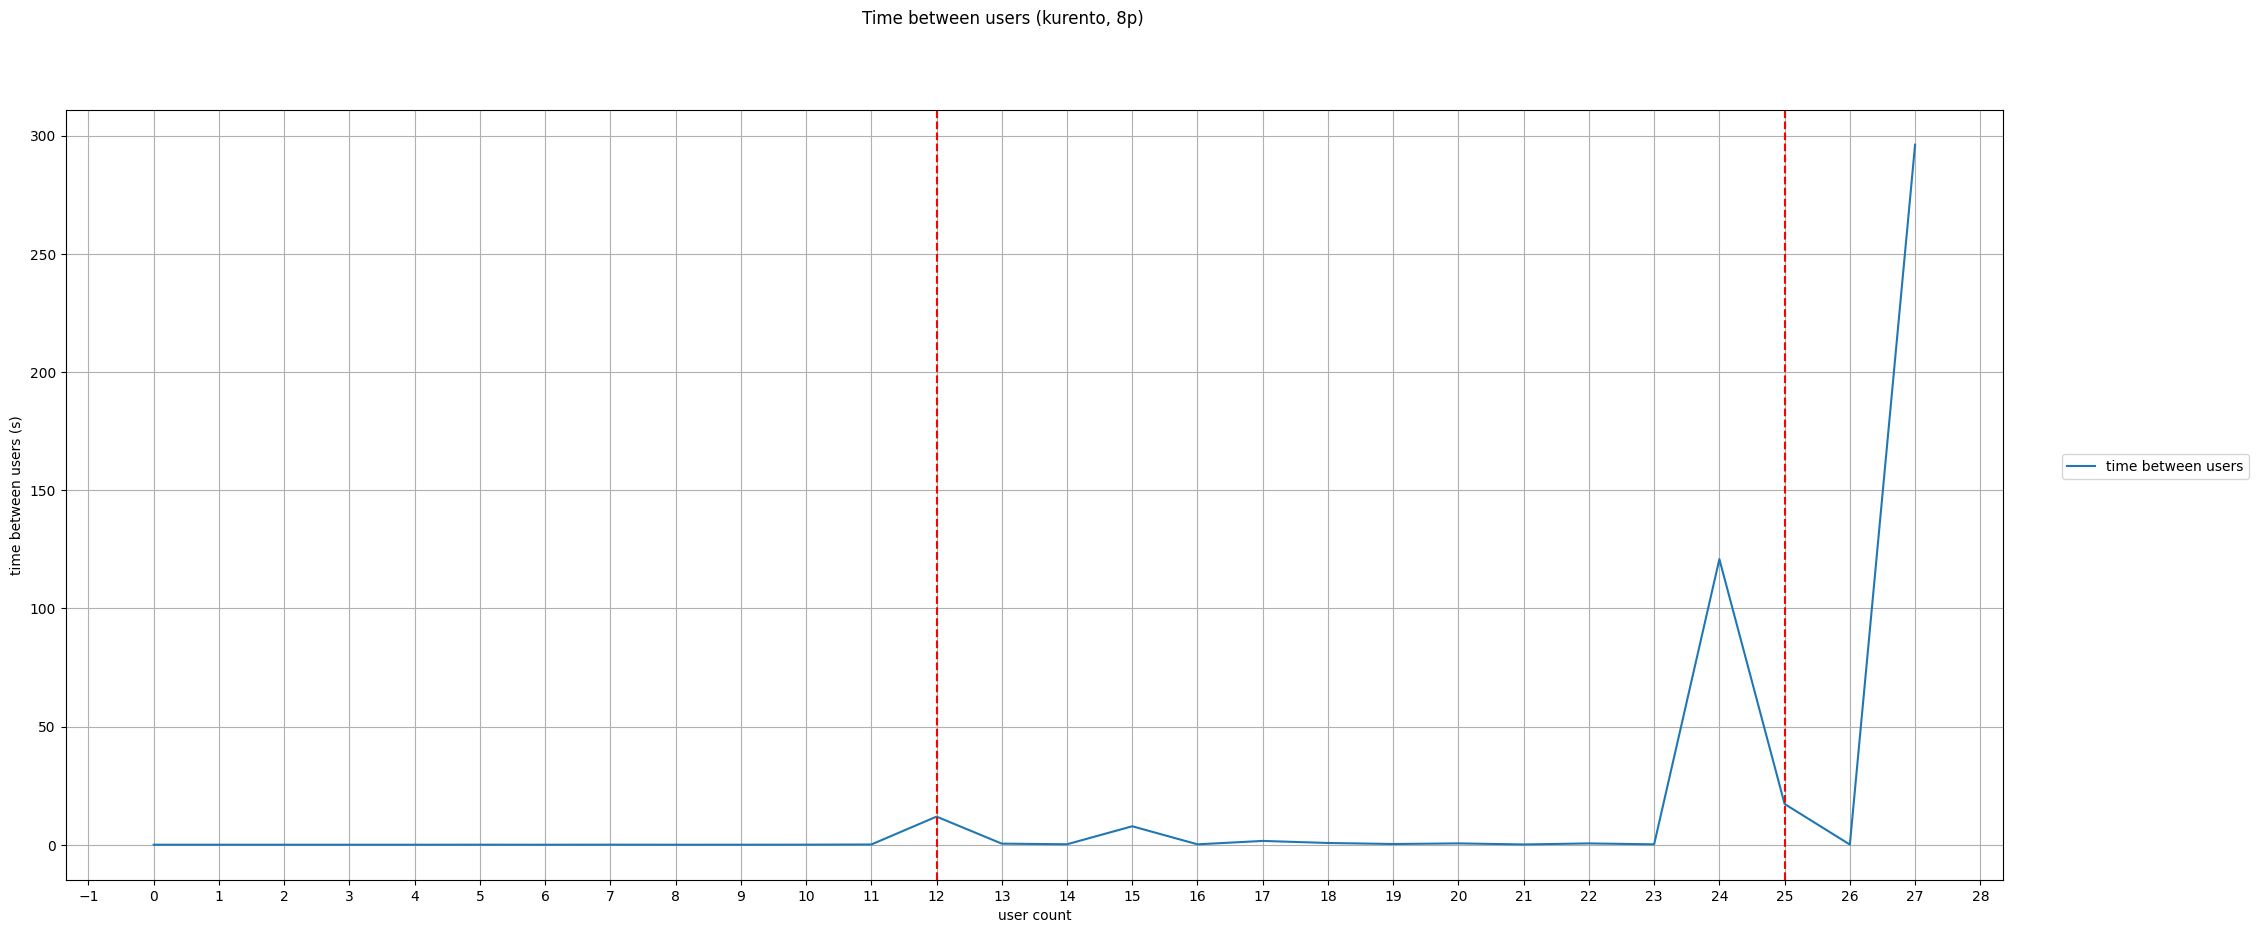

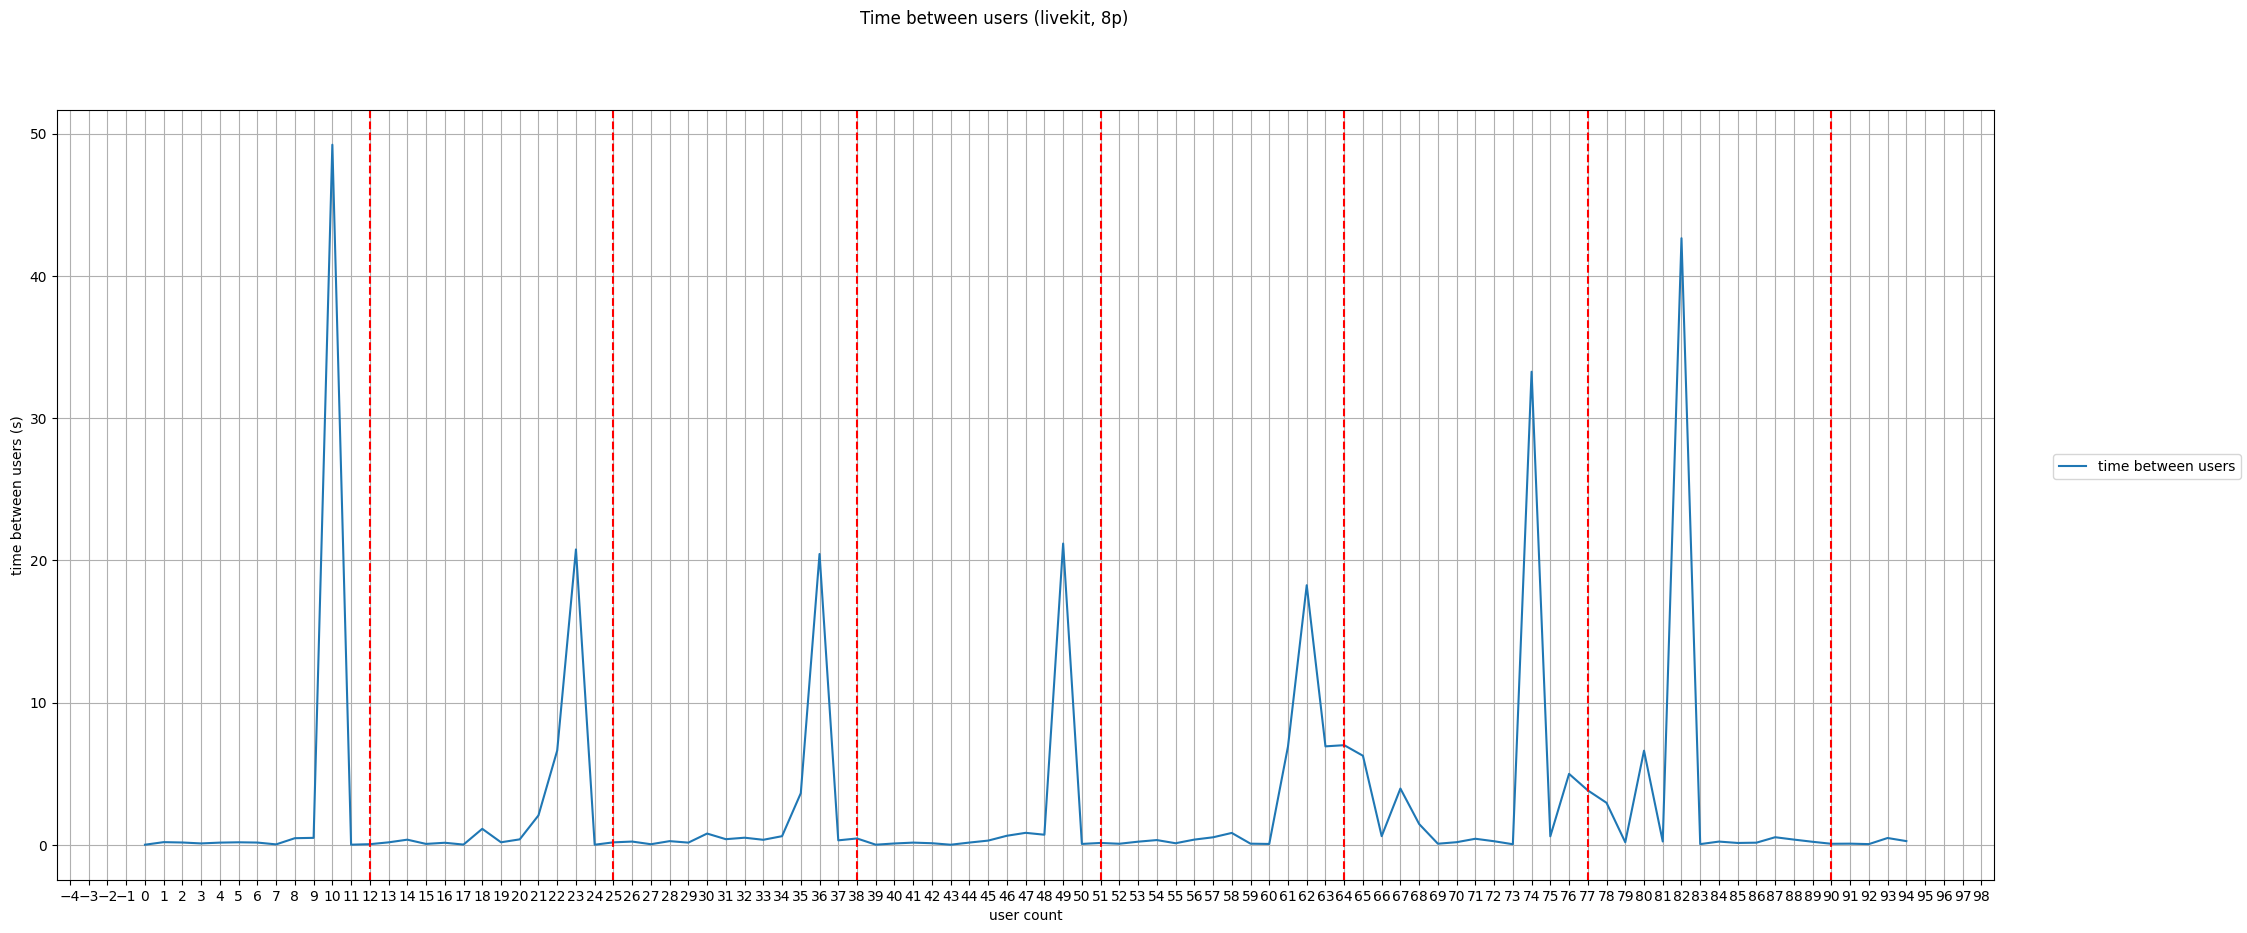

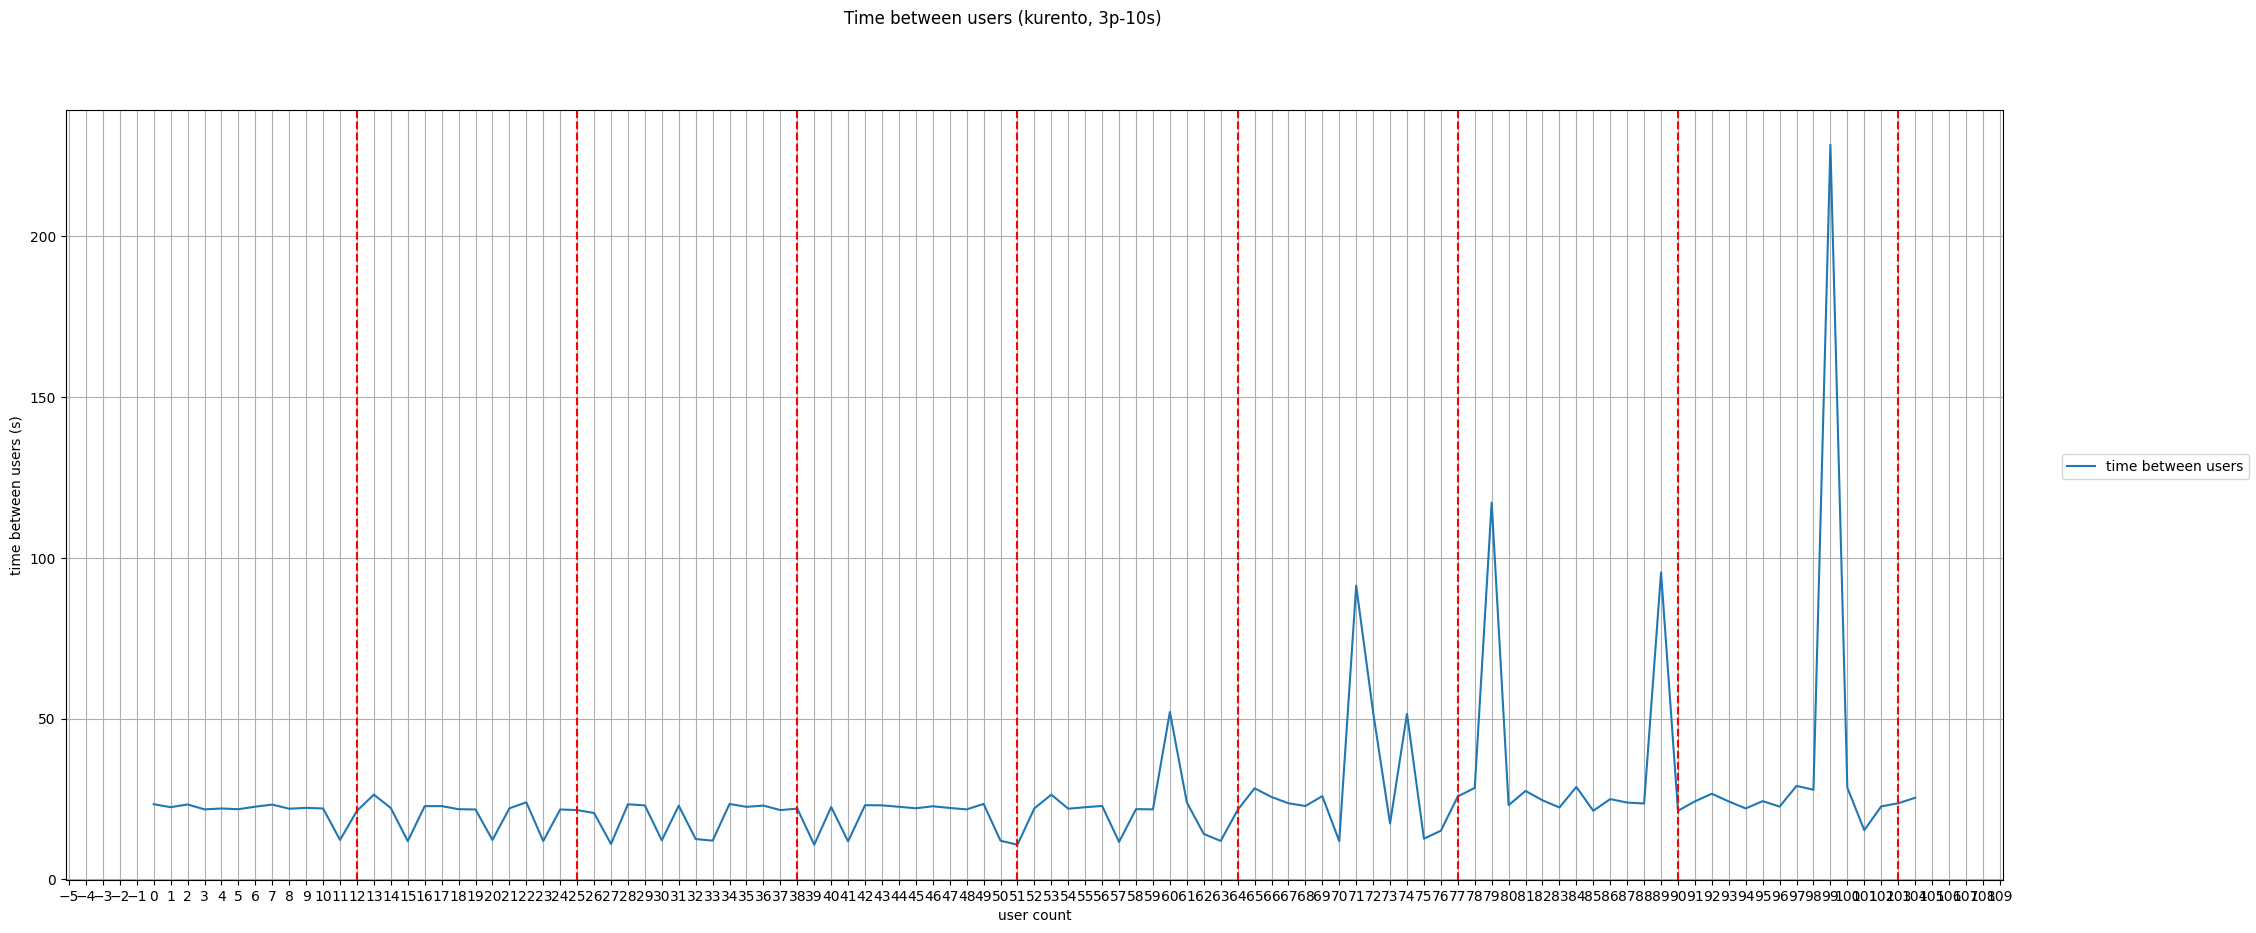

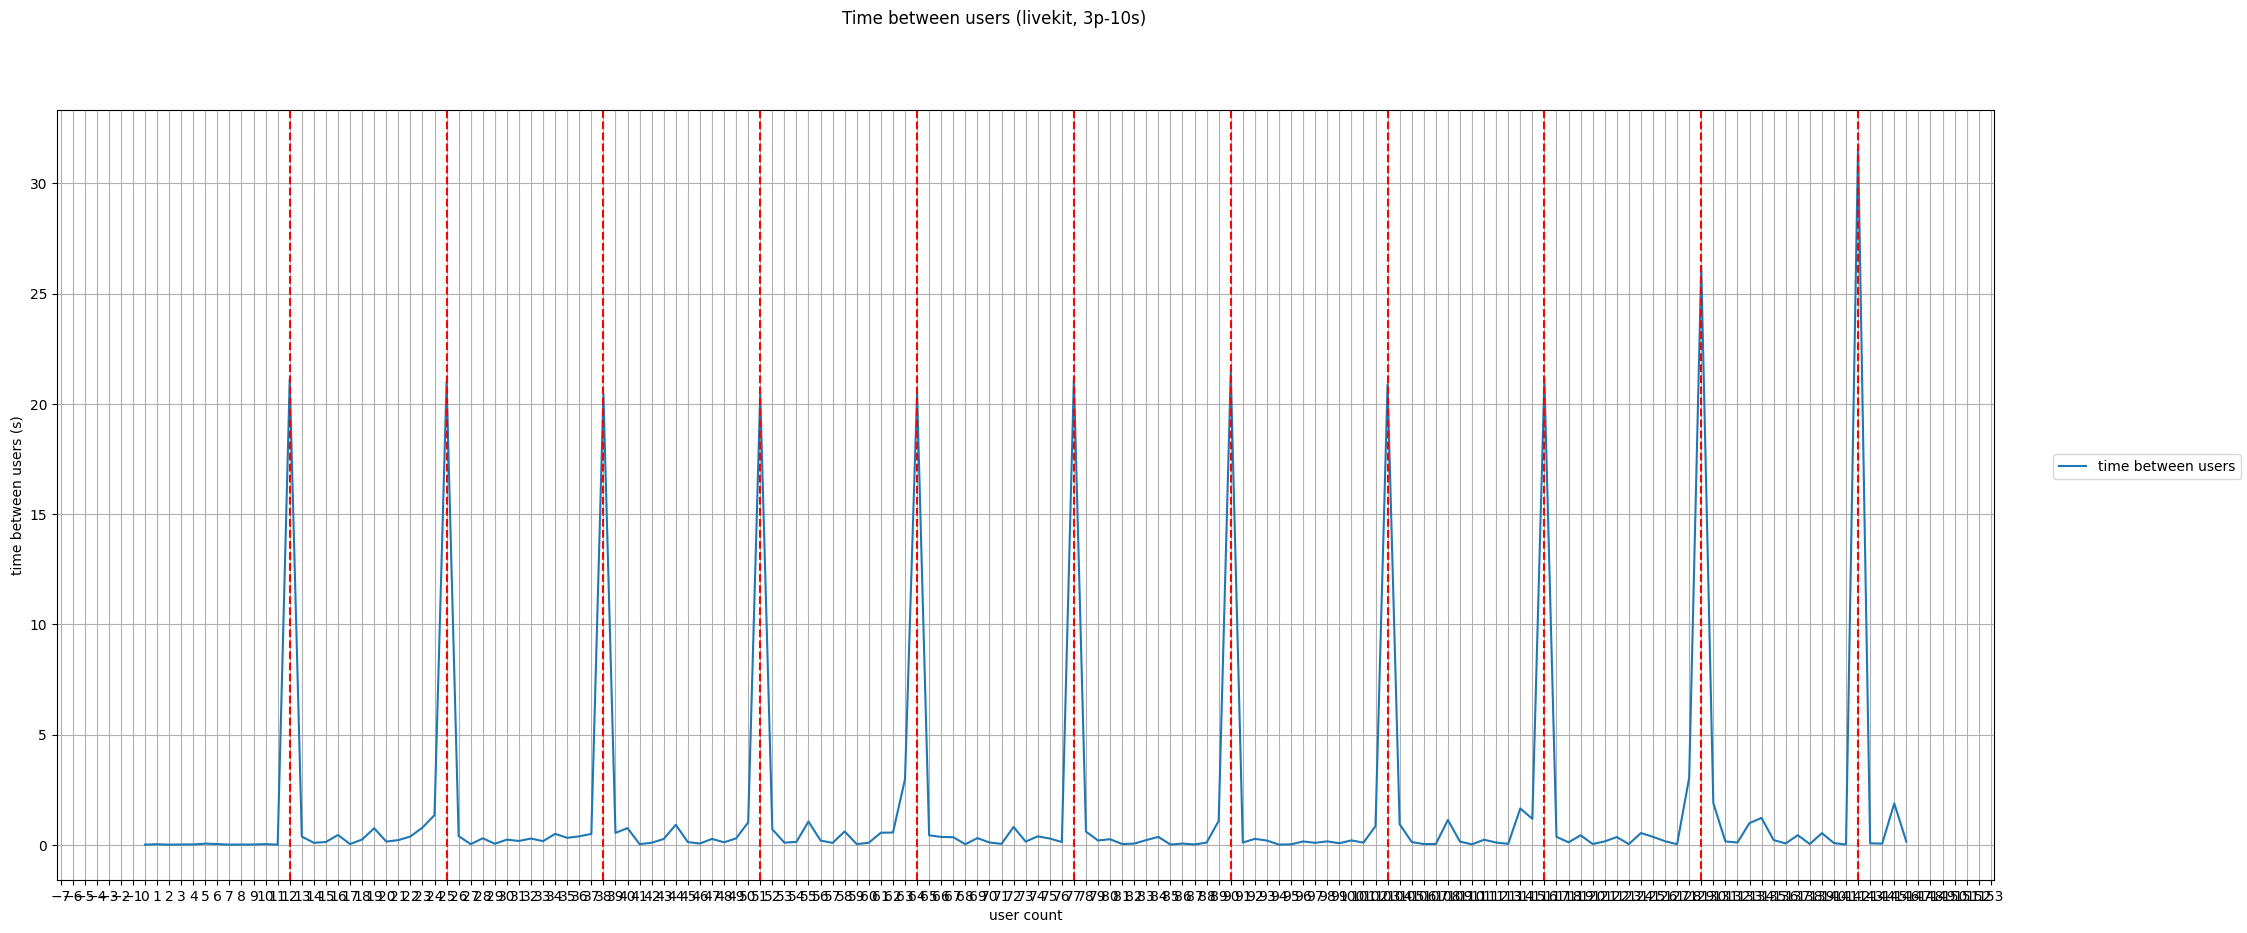

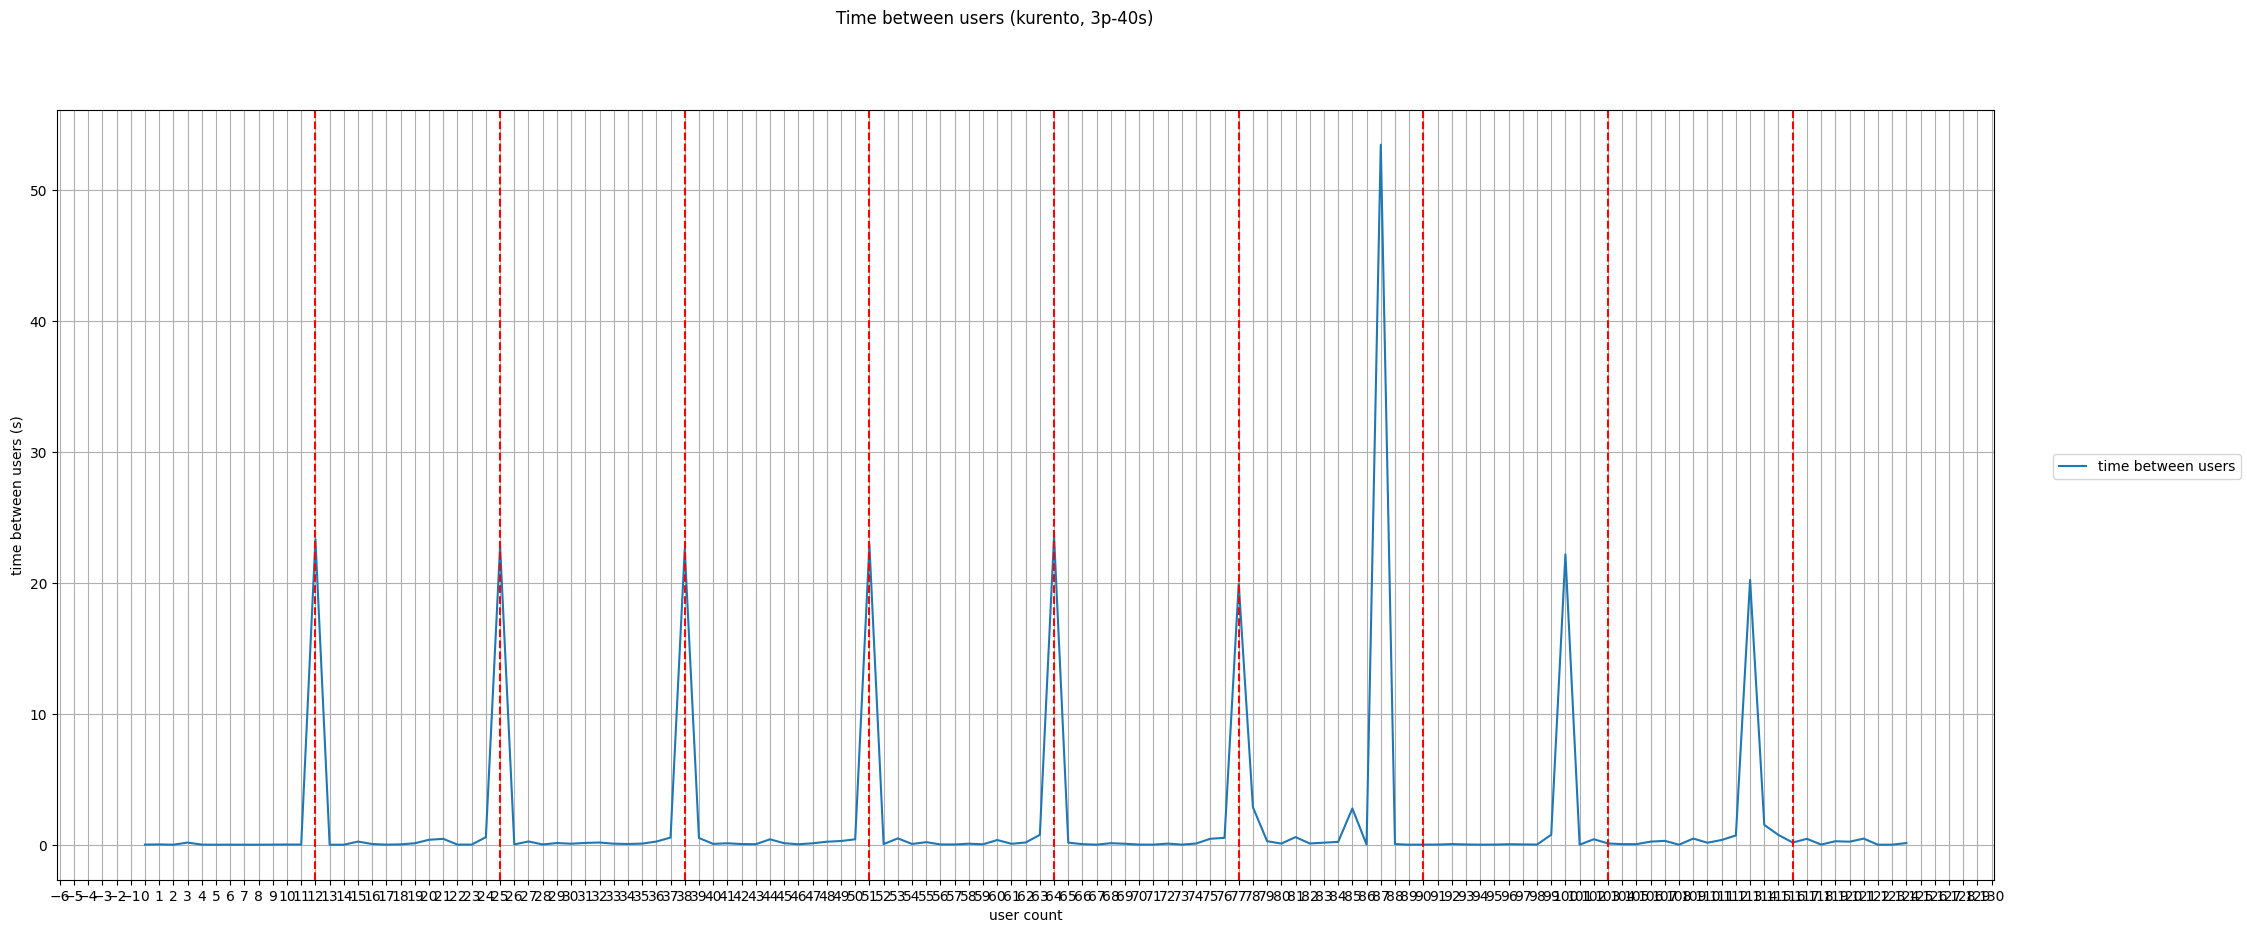

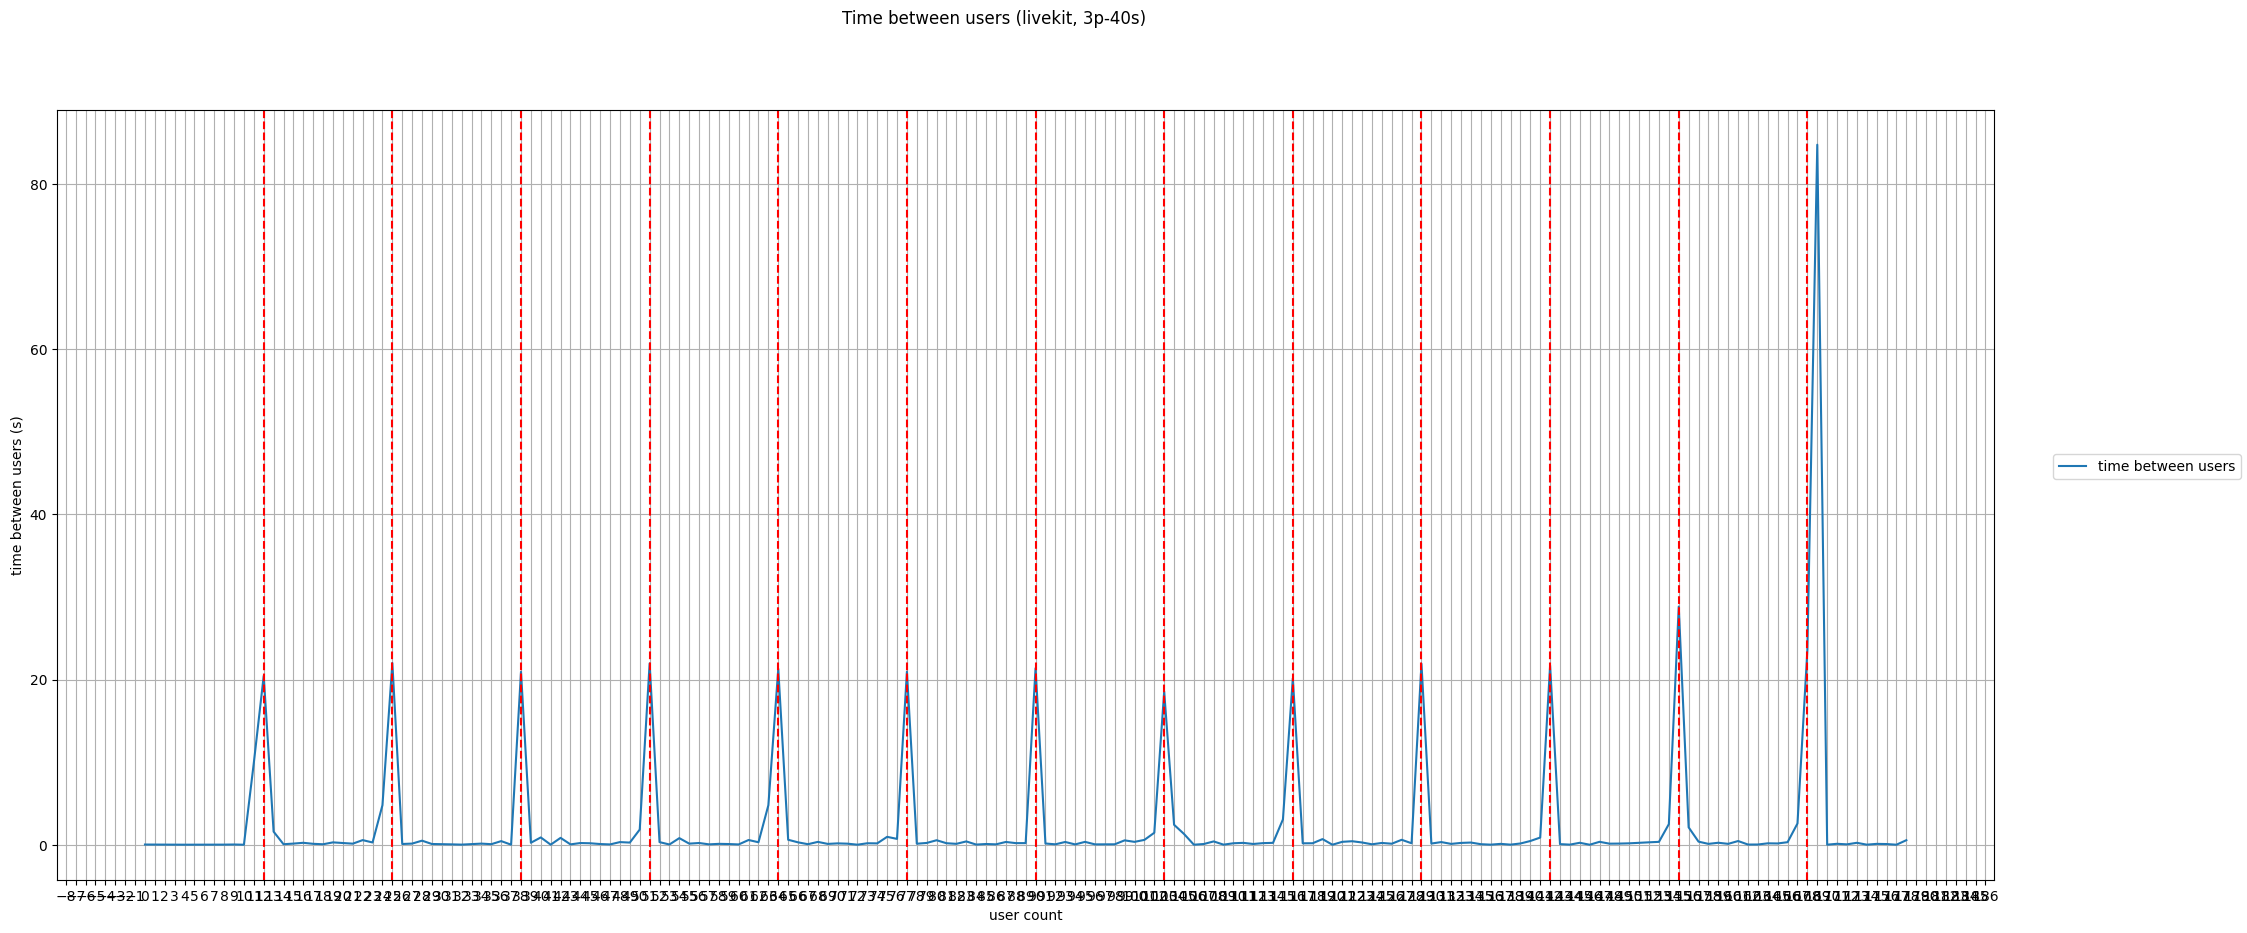

In [26]:
batch_size = 13
typologies = ["2p", "8p", "3p-10s", "3p-40s"]
media_nodes = ["kurento", "livekit"]
# typologies = ["3p-10s"]
# media_nodes = ["kurento"]
for typology in typologies:
    for media_node in media_nodes:
        target_names = filter(
            lambda x: typology in x and media_node in x and "retry" in x, index_list_names
        )
        for i, target_name in enumerate(target_names):
            user_join = pd.read_csv(f"dfs_final/{target_name}-user-join.csv")
            #print(target_name)
            user_join = timestamp_to_secs(user_join, target_name)
            user_join = user_join.sort_values(by="@timestamp")
            time_diffs = []
            fig, ax = plt.subplots()
            for j, row in user_join.iterrows():
                if j != len(user_join) - 1:
                    next_row = user_join.iloc[j + 1]
                    seconds_diff = (next_row["@timestamp"] - row["@timestamp"]).total_seconds()
                    time_diffs.append(seconds_diff)
                    #print(f"{j}: Time difference between users {row["participant"]}-{row["session"]} and {next_row["participant"]}-{row["session"]}: {seconds_diff}s")
            time_diffs = np.array(time_diffs)
            ax.plot(time_diffs, label="time between users")
            # every batch_size x draw vertical line
            for i in range(12, len(time_diffs), batch_size):
                ax.axvline(x=i, color="red", linestyle="--")
            ax.set_xlabel("user count")
            ax.set_ylabel("time between users (s)")
            ax.grid()
            ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
            fig.suptitle(f"Time between users ({media_node}, {typology})")
            fig.legend(loc="right")

            fig.savefig(f"images_final/{typology}_{media_node}_time_between_users.png")
